# OU jump 12

In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) 
    
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, 
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3])
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3']
    
    return stats_data



def loss_function(params):
    """n_real_stats is a global amount calculated outside the function"""
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=alpha, 
        beta1=beta1, beta2=beta2, 
        delta0=delta0, 
        mu1=mu1, mu2=mu2, 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    moment_loss = (n_real_stats - n_sim_stats)**2
    mse = np.sum(moment_loss)
    
    mse[0] = mse[0]*100 # return_mean1
    mse[1] = mse[1]*100 # return_mean2
    mse[2] = mse[2]*100 # return_sd1
    mse[3] = mse[3]*100 # return_sd2
    mse[4] = mse[4]*100 # return_skew1
    mse[5] = mse[5]*100 # return_skew2    
    #mse[6] = mse[6]/3 # return_kurtosis1
    #mse[7] = mse[7]/5 # return_kurtosis2 
    
    mse[8] = mse[8]*10000 # return_autocorrelation_ts1_lag1
    mse[9] = mse[9]*10000
    mse[10] = mse[10]*10000
    mse[11] = mse[11]*10000 # return_autocorrelation_ts2_lag1
    mse[12] = mse[12]*10000
    mse[13] = mse[13]*10000
    
    mse[14] = mse[14]*100 # cross_corr
    mse[15] = mse[15]*10000 # cross_corr_ts1_lag1
    mse[16] = mse[16]*10000
    mse[17] = mse[17]*10000
    mse[18] = mse[18]*10000 # cross_corr_ts2_lag1
    mse[19] = mse[19]*10000
    mse[20] = mse[20]*10000
    
    mse[21] = mse[21]*10000 # sq_return_autocorrelation_ts1_lag1
    mse[22] = mse[22]*10000
    mse[23] = mse[23]*10000
    mse[24] = mse[24]*10000 # sq_return_autocorrelation_ts2_lag1
    mse[25] = mse[25]*10000
    mse[26] = mse[26]*10000
    
    sum_mse = np.sum(mse)

    print(mse)
    print(sum_mse)
    print('----------')

    return sum_mse



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats


alpha = 2
beta1 = 0
beta2 = 0
delta0 = 3
mu1 = 0
mu2 = 0
lambda11 = 1
lambda12 = 0
lambda21 = 0
lambda22 = 1


initial0 = [1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1]  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1

return_mean1                         26528.608981
return_mean2                         24426.334320
return_sd1                           91707.053920
return_sd2                           85658.276819
return_skew1                         29720.235753
return_skew2                         29720.235753
return_kurtosis1                     25783.576233
return_kurtosis2                     52038.196017
return_autocorrelation_ts1_lag1      21558.554844
return_autocorrelation_ts1_lag2      20167.592599
return_autocorrelation_ts1_lag3      21095.567806
return_autocorrelation_ts2_lag1      20829.752675
return_autocorrelation_ts2_lag2      19834.888146
return_autocorrelation_ts2_lag3      19024.247328
return_correlation_ts1_lag_0         12128.315100
return_correlation_ts1_lag_1         21336.624178
return_correlation_ts1_lag_2         18397.597977
return_correlation_ts1_lag_3         23370.245363
return_correlation_ts2_lag_1      

return_mean1                         23736.408904
return_mean2                         23946.344349
return_sd1                           92927.815203
return_sd2                           87700.741288
return_skew1                         31148.922712
return_skew2                         31148.922712
return_kurtosis1                     25251.644360
return_kurtosis2                     52844.599707
return_autocorrelation_ts1_lag1      20276.701357
return_autocorrelation_ts1_lag2      24882.805450
return_autocorrelation_ts1_lag3      20177.504586
return_autocorrelation_ts2_lag1      20412.693611
return_autocorrelation_ts2_lag2      22991.758092
return_autocorrelation_ts2_lag3      24612.770369
return_correlation_ts1_lag_0         12126.684725
return_correlation_ts1_lag_1         18191.544145
return_correlation_ts1_lag_2         21181.480777
return_correlation_ts1_lag_3         26540.017309
return_correlation_ts2_lag_1         20575.105491
return_correlation_ts2_lag_2         22749.614977


return_mean1                         27617.865247
return_mean2                         23498.742131
return_sd1                           91314.419483
return_sd2                           86294.474194
return_skew1                         30275.968268
return_skew2                         30275.968268
return_kurtosis1                     25542.493828
return_kurtosis2                     53901.127788
return_autocorrelation_ts1_lag1      23817.508327
return_autocorrelation_ts1_lag2      22014.321769
return_autocorrelation_ts1_lag3      21396.160698
return_autocorrelation_ts2_lag1      21163.384508
return_autocorrelation_ts2_lag2      22007.860639
return_autocorrelation_ts2_lag3      19811.693603
return_correlation_ts1_lag_0         12128.278488
return_correlation_ts1_lag_1         19050.413437
return_correlation_ts1_lag_2         20683.571539
return_correlation_ts1_lag_3         20584.050218
return_correlation_ts2_lag_1         24723.360215
return_correlation_ts2_lag_2         25250.544147


return_mean1                         28663.338497
return_mean2                         24560.128930
return_sd1                           91603.134630
return_sd2                           86508.717030
return_skew1                         31131.088005
return_skew2                         31131.088005
return_kurtosis1                     25373.153862
return_kurtosis2                     52133.529151
return_autocorrelation_ts1_lag1      25024.811838
return_autocorrelation_ts1_lag2      22494.541258
return_autocorrelation_ts1_lag3      21723.620767
return_autocorrelation_ts2_lag1      22003.405344
return_autocorrelation_ts2_lag2      21442.543766
return_autocorrelation_ts2_lag3      21247.013105
return_correlation_ts1_lag_0         12128.140474
return_correlation_ts1_lag_1         18752.184285
return_correlation_ts1_lag_2         19468.166628
return_correlation_ts1_lag_3         20679.347882
return_correlation_ts2_lag_1         23992.149745
return_correlation_ts2_lag_2         20214.012764


return_mean1                          1756.102096
return_mean2                         23952.425665
return_sd1                           87990.870867
return_sd2                           85157.641147
return_skew1                         28827.069918
return_skew2                         28827.069918
return_kurtosis1                     24837.226634
return_kurtosis2                     48644.426505
return_autocorrelation_ts1_lag1      21188.168843
return_autocorrelation_ts1_lag2      23539.628176
return_autocorrelation_ts1_lag3      21207.244017
return_autocorrelation_ts2_lag1      22524.417537
return_autocorrelation_ts2_lag2      23507.284015
return_autocorrelation_ts2_lag3      19939.693082
return_correlation_ts1_lag_0         12009.341243
return_correlation_ts1_lag_1         20247.065425
return_correlation_ts1_lag_2         24810.304210
return_correlation_ts1_lag_3         25030.921660
return_correlation_ts2_lag_1         23408.469016
return_correlation_ts2_lag_2         21536.784308


return_mean1                          4320.007455
return_mean2                         24943.810691
return_sd1                           92257.492796
return_sd2                           89299.043863
return_skew1                         34987.647377
return_skew2                         34987.647377
return_kurtosis1                     34043.720980
return_kurtosis2                     61288.407351
return_autocorrelation_ts1_lag1      21611.442606
return_autocorrelation_ts1_lag2      19888.887325
return_autocorrelation_ts1_lag3      20791.746373
return_autocorrelation_ts2_lag1      21852.601051
return_autocorrelation_ts2_lag2      18851.775944
return_autocorrelation_ts2_lag3      21572.827706
return_correlation_ts1_lag_0         12013.189735
return_correlation_ts1_lag_1         21835.248993
return_correlation_ts1_lag_2         18739.908324
return_correlation_ts1_lag_3         23431.075796
return_correlation_ts2_lag_1         21906.606186
return_correlation_ts2_lag_2         18439.351874


return_mean1                          4153.219168
return_mean2                         23806.964606
return_sd1                           90097.456259
return_sd2                           88313.832583
return_skew1                         31626.389523
return_skew2                         31626.389523
return_kurtosis1                     26191.307826
return_kurtosis2                     53353.028471
return_autocorrelation_ts1_lag1      22503.537295
return_autocorrelation_ts1_lag2      20232.037302
return_autocorrelation_ts1_lag3      20525.137919
return_autocorrelation_ts2_lag1      22289.140374
return_autocorrelation_ts2_lag2      22442.948432
return_autocorrelation_ts2_lag3      20990.180868
return_correlation_ts1_lag_0         12017.093316
return_correlation_ts1_lag_1         22927.203103
return_correlation_ts1_lag_2         21851.070225
return_correlation_ts1_lag_3         21586.105827
return_correlation_ts2_lag_1         22118.476816
return_correlation_ts2_lag_2         21507.341521


return_mean1                          3595.192751
return_mean2                         17925.136404
return_sd1                           91935.133853
return_sd2                           89841.627699
return_skew1                         33047.852744
return_skew2                         33047.852744
return_kurtosis1                     26258.101648
return_kurtosis2                     53920.691041
return_autocorrelation_ts1_lag1      22009.168305
return_autocorrelation_ts1_lag2      18502.582266
return_autocorrelation_ts1_lag3      23063.361352
return_autocorrelation_ts2_lag1      23188.057072
return_autocorrelation_ts2_lag2      20821.148169
return_autocorrelation_ts2_lag3      23223.583589
return_correlation_ts1_lag_0         11953.389408
return_correlation_ts1_lag_1         22166.461245
return_correlation_ts1_lag_2         18365.858172
return_correlation_ts1_lag_3         20377.429292
return_correlation_ts2_lag_1         21490.880602
return_correlation_ts2_lag_2         18655.517968


return_mean1                          3459.879519
return_mean2                         26091.217513
return_sd1                           90958.299567
return_sd2                           88648.644502
return_skew1                         32049.062644
return_skew2                         32049.062644
return_kurtosis1                     25683.276910
return_kurtosis2                     50564.362382
return_autocorrelation_ts1_lag1      23489.139594
return_autocorrelation_ts1_lag2      19557.238269
return_autocorrelation_ts1_lag3      17292.876494
return_autocorrelation_ts2_lag1      23050.154319
return_autocorrelation_ts2_lag2      19389.308400
return_autocorrelation_ts2_lag3      19845.035242
return_correlation_ts1_lag_0         12021.803443
return_correlation_ts1_lag_1         23011.893885
return_correlation_ts1_lag_2         18051.443961
return_correlation_ts1_lag_3         20921.609355
return_correlation_ts2_lag_1         25425.728482
return_correlation_ts2_lag_2         20369.396181


return_mean1                          3569.325248
return_mean2                         25066.720788
return_sd1                           91388.922856
return_sd2                           88697.461427
return_skew1                         33260.273471
return_skew2                         33260.273471
return_kurtosis1                     25915.409348
return_kurtosis2                     52730.853707
return_autocorrelation_ts1_lag1      20279.630219
return_autocorrelation_ts1_lag2      20563.669746
return_autocorrelation_ts1_lag3      22385.067997
return_autocorrelation_ts2_lag1      21617.410616
return_autocorrelation_ts2_lag2      19978.761148
return_autocorrelation_ts2_lag3      22541.262171
return_correlation_ts1_lag_0         12020.009432
return_correlation_ts1_lag_1         18682.402939
return_correlation_ts1_lag_2         19118.023981
return_correlation_ts1_lag_3         24885.534666
return_correlation_ts2_lag_1         21853.625183
return_correlation_ts2_lag_2         17784.860389


return_mean1                          3527.681137
return_mean2                         24764.763999
return_sd1                           90034.157703
return_sd2                           87652.160915
return_skew1                         31365.808436
return_skew2                         31365.808436
return_kurtosis1                     25093.503081
return_kurtosis2                     52233.521963
return_autocorrelation_ts1_lag1      19341.921196
return_autocorrelation_ts1_lag2      21377.799806
return_autocorrelation_ts1_lag3      21495.335740
return_autocorrelation_ts2_lag1      20318.984259
return_autocorrelation_ts2_lag2      21201.277544
return_autocorrelation_ts2_lag3      20064.273186
return_correlation_ts1_lag_0         12023.237157
return_correlation_ts1_lag_1         21044.505052
return_correlation_ts1_lag_2         20840.098832
return_correlation_ts1_lag_3         23701.952820
return_correlation_ts2_lag_1         20187.707209
return_correlation_ts2_lag_2         18719.567715


return_mean1                          3577.416254
return_mean2                         25639.918834
return_sd1                           88317.661993
return_sd2                           85734.132327
return_skew1                         27986.633853
return_skew2                         27986.633853
return_kurtosis1                     25413.236814
return_kurtosis2                     51088.440023
return_autocorrelation_ts1_lag1      20657.038294
return_autocorrelation_ts1_lag2      22101.271701
return_autocorrelation_ts1_lag3      23561.268221
return_autocorrelation_ts2_lag1      20959.282058
return_autocorrelation_ts2_lag2      23696.618695
return_autocorrelation_ts2_lag3      18197.678751
return_correlation_ts1_lag_0         12019.822952
return_correlation_ts1_lag_1         21077.842025
return_correlation_ts1_lag_2         21014.463890
return_correlation_ts1_lag_3         23278.441537
return_correlation_ts2_lag_1         21031.568032
return_correlation_ts2_lag_2         21457.777760


return_mean1                          3872.845416
return_mean2                          5442.097058
return_sd1                           90280.089005
return_sd2                           85521.943256
return_skew1                         32183.753653
return_skew2                         32183.753653
return_kurtosis1                     26902.153071
return_kurtosis2                     54264.198144
return_autocorrelation_ts1_lag1      23879.939670
return_autocorrelation_ts1_lag2      21193.022744
return_autocorrelation_ts1_lag3      20555.294151
return_autocorrelation_ts2_lag1      23383.606265
return_autocorrelation_ts2_lag2      18671.368295
return_autocorrelation_ts2_lag3      19083.834680
return_correlation_ts1_lag_0         12132.184864
return_correlation_ts1_lag_1         20310.375056
return_correlation_ts1_lag_2         17774.385187
return_correlation_ts1_lag_3         21610.656099
return_correlation_ts2_lag_1         22081.924941
return_correlation_ts2_lag_2         18594.624506


return_mean1                          4122.544369
return_mean2                          6672.743626
return_sd1                           88937.853029
return_sd2                           84631.261753
return_skew1                         30414.800202
return_skew2                         30414.800202
return_kurtosis1                     24228.321989
return_kurtosis2                     51355.377666
return_autocorrelation_ts1_lag1      24297.518967
return_autocorrelation_ts1_lag2      21578.067667
return_autocorrelation_ts1_lag3      19720.897514
return_autocorrelation_ts2_lag1      17989.034472
return_autocorrelation_ts2_lag2      20603.438785
return_autocorrelation_ts2_lag3      20542.640497
return_correlation_ts1_lag_0         12129.691131
return_correlation_ts1_lag_1         17476.909201
return_correlation_ts1_lag_2         20540.638070
return_correlation_ts1_lag_3         22117.457811
return_correlation_ts2_lag_1         19556.225640
return_correlation_ts2_lag_2         21701.767968


return_mean1                          3426.679627
return_mean2                          7028.773430
return_sd1                           92231.134258
return_sd2                           87333.078384
return_skew1                         37657.690916
return_skew2                         37657.690916
return_kurtosis1                     34232.543806
return_kurtosis2                     61396.170133
return_autocorrelation_ts1_lag1      19886.342881
return_autocorrelation_ts1_lag2      24029.971091
return_autocorrelation_ts1_lag3      23120.185631
return_autocorrelation_ts2_lag1      18139.090172
return_autocorrelation_ts2_lag2      22674.449116
return_autocorrelation_ts2_lag3      20909.204402
return_correlation_ts1_lag_0         12129.906337
return_correlation_ts1_lag_1         20286.752364
return_correlation_ts1_lag_2         22181.395601
return_correlation_ts1_lag_3         23050.680631
return_correlation_ts2_lag_1         19353.711582
return_correlation_ts2_lag_2         23208.692982


return_mean1                          4052.725311
return_mean2                          6847.940512
return_sd1                           88921.722044
return_sd2                           85123.385843
return_skew1                         30892.536126
return_skew2                         30892.536126
return_kurtosis1                     25656.898167
return_kurtosis2                     52527.389741
return_autocorrelation_ts1_lag1      24989.280864
return_autocorrelation_ts1_lag2      21359.000471
return_autocorrelation_ts1_lag3      23692.478781
return_autocorrelation_ts2_lag1      22616.778676
return_autocorrelation_ts2_lag2      21081.408387
return_autocorrelation_ts2_lag3      21942.811013
return_correlation_ts1_lag_0         12129.014036
return_correlation_ts1_lag_1         21670.354876
return_correlation_ts1_lag_2         20348.472820
return_correlation_ts1_lag_3         26082.513571
return_correlation_ts2_lag_1         25081.987523
return_correlation_ts2_lag_2         19401.373038


return_mean1                          3217.744544
return_mean2                          6528.111117
return_sd1                           28396.861072
return_sd2                           84613.237720
return_skew1                         37201.731584
return_skew2                         37201.731584
return_kurtosis1                     29361.394052
return_kurtosis2                     52235.216134
return_autocorrelation_ts1_lag1      18624.615146
return_autocorrelation_ts1_lag2      20655.771003
return_autocorrelation_ts1_lag3      23592.260644
return_autocorrelation_ts2_lag1      23056.362598
return_autocorrelation_ts2_lag2      20112.665292
return_autocorrelation_ts2_lag3      18244.893181
return_correlation_ts1_lag_0          5224.909665
return_correlation_ts1_lag_1         19041.816237
return_correlation_ts1_lag_2         20032.400249
return_correlation_ts1_lag_3         24687.093741
return_correlation_ts2_lag_1         21175.976812
return_correlation_ts2_lag_2         20127.831709


return_mean1                          3292.723167
return_mean2                          6808.664887
return_sd1                           28484.437731
return_sd2                           84363.307610
return_skew1                         45143.564550
return_skew2                         45143.564550
return_kurtosis1                     27267.767322
return_kurtosis2                     52816.447799
return_autocorrelation_ts1_lag1      20810.950484
return_autocorrelation_ts1_lag2      19368.873722
return_autocorrelation_ts1_lag3      20963.770880
return_autocorrelation_ts2_lag1      19180.320475
return_autocorrelation_ts2_lag2      18995.862149
return_autocorrelation_ts2_lag3      23474.349452
return_correlation_ts1_lag_0          5413.771642
return_correlation_ts1_lag_1         19668.160951
return_correlation_ts1_lag_2         20444.247626
return_correlation_ts1_lag_3         21974.564278
return_correlation_ts2_lag_1         20390.859392
return_correlation_ts2_lag_2         19476.708219


return_mean1                          3631.289063
return_mean2                          6468.575284
return_sd1                           29640.966381
return_sd2                           86761.594569
return_skew1                         50119.535714
return_skew2                         50119.535714
return_kurtosis1                     39555.247512
return_kurtosis2                     54142.734257
return_autocorrelation_ts1_lag1      21580.138828
return_autocorrelation_ts1_lag2      20050.918616
return_autocorrelation_ts1_lag3      26540.540610
return_autocorrelation_ts2_lag1      23097.425794
return_autocorrelation_ts2_lag2      19885.615216
return_autocorrelation_ts2_lag3      20756.105460
return_correlation_ts1_lag_0          5467.973463
return_correlation_ts1_lag_1         22469.139031
return_correlation_ts1_lag_2         19729.067104
return_correlation_ts1_lag_3         25993.438634
return_correlation_ts2_lag_1         25559.755240
return_correlation_ts2_lag_2         20465.594093


return_mean1                          3067.837460
return_mean2                          6988.023012
return_sd1                           28238.756312
return_sd2                           84814.180065
return_skew1                         36976.026274
return_skew2                         36976.026274
return_kurtosis1                     29236.510193
return_kurtosis2                     49089.674380
return_autocorrelation_ts1_lag1      20984.947424
return_autocorrelation_ts1_lag2      22990.029611
return_autocorrelation_ts1_lag3      21147.362537
return_autocorrelation_ts2_lag1      19868.670014
return_autocorrelation_ts2_lag2      21888.088700
return_autocorrelation_ts2_lag3      19016.611879
return_correlation_ts1_lag_0          5442.865251
return_correlation_ts1_lag_1         20879.000234
return_correlation_ts1_lag_2         21633.118267
return_correlation_ts1_lag_3         22354.451071
return_correlation_ts2_lag_1         23418.636354
return_correlation_ts2_lag_2         20477.718529


return_mean1                           3798.962733
return_mean2                           6890.220811
return_sd1                           100886.418481
return_sd2                            85946.217199
return_skew1                          32257.893440
return_skew2                          32257.893440
return_kurtosis1                      27658.179072
return_kurtosis2                      56437.774548
return_autocorrelation_ts1_lag1       22669.925404
return_autocorrelation_ts1_lag2       23365.885849
return_autocorrelation_ts1_lag3       20393.061084
return_autocorrelation_ts2_lag1       21385.517304
return_autocorrelation_ts2_lag2       23545.352383
return_autocorrelation_ts2_lag3       21551.229217
return_correlation_ts1_lag_0           5246.553992
return_correlation_ts1_lag_1          20546.880910
return_correlation_ts1_lag_2          23574.710376
return_correlation_ts1_lag_3          23546.561378
return_correlation_ts2_lag_1          22491.937671
return_correlation_ts2_lag_2   

return_mean1                          3292.715467
return_mean2                          6793.962140
return_sd1                           24029.101370
return_sd2                           84007.929500
return_skew1                         49394.455373
return_skew2                         49394.455373
return_kurtosis1                     32617.248328
return_kurtosis2                     53055.928272
return_autocorrelation_ts1_lag1      23637.259538
return_autocorrelation_ts1_lag2      21402.455688
return_autocorrelation_ts1_lag3      21827.272988
return_autocorrelation_ts2_lag1      21611.185363
return_autocorrelation_ts2_lag2      22968.456193
return_autocorrelation_ts2_lag3      18146.654850
return_correlation_ts1_lag_0          5465.682600
return_correlation_ts1_lag_1         20902.120971
return_correlation_ts1_lag_2         21349.757721
return_correlation_ts1_lag_3         23123.763270
return_correlation_ts2_lag_1         23387.414731
return_correlation_ts2_lag_2         21589.053470


return_mean1                          3187.022772
return_mean2                          6743.597628
return_sd1                           23443.885112
return_sd2                           84887.030518
return_skew1                         38230.425600
return_skew2                         38230.425600
return_kurtosis1                     30151.504608
return_kurtosis2                     52050.602741
return_autocorrelation_ts1_lag1      21194.194817
return_autocorrelation_ts1_lag2      22033.515458
return_autocorrelation_ts1_lag3      19802.427180
return_autocorrelation_ts2_lag1      18636.626020
return_autocorrelation_ts2_lag2      19728.203935
return_autocorrelation_ts2_lag3      18525.105594
return_correlation_ts1_lag_0          5449.879414
return_correlation_ts1_lag_1         19725.936269
return_correlation_ts1_lag_2         19840.794266
return_correlation_ts1_lag_3         22244.348388
return_correlation_ts2_lag_1         20584.543068
return_correlation_ts2_lag_2         19240.891844


return_mean1                          2710.210409
return_mean2                          7086.673640
return_sd1                           23826.039153
return_sd2                           85816.352235
return_skew1                         44096.579831
return_skew2                         44096.579831
return_kurtosis1                     33537.655334
return_kurtosis2                     52417.251886
return_autocorrelation_ts1_lag1      20904.705236
return_autocorrelation_ts1_lag2      18946.061543
return_autocorrelation_ts1_lag3      20881.268602
return_autocorrelation_ts2_lag1      18675.791664
return_autocorrelation_ts2_lag2      20802.569670
return_autocorrelation_ts2_lag3      23376.852255
return_correlation_ts1_lag_0          5473.361920
return_correlation_ts1_lag_1         18834.387516
return_correlation_ts1_lag_2         19765.337737
return_correlation_ts1_lag_3         24126.833177
return_correlation_ts2_lag_1         23298.781369
return_correlation_ts2_lag_2         20198.203118


return_mean1                          3290.963917
return_mean2                          6144.267156
return_sd1                           24284.299507
return_sd2                           35129.448857
return_skew1                         42870.420095
return_skew2                         42870.420095
return_kurtosis1                     30179.566523
return_kurtosis2                     54533.489537
return_autocorrelation_ts1_lag1      19211.600749
return_autocorrelation_ts1_lag2      24597.808905
return_autocorrelation_ts1_lag3      25763.931419
return_autocorrelation_ts2_lag1      20310.406729
return_autocorrelation_ts2_lag2      22407.320594
return_autocorrelation_ts2_lag3      22702.612907
return_correlation_ts1_lag_0         10405.869350
return_correlation_ts1_lag_1         19597.233462
return_correlation_ts1_lag_2         22636.431058
return_correlation_ts1_lag_3         23805.266137
return_correlation_ts2_lag_1         19599.075324
return_correlation_ts2_lag_2         24228.442383


return_mean1                          3036.743492
return_mean2                          6504.121069
return_sd1                           23508.040737
return_sd2                           31119.019974
return_skew1                         40677.420690
return_skew2                         40677.420690
return_kurtosis1                     29728.462168
return_kurtosis2                     53967.773718
return_autocorrelation_ts1_lag1      21220.982543
return_autocorrelation_ts1_lag2      20223.318110
return_autocorrelation_ts1_lag3      23294.260794
return_autocorrelation_ts2_lag1      21144.512274
return_autocorrelation_ts2_lag2      20264.736061
return_autocorrelation_ts2_lag3      20184.690058
return_correlation_ts1_lag_0         10985.814018
return_correlation_ts1_lag_1         19158.945262
return_correlation_ts1_lag_2         18292.710408
return_correlation_ts1_lag_3         23847.394981
return_correlation_ts2_lag_1         21395.877666
return_correlation_ts2_lag_2         21757.166492


return_mean1                          2697.935110
return_mean2                          7011.511107
return_sd1                           24556.729739
return_sd2                           33676.815739
return_skew1                         39525.483473
return_skew2                         39525.483473
return_kurtosis1                     30551.816607
return_kurtosis2                     52968.232823
return_autocorrelation_ts1_lag1      20956.454285
return_autocorrelation_ts1_lag2      20837.303439
return_autocorrelation_ts1_lag3      21613.219715
return_autocorrelation_ts2_lag1      17229.942795
return_autocorrelation_ts2_lag2      18463.528608
return_autocorrelation_ts2_lag3      22775.624529
return_correlation_ts1_lag_0         10770.007012
return_correlation_ts1_lag_1         17814.214126
return_correlation_ts1_lag_2         20246.405792
return_correlation_ts1_lag_3         23862.805346
return_correlation_ts2_lag_1         20508.329501
return_correlation_ts2_lag_2         19811.409030


return_mean1                          2829.015264
return_mean2                          6553.491943
return_sd1                           23709.632174
return_sd2                           33405.237319
return_skew1                         35142.018520
return_skew2                         35142.018520
return_kurtosis1                     29345.302831
return_kurtosis2                     51629.319338
return_autocorrelation_ts1_lag1      22443.715235
return_autocorrelation_ts1_lag2      22797.985006
return_autocorrelation_ts1_lag3      21320.643518
return_autocorrelation_ts2_lag1      20077.207360
return_autocorrelation_ts2_lag2      21993.057302
return_autocorrelation_ts2_lag3      19323.236594
return_correlation_ts1_lag_0         10747.851728
return_correlation_ts1_lag_1         20349.200244
return_correlation_ts1_lag_2         22082.079976
return_correlation_ts1_lag_3         24338.059594
return_correlation_ts2_lag_1         21840.844441
return_correlation_ts2_lag_2         22542.939707


return_mean1                          3001.897403
return_mean2                          6385.813650
return_sd1                           24675.158487
return_sd2                           33178.068672
return_skew1                         36631.802277
return_skew2                         36631.802277
return_kurtosis1                     25879.342285
return_kurtosis2                     51606.970636
return_autocorrelation_ts1_lag1      19908.601388
return_autocorrelation_ts1_lag2      22666.012491
return_autocorrelation_ts1_lag3      20770.568611
return_autocorrelation_ts2_lag1      21859.984131
return_autocorrelation_ts2_lag2      19631.960027
return_autocorrelation_ts2_lag3      19072.684943
return_correlation_ts1_lag_0         10747.525677
return_correlation_ts1_lag_1         19082.977547
return_correlation_ts1_lag_2         19470.654165
return_correlation_ts1_lag_3         19715.894323
return_correlation_ts2_lag_1         21339.871660
return_correlation_ts2_lag_2         20747.963053


return_mean1                          2612.324650
return_mean2                          7217.654148
return_sd1                           23779.875822
return_sd2                           39019.263689
return_skew1                         42309.881210
return_skew2                         42309.881210
return_kurtosis1                     29857.294022
return_kurtosis2                     54227.471157
return_autocorrelation_ts1_lag1      20036.569680
return_autocorrelation_ts1_lag2      20153.280438
return_autocorrelation_ts1_lag3      18392.470896
return_autocorrelation_ts2_lag1      21291.637067
return_autocorrelation_ts2_lag2      20031.632566
return_autocorrelation_ts2_lag3      20099.494183
return_correlation_ts1_lag_0         10862.000410
return_correlation_ts1_lag_1         21499.820932
return_correlation_ts1_lag_2         19893.964731
return_correlation_ts1_lag_3         23030.319429
return_correlation_ts2_lag_1         21003.142994
return_correlation_ts2_lag_2         19796.614710


return_mean1                          3078.461767
return_mean2                          7025.227701
return_sd1                           24465.046482
return_sd2                           34042.938545
return_skew1                         47612.281324
return_skew2                         47612.281324
return_kurtosis1                     30425.036620
return_kurtosis2                     54310.795308
return_autocorrelation_ts1_lag1      19677.163565
return_autocorrelation_ts1_lag2      20588.514405
return_autocorrelation_ts1_lag3      22874.798642
return_autocorrelation_ts2_lag1      18764.378276
return_autocorrelation_ts2_lag2      20327.010507
return_autocorrelation_ts2_lag3      21813.267330
return_correlation_ts1_lag_0         10751.012942
return_correlation_ts1_lag_1         19609.207865
return_correlation_ts1_lag_2         19596.157593
return_correlation_ts1_lag_3         22629.309873
return_correlation_ts2_lag_1         18811.838252
return_correlation_ts2_lag_2         22725.453573


return_mean1                          2834.941131
return_mean2                          6889.843063
return_sd1                           24323.078318
return_sd2                           33473.806706
return_skew1                         38498.070989
return_skew2                         38498.070989
return_kurtosis1                     27391.067540
return_kurtosis2                     49220.363785
return_autocorrelation_ts1_lag1      19277.287290
return_autocorrelation_ts1_lag2      20779.348705
return_autocorrelation_ts1_lag3      22926.082660
return_autocorrelation_ts2_lag1      18378.758744
return_autocorrelation_ts2_lag2      20057.976768
return_autocorrelation_ts2_lag3      23409.512489
return_correlation_ts1_lag_0         10726.695811
return_correlation_ts1_lag_1         19073.338448
return_correlation_ts1_lag_2         19555.328506
return_correlation_ts1_lag_3         24013.109176
return_correlation_ts2_lag_1         23630.066847
return_correlation_ts2_lag_2         20883.644116


return_mean1                          3317.609254
return_mean2                          6017.592692
return_sd1                           23893.879077
return_sd2                           33735.106438
return_skew1                         39388.584901
return_skew2                         39388.584901
return_kurtosis1                     27850.200784
return_kurtosis2                     51105.850114
return_autocorrelation_ts1_lag1      20976.911612
return_autocorrelation_ts1_lag2      21990.262100
return_autocorrelation_ts1_lag3      18993.933827
return_autocorrelation_ts2_lag1      22918.540172
return_autocorrelation_ts2_lag2      20735.486484
return_autocorrelation_ts2_lag3      19813.072337
return_correlation_ts1_lag_0         10755.425017
return_correlation_ts1_lag_1         23194.698414
return_correlation_ts1_lag_2         19756.389142
return_correlation_ts1_lag_3         22354.597223
return_correlation_ts2_lag_1         21136.572169
return_correlation_ts2_lag_2         21035.336827


return_mean1                          2951.390487
return_mean2                          6487.019979
return_sd1                           23307.251754
return_sd2                           32543.971123
return_skew1                         39042.969228
return_skew2                         39042.969228
return_kurtosis1                     21746.168686
return_kurtosis2                     52626.650283
return_autocorrelation_ts1_lag1      21046.289918
return_autocorrelation_ts1_lag2      20677.335629
return_autocorrelation_ts1_lag3      21137.351757
return_autocorrelation_ts2_lag1      23780.018670
return_autocorrelation_ts2_lag2      22140.677482
return_autocorrelation_ts2_lag3      21621.286680
return_correlation_ts1_lag_0         10732.887269
return_correlation_ts1_lag_1         19730.106604
return_correlation_ts1_lag_2         20893.071203
return_correlation_ts1_lag_3         23635.705678
return_correlation_ts2_lag_1         23672.214341
return_correlation_ts2_lag_2         20544.885089


return_mean1                          3158.480592
return_mean2                          6301.088230
return_sd1                           23860.537882
return_sd2                           33075.965988
return_skew1                         38615.695174
return_skew2                         38615.695174
return_kurtosis1                     27450.059809
return_kurtosis2                     50109.585745
return_autocorrelation_ts1_lag1      19668.197011
return_autocorrelation_ts1_lag2      22249.066820
return_autocorrelation_ts1_lag3      22179.947639
return_autocorrelation_ts2_lag1      18619.897455
return_autocorrelation_ts2_lag2      21981.955586
return_autocorrelation_ts2_lag3      20640.786437
return_correlation_ts1_lag_0         10765.613758
return_correlation_ts1_lag_1         19877.766635
return_correlation_ts1_lag_2         20657.485786
return_correlation_ts1_lag_3         21073.248462
return_correlation_ts2_lag_1         21855.381073
return_correlation_ts2_lag_2         23761.229472


return_mean1                          2862.289435
return_mean2                          6541.493377
return_sd1                           23758.546878
return_sd2                           33170.157150
return_skew1                         42435.316071
return_skew2                         42435.316071
return_kurtosis1                     34839.353289
return_kurtosis2                     53212.224207
return_autocorrelation_ts1_lag1      21866.135826
return_autocorrelation_ts1_lag2      20915.433263
return_autocorrelation_ts1_lag3      22479.146478
return_autocorrelation_ts2_lag1      22852.128801
return_autocorrelation_ts2_lag2      22451.794835
return_autocorrelation_ts2_lag3      22069.330788
return_correlation_ts1_lag_0         10739.358059
return_correlation_ts1_lag_1         19186.206395
return_correlation_ts1_lag_2         19844.766004
return_correlation_ts1_lag_3         24164.179415
return_correlation_ts2_lag_1         22281.086144
return_correlation_ts2_lag_2         21296.680853


return_mean1                          3278.743705
return_mean2                          6456.701424
return_sd1                           24464.643404
return_sd2                           34129.115997
return_skew1                         38456.193912
return_skew2                         38456.193912
return_kurtosis1                     23737.872007
return_kurtosis2                     51693.205639
return_autocorrelation_ts1_lag1      20298.435369
return_autocorrelation_ts1_lag2      20224.291508
return_autocorrelation_ts1_lag3      21409.357894
return_autocorrelation_ts2_lag1      20691.515393
return_autocorrelation_ts2_lag2      19022.715441
return_autocorrelation_ts2_lag3      21486.627496
return_correlation_ts1_lag_0         10763.772582
return_correlation_ts1_lag_1         19143.726028
return_correlation_ts1_lag_2         19564.503354
return_correlation_ts1_lag_3         23395.051858
return_correlation_ts2_lag_1         22948.567304
return_correlation_ts2_lag_2         20006.783643


return_mean1                          3022.716400
return_mean2                          6418.617186
return_sd1                           23477.465687
return_sd2                           32676.246834
return_skew1                         40761.242264
return_skew2                         40761.242264
return_kurtosis1                     30699.461072
return_kurtosis2                     55681.917312
return_autocorrelation_ts1_lag1      20159.986145
return_autocorrelation_ts1_lag2      21787.708656
return_autocorrelation_ts1_lag3      20995.889560
return_autocorrelation_ts2_lag1      19816.818982
return_autocorrelation_ts2_lag2      22901.869452
return_autocorrelation_ts2_lag3      20400.443905
return_correlation_ts1_lag_0         10754.875814
return_correlation_ts1_lag_1         16736.732681
return_correlation_ts1_lag_2         19631.578438
return_correlation_ts1_lag_3         23571.950901
return_correlation_ts2_lag_1         23189.715853
return_correlation_ts2_lag_2         25959.798353


return_mean1                          2894.901938
return_mean2                          6506.406632
return_sd1                           18493.533138
return_sd2                           34183.062774
return_skew1                         26864.183452
return_skew2                         26864.183452
return_kurtosis1                     20053.450949
return_kurtosis2                     67562.092305
return_autocorrelation_ts1_lag1      22206.005462
return_autocorrelation_ts1_lag2      22209.388859
return_autocorrelation_ts1_lag3      21082.964103
return_autocorrelation_ts2_lag1      21239.445901
return_autocorrelation_ts2_lag2      22680.986217
return_autocorrelation_ts2_lag3      22282.041942
return_correlation_ts1_lag_0          9382.579299
return_correlation_ts1_lag_1         19476.887058
return_correlation_ts1_lag_2         19118.247156
return_correlation_ts1_lag_3         23338.444482
return_correlation_ts2_lag_1         22074.074540
return_correlation_ts2_lag_2         22232.214674


return_mean1                          3038.545971
return_mean2                          6471.997329
return_sd1                           25601.833484
return_sd2                           33309.977336
return_skew1                         47361.418012
return_skew2                         47361.418012
return_kurtosis1                     38076.311740
return_kurtosis2                     55895.738015
return_autocorrelation_ts1_lag1      21675.469271
return_autocorrelation_ts1_lag2      23898.699718
return_autocorrelation_ts1_lag3      20334.559303
return_autocorrelation_ts2_lag1      21387.579179
return_autocorrelation_ts2_lag2      22179.920389
return_autocorrelation_ts2_lag3      21041.256625
return_correlation_ts1_lag_0         10726.202329
return_correlation_ts1_lag_1         21948.211862
return_correlation_ts1_lag_2         20759.961692
return_correlation_ts1_lag_3         24438.457948
return_correlation_ts2_lag_1         20043.530794
return_correlation_ts2_lag_2         23466.243818


return_mean1                          3055.530751
return_mean2                          6484.381701
return_sd1                           22928.737526
return_sd2                           32489.668247
return_skew1                         40545.178659
return_skew2                         40545.178659
return_kurtosis1                     25622.915557
return_kurtosis2                     54517.568487
return_autocorrelation_ts1_lag1      22077.408255
return_autocorrelation_ts1_lag2      24025.465849
return_autocorrelation_ts1_lag3      19624.973168
return_autocorrelation_ts2_lag1      21723.020288
return_autocorrelation_ts2_lag2      22407.584618
return_autocorrelation_ts2_lag3      19982.340470
return_correlation_ts1_lag_0         10729.697357
return_correlation_ts1_lag_1         21073.649054
return_correlation_ts1_lag_2         22625.578390
return_correlation_ts1_lag_3         21109.902080
return_correlation_ts2_lag_1         24939.140522
return_correlation_ts2_lag_2         24161.381414


return_mean1                          2890.702791
return_mean2                          6514.907903
return_sd1                           24330.182610
return_sd2                           33685.126620
return_skew1                         37001.316540
return_skew2                         37001.316540
return_kurtosis1                     26637.256504
return_kurtosis2                     52596.016547
return_autocorrelation_ts1_lag1      23162.285934
return_autocorrelation_ts1_lag2      22956.556474
return_autocorrelation_ts1_lag3      21180.956430
return_autocorrelation_ts2_lag1      20164.666063
return_autocorrelation_ts2_lag2      22256.609768
return_autocorrelation_ts2_lag3      21571.183421
return_correlation_ts1_lag_0         10763.166636
return_correlation_ts1_lag_1         19991.201546
return_correlation_ts1_lag_2         20040.103827
return_correlation_ts1_lag_3         20706.093741
return_correlation_ts2_lag_1         23288.683373
return_correlation_ts2_lag_2         20746.712012


return_mean1                          3172.162021
return_mean2                          6314.245471
return_sd1                           22972.665450
return_sd2                           32226.495190
return_skew1                         38795.820374
return_skew2                         38795.820374
return_kurtosis1                     27482.292484
return_kurtosis2                     53321.662061
return_autocorrelation_ts1_lag1      20335.698999
return_autocorrelation_ts1_lag2      19192.471549
return_autocorrelation_ts1_lag3      21013.606985
return_autocorrelation_ts2_lag1      19577.720077
return_autocorrelation_ts2_lag2      19195.052213
return_autocorrelation_ts2_lag3      21351.195480
return_correlation_ts1_lag_0         10755.570241
return_correlation_ts1_lag_1         20530.338571
return_correlation_ts1_lag_2         16962.797364
return_correlation_ts1_lag_3         24534.137468
return_correlation_ts2_lag_1         23266.622899
return_correlation_ts2_lag_2         20843.649135


return_mean1                          3160.662257
return_mean2                          6913.586657
return_sd1                           23373.776767
return_sd2                           32871.728965
return_skew1                         45883.940857
return_skew2                         45883.940857
return_kurtosis1                     27670.201121
return_kurtosis2                     50939.173604
return_autocorrelation_ts1_lag1      23021.439956
return_autocorrelation_ts1_lag2      21505.228834
return_autocorrelation_ts1_lag3      21412.773683
return_autocorrelation_ts2_lag1      21693.355632
return_autocorrelation_ts2_lag2      20805.986424
return_autocorrelation_ts2_lag3      20454.434569
return_correlation_ts1_lag_0         10733.426054
return_correlation_ts1_lag_1         20202.263309
return_correlation_ts1_lag_2         21878.167204
return_correlation_ts1_lag_3         23009.554371
return_correlation_ts2_lag_1         22368.226953
return_correlation_ts2_lag_2         20593.802808


return_mean1                          3262.806926
return_mean2                          6059.131971
return_sd1                           24612.303344
return_sd2                           34270.326247
return_skew1                         55424.275430
return_skew2                         55424.275430
return_kurtosis1                     43156.200592
return_kurtosis2                     63396.871738
return_autocorrelation_ts1_lag1      21665.963270
return_autocorrelation_ts1_lag2      19738.844994
return_autocorrelation_ts1_lag3      22138.636973
return_autocorrelation_ts2_lag1      22181.731870
return_autocorrelation_ts2_lag2      19940.653402
return_autocorrelation_ts2_lag3      21144.716096
return_correlation_ts1_lag_0         10773.705840
return_correlation_ts1_lag_1         18854.802663
return_correlation_ts1_lag_2         18512.022467
return_correlation_ts1_lag_3         22105.438161
return_correlation_ts2_lag_1         23902.548993
return_correlation_ts2_lag_2         21021.135766


return_mean1                         1.802409e+04
return_mean2                         6.333349e+03
return_sd1                           2.816442e+06
return_sd2                           3.297701e+04
return_skew1                         4.064343e+05
return_skew2                         4.064343e+05
return_kurtosis1                     5.481485e+05
return_kurtosis2                     4.726887e+04
return_autocorrelation_ts1_lag1      2.054498e+04
return_autocorrelation_ts1_lag2      1.808571e+04
return_autocorrelation_ts1_lag3      1.998765e+04
return_autocorrelation_ts2_lag1      1.813246e+04
return_autocorrelation_ts2_lag2      2.154333e+04
return_autocorrelation_ts2_lag3      2.287057e+04
return_correlation_ts1_lag_0         5.169341e+03
return_correlation_ts1_lag_1         1.814548e+04
return_correlation_ts1_lag_2         2.065376e+04
return_correlation_ts1_lag_3         2.390284e+04
return_correlation_ts2_lag_1         1.898896e+04
return_correlation_ts2_lag_2         2.072385e+04


return_mean1                          3031.984416
return_mean2                          6413.899179
return_sd1                           19226.897304
return_sd2                           32448.800745
return_skew1                         30198.414298
return_skew2                         30198.414298
return_kurtosis1                     24519.594409
return_kurtosis2                     52617.766310
return_autocorrelation_ts1_lag1      25458.411416
return_autocorrelation_ts1_lag2      24019.248255
return_autocorrelation_ts1_lag3      23984.036327
return_autocorrelation_ts2_lag1      17951.073619
return_autocorrelation_ts2_lag2      19091.408865
return_autocorrelation_ts2_lag3      20977.988607
return_correlation_ts1_lag_0         10190.180474
return_correlation_ts1_lag_1         18200.212264
return_correlation_ts1_lag_2         20768.377364
return_correlation_ts1_lag_3         24703.421579
return_correlation_ts2_lag_1         22716.661970
return_correlation_ts2_lag_2         22122.905571


return_mean1                          2940.728085
return_mean2                          6512.846623
return_sd1                           19117.272350
return_sd2                           32642.202552
return_skew1                         32948.413135
return_skew2                         32948.413135
return_kurtosis1                     25639.929555
return_kurtosis2                     51856.877973
return_autocorrelation_ts1_lag1      22286.279604
return_autocorrelation_ts1_lag2      19973.564083
return_autocorrelation_ts1_lag3      18989.944598
return_autocorrelation_ts2_lag1      21066.751171
return_autocorrelation_ts2_lag2      20290.928261
return_autocorrelation_ts2_lag3      21277.348916
return_correlation_ts1_lag_0          9750.574457
return_correlation_ts1_lag_1         20277.647897
return_correlation_ts1_lag_2         18361.034218
return_correlation_ts1_lag_3         23094.764434
return_correlation_ts2_lag_1         22419.717522
return_correlation_ts2_lag_2         21977.778291


return_mean1                          3007.026374
return_mean2                          6459.728959
return_sd1                           19635.940025
return_sd2                           34177.715939
return_skew1                         33749.269236
return_skew2                         33749.269236
return_kurtosis1                     28419.332242
return_kurtosis2                     59021.387456
return_autocorrelation_ts1_lag1      23127.855627
return_autocorrelation_ts1_lag2      19481.416053
return_autocorrelation_ts1_lag3      20516.037120
return_autocorrelation_ts2_lag1      19960.609404
return_autocorrelation_ts2_lag2      21189.962266
return_autocorrelation_ts2_lag3      19881.796334
return_correlation_ts1_lag_0          9787.012611
return_correlation_ts1_lag_1         19025.024701
return_correlation_ts1_lag_2         18138.425019
return_correlation_ts1_lag_3         22695.912041
return_correlation_ts2_lag_1         20173.917423
return_correlation_ts2_lag_2         19236.433093


return_mean1                          3143.758294
return_mean2                          6378.294366
return_sd1                           18871.629940
return_sd2                           28839.734993
return_skew1                         30809.809548
return_skew2                         30809.809548
return_kurtosis1                     24679.701704
return_kurtosis2                     52267.686692
return_autocorrelation_ts1_lag1      19694.114241
return_autocorrelation_ts1_lag2      19481.152950
return_autocorrelation_ts1_lag3      20885.248077
return_autocorrelation_ts2_lag1      17758.725951
return_autocorrelation_ts2_lag2      20525.928467
return_autocorrelation_ts2_lag3      24091.881523
return_correlation_ts1_lag_0          9289.066820
return_correlation_ts1_lag_1         19710.709767
return_correlation_ts1_lag_2         18427.849228
return_correlation_ts1_lag_3         25318.303397
return_correlation_ts2_lag_1         22136.324212
return_correlation_ts2_lag_2         19987.834564


return_mean1                          2967.487485
return_mean2                          6212.658606
return_sd1                           18788.343536
return_sd2                           27842.256625
return_skew1                         30226.608543
return_skew2                         30226.608543
return_kurtosis1                     25236.238089
return_kurtosis2                     55221.209807
return_autocorrelation_ts1_lag1      20432.662646
return_autocorrelation_ts1_lag2      22338.816565
return_autocorrelation_ts1_lag3      20832.150344
return_autocorrelation_ts2_lag1      21649.407542
return_autocorrelation_ts2_lag2      23084.964608
return_autocorrelation_ts2_lag3      21005.430900
return_correlation_ts1_lag_0          8595.048123
return_correlation_ts1_lag_1         21414.795745
return_correlation_ts1_lag_2         24151.128076
return_correlation_ts1_lag_3         24264.997590
return_correlation_ts2_lag_1         23547.724290
return_correlation_ts2_lag_2         20243.351708


return_mean1                          2613.628314
return_mean2                          6793.083471
return_sd1                           19389.303981
return_sd2                           28094.052440
return_skew1                         30343.526458
return_skew2                         30343.526458
return_kurtosis1                     25026.252016
return_kurtosis2                     53599.450974
return_autocorrelation_ts1_lag1      20770.685900
return_autocorrelation_ts1_lag2      20946.524951
return_autocorrelation_ts1_lag3      22659.490839
return_autocorrelation_ts2_lag1      21031.716105
return_autocorrelation_ts2_lag2      22884.216354
return_autocorrelation_ts2_lag3      19224.146727
return_correlation_ts1_lag_0          8787.412920
return_correlation_ts1_lag_1         21062.086244
return_correlation_ts1_lag_2         20931.569473
return_correlation_ts1_lag_3         22021.499948
return_correlation_ts2_lag_1         19752.504104
return_correlation_ts2_lag_2         21026.590216


return_mean1                          3080.453790
return_mean2                          6474.165209
return_sd1                           18060.000411
return_sd2                           28185.146953
return_skew1                         34565.831216
return_skew2                         34565.831216
return_kurtosis1                     26778.679823
return_kurtosis2                     55224.551759
return_autocorrelation_ts1_lag1      18930.461091
return_autocorrelation_ts1_lag2      22928.693969
return_autocorrelation_ts1_lag3      21261.089767
return_autocorrelation_ts2_lag1      19640.766020
return_autocorrelation_ts2_lag2      20235.011509
return_autocorrelation_ts2_lag3      19211.607864
return_correlation_ts1_lag_0          8915.673905
return_correlation_ts1_lag_1         17678.718075
return_correlation_ts1_lag_2         21764.404216
return_correlation_ts1_lag_3         22637.399194
return_correlation_ts2_lag_1         20294.392408
return_correlation_ts2_lag_2         21273.133847


return_mean1                           2644.377048
return_mean2                           8016.140541
return_sd1                            18585.035570
return_sd2                           239768.541212
return_skew1                          31591.637779
return_skew2                          31591.637779
return_kurtosis1                      25433.170451
return_kurtosis2                     271437.361188
return_autocorrelation_ts1_lag1       21326.179459
return_autocorrelation_ts1_lag2       21394.202664
return_autocorrelation_ts1_lag3       24198.110196
return_autocorrelation_ts2_lag1       20268.051854
return_autocorrelation_ts2_lag2       18091.249630
return_autocorrelation_ts2_lag3       21852.494855
return_correlation_ts1_lag_0           1847.493230
return_correlation_ts1_lag_1          18982.791971
return_correlation_ts1_lag_2          21949.916193
return_correlation_ts1_lag_3          22134.000242
return_correlation_ts2_lag_1          23341.199335
return_correlation_ts2_lag_2   

return_mean1                          2894.252100
return_mean2                          6454.569303
return_sd1                           18915.913792
return_sd2                           29986.481980
return_skew1                         30112.966061
return_skew2                         30112.966061
return_kurtosis1                     25171.575315
return_kurtosis2                     52167.732504
return_autocorrelation_ts1_lag1      22600.272729
return_autocorrelation_ts1_lag2      22472.600246
return_autocorrelation_ts1_lag3      22121.341250
return_autocorrelation_ts2_lag1      18639.356295
return_autocorrelation_ts2_lag2      23939.828543
return_autocorrelation_ts2_lag3      20502.295174
return_correlation_ts1_lag_0          8457.185747
return_correlation_ts1_lag_1         21674.748951
return_correlation_ts1_lag_2         24561.789608
return_correlation_ts1_lag_3         24956.438821
return_correlation_ts2_lag_1         22291.681997
return_correlation_ts2_lag_2         24436.137307


return_mean1                          3162.613503
return_mean2                          6378.015229
return_sd1                           19520.889234
return_sd2                           27215.899883
return_skew1                         31505.820615
return_skew2                         31505.820615
return_kurtosis1                     27520.099119
return_kurtosis2                     52352.449534
return_autocorrelation_ts1_lag1      20283.828651
return_autocorrelation_ts1_lag2      21853.309380
return_autocorrelation_ts1_lag3      22136.918653
return_autocorrelation_ts2_lag1      19480.417370
return_autocorrelation_ts2_lag2      22960.081710
return_autocorrelation_ts2_lag3      19818.373491
return_correlation_ts1_lag_0          8959.748564
return_correlation_ts1_lag_1         18848.354180
return_correlation_ts1_lag_2         22614.083321
return_correlation_ts1_lag_3         24023.683312
return_correlation_ts2_lag_1         21590.676701
return_correlation_ts2_lag_2         22570.745105


return_mean1                          3194.237843
return_mean2                          6231.955156
return_sd1                           18874.736940
return_sd2                           27351.017645
return_skew1                         29049.566988
return_skew2                         29049.566988
return_kurtosis1                     25401.356288
return_kurtosis2                     52886.122016
return_autocorrelation_ts1_lag1      22624.400894
return_autocorrelation_ts1_lag2      22284.584322
return_autocorrelation_ts1_lag3      16452.728132
return_autocorrelation_ts2_lag1      22513.810697
return_autocorrelation_ts2_lag2      20134.851900
return_autocorrelation_ts2_lag3      19116.030194
return_correlation_ts1_lag_0          8898.982250
return_correlation_ts1_lag_1         19486.395328
return_correlation_ts1_lag_2         21509.806463
return_correlation_ts1_lag_3         19879.788885
return_correlation_ts2_lag_1         22799.514516
return_correlation_ts2_lag_2         22268.423440


return_mean1                          3256.762535
return_mean2                          6341.440145
return_sd1                           18881.313743
return_sd2                           27308.516694
return_skew1                         32055.435383
return_skew2                         32055.435383
return_kurtosis1                     24998.374599
return_kurtosis2                     51874.240507
return_autocorrelation_ts1_lag1      21592.556295
return_autocorrelation_ts1_lag2      21600.865576
return_autocorrelation_ts1_lag3      23022.042886
return_autocorrelation_ts2_lag1      20085.875766
return_autocorrelation_ts2_lag2      19901.214751
return_autocorrelation_ts2_lag3      24041.119968
return_correlation_ts1_lag_0          8885.982557
return_correlation_ts1_lag_1         19956.659371
return_correlation_ts1_lag_2         22104.805921
return_correlation_ts1_lag_3         24052.043928
return_correlation_ts2_lag_1         24930.760046
return_correlation_ts2_lag_2         21463.490753


return_mean1                          1002.726738
return_mean2                          6675.545957
return_sd1                           20187.695646
return_sd2                           28976.275265
return_skew1                         33830.086095
return_skew2                         33830.086095
return_kurtosis1                     26200.200265
return_kurtosis2                     55036.010150
return_autocorrelation_ts1_lag1      21035.567316
return_autocorrelation_ts1_lag2      22209.647609
return_autocorrelation_ts1_lag3      19732.948729
return_autocorrelation_ts2_lag1      20048.368283
return_autocorrelation_ts2_lag2      25333.094217
return_autocorrelation_ts2_lag3      19265.441276
return_correlation_ts1_lag_0          8827.603669
return_correlation_ts1_lag_1         18945.702947
return_correlation_ts1_lag_2         22522.035804
return_correlation_ts1_lag_3         20079.406038
return_correlation_ts2_lag_1         20848.566479
return_correlation_ts2_lag_2         19628.935864


return_mean1                          1714.775032
return_mean2                          6290.415721
return_sd1                           18533.035226
return_sd2                           26258.418288
return_skew1                         30954.298423
return_skew2                         30954.298423
return_kurtosis1                     25578.553113
return_kurtosis2                     49699.043777
return_autocorrelation_ts1_lag1      24552.523285
return_autocorrelation_ts1_lag2      17082.634083
return_autocorrelation_ts1_lag3      21889.194711
return_autocorrelation_ts2_lag1      22038.818978
return_autocorrelation_ts2_lag2      20653.397303
return_autocorrelation_ts2_lag3      22008.574917
return_correlation_ts1_lag_0          8815.214042
return_correlation_ts1_lag_1         21783.616315
return_correlation_ts1_lag_2         17538.730404
return_correlation_ts1_lag_3         21543.128623
return_correlation_ts2_lag_1         23590.316047
return_correlation_ts2_lag_2         18623.550165


return_mean1                          1602.838505
return_mean2                          6499.128038
return_sd1                           18861.587932
return_sd2                           27341.966459
return_skew1                         33257.911601
return_skew2                         33257.911601
return_kurtosis1                     26789.544731
return_kurtosis2                     53104.323164
return_autocorrelation_ts1_lag1      23168.792223
return_autocorrelation_ts1_lag2      21563.360210
return_autocorrelation_ts1_lag3      19256.254209
return_autocorrelation_ts2_lag1      22450.690736
return_autocorrelation_ts2_lag2      19950.068628
return_autocorrelation_ts2_lag3      22285.416062
return_correlation_ts1_lag_0          8872.271703
return_correlation_ts1_lag_1         20307.417579
return_correlation_ts1_lag_2         19663.200574
return_correlation_ts1_lag_3         23423.449719
return_correlation_ts2_lag_1         22595.498416
return_correlation_ts2_lag_2         18534.634506


return_mean1                          1430.161164
return_mean2                          6548.286699
return_sd1                           18506.572329
return_sd2                           26889.304996
return_skew1                         29628.721342
return_skew2                         29628.721342
return_kurtosis1                     24937.759156
return_kurtosis2                     52455.117074
return_autocorrelation_ts1_lag1      19889.541639
return_autocorrelation_ts1_lag2      21303.715003
return_autocorrelation_ts1_lag3      22703.890938
return_autocorrelation_ts2_lag1      18054.147214
return_autocorrelation_ts2_lag2      19128.903160
return_autocorrelation_ts2_lag3      21656.101941
return_correlation_ts1_lag_0          8841.912736
return_correlation_ts1_lag_1         18979.426925
return_correlation_ts1_lag_2         20036.771481
return_correlation_ts1_lag_3         21923.929637
return_correlation_ts2_lag_1         21532.169577
return_correlation_ts2_lag_2         19859.120827


return_mean1                          1601.508945
return_mean2                          6652.223141
return_sd1                           19137.026948
return_sd2                           27568.750838
return_skew1                         34298.641128
return_skew2                         34298.641128
return_kurtosis1                     25881.899351
return_kurtosis2                     52252.732754
return_autocorrelation_ts1_lag1      20278.418957
return_autocorrelation_ts1_lag2      21617.973070
return_autocorrelation_ts1_lag3      20391.697123
return_autocorrelation_ts2_lag1      20329.511404
return_autocorrelation_ts2_lag2      21731.875592
return_autocorrelation_ts2_lag3      20482.719143
return_correlation_ts1_lag_0          8901.920539
return_correlation_ts1_lag_1         20302.706132
return_correlation_ts1_lag_2         19841.370244
return_correlation_ts1_lag_3         19499.820593
return_correlation_ts2_lag_1         22841.015251
return_correlation_ts2_lag_2         22275.853787


return_mean1                          4135.345130
return_mean2                          6353.800072
return_sd1                           19063.547926
return_sd2                           27355.473227
return_skew1                         30070.750752
return_skew2                         30070.750752
return_kurtosis1                     25891.362113
return_kurtosis2                     52545.746716
return_autocorrelation_ts1_lag1      23293.471381
return_autocorrelation_ts1_lag2      22532.960183
return_autocorrelation_ts1_lag3      23574.125828
return_autocorrelation_ts2_lag1      19458.541393
return_autocorrelation_ts2_lag2      20900.471192
return_autocorrelation_ts2_lag3      21669.622645
return_correlation_ts1_lag_0          8791.734855
return_correlation_ts1_lag_1         22062.726983
return_correlation_ts1_lag_2         21918.361670
return_correlation_ts1_lag_3         23617.506415
return_correlation_ts2_lag_1         22567.303052
return_correlation_ts2_lag_2         20214.230125


return_mean1                          6807.268785
return_mean2                          6337.993932
return_sd1                           18972.316333
return_sd2                           27134.804419
return_skew1                         31604.082397
return_skew2                         31604.082397
return_kurtosis1                     25775.047307
return_kurtosis2                     52447.888315
return_autocorrelation_ts1_lag1      21087.083563
return_autocorrelation_ts1_lag2      21872.083088
return_autocorrelation_ts1_lag3      21273.650052
return_autocorrelation_ts2_lag1      20351.518259
return_autocorrelation_ts2_lag2      23093.134745
return_autocorrelation_ts2_lag3      21137.365665
return_correlation_ts1_lag_0          8832.736573
return_correlation_ts1_lag_1         22807.117795
return_correlation_ts1_lag_2         21575.301069
return_correlation_ts1_lag_3         21714.889395
return_correlation_ts2_lag_1         21624.151775
return_correlation_ts2_lag_2         23395.679845


return_mean1                          6620.289688
return_mean2                          6083.882427
return_sd1                           19141.012571
return_sd2                           26875.242158
return_skew1                         30976.457223
return_skew2                         30976.457223
return_kurtosis1                     25947.546986
return_kurtosis2                     52425.206834
return_autocorrelation_ts1_lag1      20840.700294
return_autocorrelation_ts1_lag2      24946.951597
return_autocorrelation_ts1_lag3      20790.681546
return_autocorrelation_ts2_lag1      21578.196715
return_autocorrelation_ts2_lag2      22812.130019
return_autocorrelation_ts2_lag3      23551.841929
return_correlation_ts1_lag_0          8867.231720
return_correlation_ts1_lag_1         20735.297010
return_correlation_ts1_lag_2         21046.702429
return_correlation_ts1_lag_3         19986.975961
return_correlation_ts2_lag_1         22115.124117
return_correlation_ts2_lag_2         21731.419018


return_mean1                          6864.382470
return_mean2                         14814.269970
return_sd1                           19119.535066
return_sd2                           27193.595498
return_skew1                         29540.087268
return_skew2                         29540.087268
return_kurtosis1                     24465.839687
return_kurtosis2                     52695.836383
return_autocorrelation_ts1_lag1      20552.800518
return_autocorrelation_ts1_lag2      21062.897887
return_autocorrelation_ts1_lag3      23204.390104
return_autocorrelation_ts2_lag1      18893.588772
return_autocorrelation_ts2_lag2      22809.137517
return_autocorrelation_ts2_lag3      22255.188182
return_correlation_ts1_lag_0          8845.415413
return_correlation_ts1_lag_1         22413.750493
return_correlation_ts1_lag_2         20314.198943
return_correlation_ts1_lag_3         22115.286158
return_correlation_ts2_lag_1         19544.194729
return_correlation_ts2_lag_2         23905.919318


return_mean1                          6996.882260
return_mean2                          4227.874548
return_sd1                           19524.043649
return_sd2                           27703.681028
return_skew1                         30993.929616
return_skew2                         30993.929616
return_kurtosis1                     25811.800317
return_kurtosis2                     52297.372407
return_autocorrelation_ts1_lag1      21626.800922
return_autocorrelation_ts1_lag2      20029.587938
return_autocorrelation_ts1_lag3      20176.143901
return_autocorrelation_ts2_lag1      19538.046071
return_autocorrelation_ts2_lag2      17242.247596
return_autocorrelation_ts2_lag3      20900.292152
return_correlation_ts1_lag_0          8907.597265
return_correlation_ts1_lag_1         18561.373414
return_correlation_ts1_lag_2         18530.737538
return_correlation_ts1_lag_3         22219.107781
return_correlation_ts2_lag_1         23046.711096
return_correlation_ts2_lag_2         18618.922944


return_mean1                          7163.821231
return_mean2                          4297.813482
return_sd1                           19341.758922
return_sd2                           27928.689230
return_skew1                         30503.701051
return_skew2                         30503.701051
return_kurtosis1                     26821.634459
return_kurtosis2                     51634.274123
return_autocorrelation_ts1_lag1      23284.201635
return_autocorrelation_ts1_lag2      21100.348339
return_autocorrelation_ts1_lag3      20516.171698
return_autocorrelation_ts2_lag1      24651.938231
return_autocorrelation_ts2_lag2      22663.856689
return_autocorrelation_ts2_lag3      20372.910829
return_correlation_ts1_lag_0          8825.907474
return_correlation_ts1_lag_1         22147.143335
return_correlation_ts1_lag_2         22265.176115
return_correlation_ts1_lag_3         22446.059250
return_correlation_ts2_lag_1         25279.645210
return_correlation_ts2_lag_2         20885.276433


return_mean1                          6917.187731
return_mean2                         14569.759786
return_sd1                           18830.218728
return_sd2                           28654.690013
return_skew1                         28842.547527
return_skew2                         28842.547527
return_kurtosis1                     25039.325729
return_kurtosis2                     52694.936985
return_autocorrelation_ts1_lag1      19444.521824
return_autocorrelation_ts1_lag2      23595.690311
return_autocorrelation_ts1_lag3      18974.911233
return_autocorrelation_ts2_lag1      23320.975926
return_autocorrelation_ts2_lag2      25527.084617
return_autocorrelation_ts2_lag3      25518.293031
return_correlation_ts1_lag_0          8701.338501
return_correlation_ts1_lag_1         19312.020052
return_correlation_ts1_lag_2         25511.318062
return_correlation_ts1_lag_3         24016.297007
return_correlation_ts2_lag_1         22177.748693
return_correlation_ts2_lag_2         21771.941442


return_mean1                          6789.172907
return_mean2                          4206.019297
return_sd1                           18753.645505
return_sd2                           26894.472011
return_skew1                         30175.848230
return_skew2                         30175.848230
return_kurtosis1                     24435.013009
return_kurtosis2                     52970.780846
return_autocorrelation_ts1_lag1      18455.590780
return_autocorrelation_ts1_lag2      22574.206479
return_autocorrelation_ts1_lag3      24579.369986
return_autocorrelation_ts2_lag1      22160.314401
return_autocorrelation_ts2_lag2      21249.737741
return_autocorrelation_ts2_lag3      22765.525491
return_correlation_ts1_lag_0          8837.363893
return_correlation_ts1_lag_1         19546.548333
return_correlation_ts1_lag_2         20632.537073
return_correlation_ts1_lag_3         25614.391133
return_correlation_ts2_lag_1         26161.526893
return_correlation_ts2_lag_2         21614.409824


return_mean1                          7111.974405
return_mean2                          4381.919749
return_sd1                           19192.227637
return_sd2                           27951.687461
return_skew1                         30504.565739
return_skew2                         30504.565739
return_kurtosis1                     25959.203710
return_kurtosis2                     52126.573332
return_autocorrelation_ts1_lag1      21861.040386
return_autocorrelation_ts1_lag2      21655.496085
return_autocorrelation_ts1_lag3      20752.411450
return_autocorrelation_ts2_lag1      19542.873888
return_autocorrelation_ts2_lag2      23074.707081
return_autocorrelation_ts2_lag3      20666.836680
return_correlation_ts1_lag_0          8973.536146
return_correlation_ts1_lag_1         20887.370952
return_correlation_ts1_lag_2         24261.167375
return_correlation_ts1_lag_3         23443.686351
return_correlation_ts2_lag_1         20719.952005
return_correlation_ts2_lag_2         20934.657877


return_mean1                          6939.474239
return_mean2                          4498.069746
return_sd1                           19439.453426
return_sd2                           28006.062046
return_skew1                         29026.614323
return_skew2                         29026.614323
return_kurtosis1                     24191.726539
return_kurtosis2                     51838.825749
return_autocorrelation_ts1_lag1      19012.318067
return_autocorrelation_ts1_lag2      24170.345952
return_autocorrelation_ts1_lag3      21076.154563
return_autocorrelation_ts2_lag1      21062.409958
return_autocorrelation_ts2_lag2      21282.067561
return_autocorrelation_ts2_lag3      22491.938696
return_correlation_ts1_lag_0          8877.920364
return_correlation_ts1_lag_1         20378.280483
return_correlation_ts1_lag_2         23719.389255
return_correlation_ts1_lag_3         21860.373568
return_correlation_ts2_lag_1         19925.856436
return_correlation_ts2_lag_2         21821.886067


return_mean1                          6846.683115
return_mean2                          4201.233704
return_sd1                           18896.012214
return_sd2                           27360.454492
return_skew1                         31508.737127
return_skew2                         31508.737127
return_kurtosis1                     23939.604146
return_kurtosis2                     52995.507317
return_autocorrelation_ts1_lag1      20854.061328
return_autocorrelation_ts1_lag2      21032.285005
return_autocorrelation_ts1_lag3      22416.003165
return_autocorrelation_ts2_lag1      21506.425565
return_autocorrelation_ts2_lag2      20084.566264
return_autocorrelation_ts2_lag3      22849.429376
return_correlation_ts1_lag_0          8834.802366
return_correlation_ts1_lag_1         21016.382822
return_correlation_ts1_lag_2         19184.746994
return_correlation_ts1_lag_3         22506.813950
return_correlation_ts2_lag_1         21726.229748
return_correlation_ts2_lag_2         18951.992877


return_mean1                          7215.130450
return_mean2                          4305.993895
return_sd1                           19083.304131
return_sd2                           27319.584854
return_skew1                         29700.062019
return_skew2                         29700.062019
return_kurtosis1                     24264.919483
return_kurtosis2                     52299.742336
return_autocorrelation_ts1_lag1      21072.597047
return_autocorrelation_ts1_lag2      24005.589860
return_autocorrelation_ts1_lag3      22244.499508
return_autocorrelation_ts2_lag1      22798.604845
return_autocorrelation_ts2_lag2      20245.146193
return_autocorrelation_ts2_lag3      22206.372474
return_correlation_ts1_lag_0          8867.930125
return_correlation_ts1_lag_1         21388.690216
return_correlation_ts1_lag_2         21382.830825
return_correlation_ts1_lag_3         23666.566347
return_correlation_ts2_lag_1         22723.389643
return_correlation_ts2_lag_2         21439.139921


return_mean1                          6618.330890
return_mean2                          4059.581429
return_sd1                           18382.218072
return_sd2                           26935.915828
return_skew1                         29528.757243
return_skew2                         29528.757243
return_kurtosis1                     24856.279876
return_kurtosis2                     52526.778344
return_autocorrelation_ts1_lag1      23119.006801
return_autocorrelation_ts1_lag2      23544.070954
return_autocorrelation_ts1_lag3      20939.152184
return_autocorrelation_ts2_lag1      21025.213524
return_autocorrelation_ts2_lag2      21470.916579
return_autocorrelation_ts2_lag3      19700.569779
return_correlation_ts1_lag_0          8930.411353
return_correlation_ts1_lag_1         22225.658641
return_correlation_ts1_lag_2         20979.354283
return_correlation_ts1_lag_3         22754.882193
return_correlation_ts2_lag_1         19686.058503
return_correlation_ts2_lag_2         20930.176230


return_mean1                          6525.476986
return_mean2                          4002.117099
return_sd1                           19192.218287
return_sd2                           28012.471987
return_skew1                         29743.667455
return_skew2                         29743.667455
return_kurtosis1                     25302.716101
return_kurtosis2                     51684.384020
return_autocorrelation_ts1_lag1      19886.590665
return_autocorrelation_ts1_lag2      18069.143901
return_autocorrelation_ts1_lag3      19683.064480
return_autocorrelation_ts2_lag1      18234.031805
return_autocorrelation_ts2_lag2      21820.192838
return_autocorrelation_ts2_lag3      19912.861708
return_correlation_ts1_lag_0          8847.460131
return_correlation_ts1_lag_1         18443.518058
return_correlation_ts1_lag_2         20884.535158
return_correlation_ts1_lag_3         19775.033802
return_correlation_ts2_lag_1         21402.784006
return_correlation_ts2_lag_2         21416.312791


return_mean1                          7017.633132
return_mean2                          4191.242956
return_sd1                           18931.440178
return_sd2                           27354.265780
return_skew1                         32553.227943
return_skew2                         32553.227943
return_kurtosis1                     24833.053699
return_kurtosis2                     53755.126736
return_autocorrelation_ts1_lag1      20964.536165
return_autocorrelation_ts1_lag2      21534.331637
return_autocorrelation_ts1_lag3      22652.429937
return_autocorrelation_ts2_lag1      22974.194482
return_autocorrelation_ts2_lag2      19371.792177
return_autocorrelation_ts2_lag3      20725.402037
return_correlation_ts1_lag_0          8865.490994
return_correlation_ts1_lag_1         22362.810634
return_correlation_ts1_lag_2         20394.850835
return_correlation_ts1_lag_3         20765.181933
return_correlation_ts2_lag_1         24162.498408
return_correlation_ts2_lag_2         20345.132595


return_mean1                          6876.806963
return_mean2                          4250.703296
return_sd1                           18802.051849
return_sd2                           26629.681528
return_skew1                         32494.830143
return_skew2                         32494.830143
return_kurtosis1                     26879.353803
return_kurtosis2                     52849.856312
return_autocorrelation_ts1_lag1      21766.378154
return_autocorrelation_ts1_lag2      18634.254551
return_autocorrelation_ts1_lag3      19791.496861
return_autocorrelation_ts2_lag1      21863.569180
return_autocorrelation_ts2_lag2      20943.163282
return_autocorrelation_ts2_lag3      21779.079381
return_correlation_ts1_lag_0          9331.355932
return_correlation_ts1_lag_1         19408.393743
return_correlation_ts1_lag_2         17198.780160
return_correlation_ts1_lag_3         22848.392270
return_correlation_ts2_lag_1         21363.075212
return_correlation_ts2_lag_2         19928.932490


return_mean1                          6849.851823
return_mean2                          4386.287457
return_sd1                           19644.726155
return_sd2                           26455.326951
return_skew1                         31200.341863
return_skew2                         31200.341863
return_kurtosis1                     26006.834783
return_kurtosis2                     52367.261918
return_autocorrelation_ts1_lag1      21782.011074
return_autocorrelation_ts1_lag2      20528.319716
return_autocorrelation_ts1_lag3      19994.927673
return_autocorrelation_ts2_lag1      18284.863441
return_autocorrelation_ts2_lag2      18868.875410
return_autocorrelation_ts2_lag3      18909.039683
return_correlation_ts1_lag_0          9307.046838
return_correlation_ts1_lag_1         19204.911775
return_correlation_ts1_lag_2         20621.681495
return_correlation_ts1_lag_3         21131.162977
return_correlation_ts2_lag_1         21425.784866
return_correlation_ts2_lag_2         19411.609318


return_mean1                          6633.669644
return_mean2                          3958.377107
return_sd1                           19607.737780
return_sd2                           27573.486788
return_skew1                         30094.127842
return_skew2                         30094.127842
return_kurtosis1                     24850.978221
return_kurtosis2                     53116.376435
return_autocorrelation_ts1_lag1      23368.442437
return_autocorrelation_ts1_lag2      22015.451732
return_autocorrelation_ts1_lag3      22647.203175
return_autocorrelation_ts2_lag1      24073.247740
return_autocorrelation_ts2_lag2      20638.980770
return_autocorrelation_ts2_lag3      23763.459359
return_correlation_ts1_lag_0          9253.580249
return_correlation_ts1_lag_1         18964.624048
return_correlation_ts1_lag_2         21274.509731
return_correlation_ts1_lag_3         24283.399954
return_correlation_ts2_lag_1         24194.153153
return_correlation_ts2_lag_2         23127.605470


return_mean1                          6859.083849
return_mean2                          4202.061389
return_sd1                           18705.159434
return_sd2                           27144.278580
return_skew1                         29845.889516
return_skew2                         29845.889516
return_kurtosis1                     23806.058467
return_kurtosis2                     54082.245009
return_autocorrelation_ts1_lag1      20346.388855
return_autocorrelation_ts1_lag2      21340.146822
return_autocorrelation_ts1_lag3      21519.555951
return_autocorrelation_ts2_lag1      20749.810276
return_autocorrelation_ts2_lag2      20903.892985
return_autocorrelation_ts2_lag3      20431.754221
return_correlation_ts1_lag_0          9334.700485
return_correlation_ts1_lag_1         20385.026687
return_correlation_ts1_lag_2         19869.496368
return_correlation_ts1_lag_3         25319.963334
return_correlation_ts2_lag_1         17602.891963
return_correlation_ts2_lag_2         22959.314020


return_mean1                          6747.768880
return_mean2                          4020.740053
return_sd1                           24034.599557
return_sd2                           26805.951979
return_skew1                         29510.941477
return_skew2                         29510.941477
return_kurtosis1                     25456.295524
return_kurtosis2                     52811.223202
return_autocorrelation_ts1_lag1      20335.935616
return_autocorrelation_ts1_lag2      24429.387245
return_autocorrelation_ts1_lag3      22515.575367
return_autocorrelation_ts2_lag1      20357.472106
return_autocorrelation_ts2_lag2      21953.282147
return_autocorrelation_ts2_lag3      20740.006009
return_correlation_ts1_lag_0          9379.340880
return_correlation_ts1_lag_1         17831.608390
return_correlation_ts1_lag_2         21162.538118
return_correlation_ts1_lag_3         25254.885559
return_correlation_ts2_lag_1         22732.581816
return_correlation_ts2_lag_2         21276.009635


return_mean1                          6692.786214
return_mean2                          4124.518432
return_sd1                           20512.915629
return_sd2                           27445.777421
return_skew1                         32507.366003
return_skew2                         32507.366003
return_kurtosis1                     25025.131412
return_kurtosis2                     52587.302536
return_autocorrelation_ts1_lag1      17873.648177
return_autocorrelation_ts1_lag2      22392.848616
return_autocorrelation_ts1_lag3      23618.138284
return_autocorrelation_ts2_lag1      21034.457529
return_autocorrelation_ts2_lag2      21686.960356
return_autocorrelation_ts2_lag3      24066.586567
return_correlation_ts1_lag_0          9388.973908
return_correlation_ts1_lag_1         22460.074901
return_correlation_ts1_lag_2         20544.764238
return_correlation_ts1_lag_3         24482.077903
return_correlation_ts2_lag_1         20750.228325
return_correlation_ts2_lag_2         21788.695995


return_mean1                          7240.552845
return_mean2                          4345.429874
return_sd1                           20571.114038
return_sd2                           28007.963090
return_skew1                         31201.170458
return_skew2                         31201.170458
return_kurtosis1                     25534.219886
return_kurtosis2                     53439.717647
return_autocorrelation_ts1_lag1      22248.337018
return_autocorrelation_ts1_lag2      22799.197506
return_autocorrelation_ts1_lag3      23991.414300
return_autocorrelation_ts2_lag1      22172.603581
return_autocorrelation_ts2_lag2      23835.369964
return_autocorrelation_ts2_lag3      19668.586305
return_correlation_ts1_lag_0          9290.780943
return_correlation_ts1_lag_1         21383.105839
return_correlation_ts1_lag_2         23040.442180
return_correlation_ts1_lag_3         23737.679585
return_correlation_ts2_lag_1         21430.941532
return_correlation_ts2_lag_2         22335.102296


return_mean1                          7165.915059
return_mean2                          4484.449051
return_sd1                           19808.399519
return_sd2                           27474.369986
return_skew1                         29450.295020
return_skew2                         29450.295020
return_kurtosis1                     24884.670283
return_kurtosis2                     53220.382956
return_autocorrelation_ts1_lag1      25150.273819
return_autocorrelation_ts1_lag2      26234.912518
return_autocorrelation_ts1_lag3      20575.108654
return_autocorrelation_ts2_lag1      20854.449818
return_autocorrelation_ts2_lag2      23416.229672
return_autocorrelation_ts2_lag3      20010.413365
return_correlation_ts1_lag_0          9313.815332
return_correlation_ts1_lag_1         20301.648258
return_correlation_ts1_lag_2         23096.418331
return_correlation_ts1_lag_3         23835.128901
return_correlation_ts2_lag_1         25298.867676
return_correlation_ts2_lag_2         21398.844065


return_mean1                          6850.391803
return_mean2                          4171.453749
return_sd1                           19588.678633
return_sd2                           21878.530735
return_skew1                         29293.937851
return_skew2                         29293.937851
return_kurtosis1                     25269.781054
return_kurtosis2                     53332.555782
return_autocorrelation_ts1_lag1      21617.715180
return_autocorrelation_ts1_lag2      21138.844042
return_autocorrelation_ts1_lag3      22332.510780
return_autocorrelation_ts2_lag1      21052.054287
return_autocorrelation_ts2_lag2      19785.246214
return_autocorrelation_ts2_lag3      19873.819041
return_correlation_ts1_lag_0         10205.539893
return_correlation_ts1_lag_1         20225.231684
return_correlation_ts1_lag_2         19780.841083
return_correlation_ts1_lag_3         20998.946598
return_correlation_ts2_lag_1         21089.151042
return_correlation_ts2_lag_2         20874.574070


return_mean1                          6913.562247
return_mean2                          4087.546261
return_sd1                           19991.619304
return_sd2                           22533.729295
return_skew1                         29458.668128
return_skew2                         29458.668128
return_kurtosis1                     25438.056241
return_kurtosis2                     53006.093647
return_autocorrelation_ts1_lag1      19781.513817
return_autocorrelation_ts1_lag2      18626.344399
return_autocorrelation_ts1_lag3      24109.358697
return_autocorrelation_ts2_lag1      23878.386515
return_autocorrelation_ts2_lag2      21056.462967
return_autocorrelation_ts2_lag3      21736.500478
return_correlation_ts1_lag_0         10256.349934
return_correlation_ts1_lag_1         21870.892959
return_correlation_ts1_lag_2         20908.950566
return_correlation_ts1_lag_3         25617.242283
return_correlation_ts2_lag_1         23484.992531
return_correlation_ts2_lag_2         21233.668188


return_mean1                          7002.849191
return_mean2                          4333.390708
return_sd1                           19013.969675
return_sd2                           21757.500274
return_skew1                         29469.235227
return_skew2                         29469.235227
return_kurtosis1                     23761.155244
return_kurtosis2                     52887.048868
return_autocorrelation_ts1_lag1      23024.250441
return_autocorrelation_ts1_lag2      20719.798111
return_autocorrelation_ts1_lag3      22739.182638
return_autocorrelation_ts2_lag1      24698.708847
return_autocorrelation_ts2_lag2      22106.029506
return_autocorrelation_ts2_lag3      20638.327763
return_correlation_ts1_lag_0         10071.054335
return_correlation_ts1_lag_1         22551.556700
return_correlation_ts1_lag_2         20208.713329
return_correlation_ts1_lag_3         23979.664184
return_correlation_ts2_lag_1         24812.540713
return_correlation_ts2_lag_2         20379.495157


return_mean1                          6866.326278
return_mean2                          4168.593016
return_sd1                           19676.264424
return_sd2                           22539.059616
return_skew1                         31875.310601
return_skew2                         31875.310601
return_kurtosis1                     20997.012863
return_kurtosis2                     51671.758715
return_autocorrelation_ts1_lag1      21814.786832
return_autocorrelation_ts1_lag2      22996.861140
return_autocorrelation_ts1_lag3      20889.121787
return_autocorrelation_ts2_lag1      22793.713562
return_autocorrelation_ts2_lag2      23945.997317
return_autocorrelation_ts2_lag3      24586.993228
return_correlation_ts1_lag_0         10129.748461
return_correlation_ts1_lag_1         19396.891852
return_correlation_ts1_lag_2         22430.293883
return_correlation_ts1_lag_3         22618.044712
return_correlation_ts2_lag_1         23167.193709
return_correlation_ts2_lag_2         21754.380128


return_mean1                          6794.385720
return_mean2                          3912.989525
return_sd1                           20493.217927
return_sd2                            7746.172897
return_skew1                         35565.260132
return_skew2                         35565.260132
return_kurtosis1                     26944.561159
return_kurtosis2                     57171.850617
return_autocorrelation_ts1_lag1      20263.429417
return_autocorrelation_ts1_lag2      22765.779437
return_autocorrelation_ts1_lag3      21630.637688
return_autocorrelation_ts2_lag1      23363.015580
return_autocorrelation_ts2_lag2      24155.306053
return_autocorrelation_ts2_lag3      20095.046440
return_correlation_ts1_lag_0          8465.747223
return_correlation_ts1_lag_1         19356.775652
return_correlation_ts1_lag_2         21390.405502
return_correlation_ts1_lag_3         24125.249601
return_correlation_ts2_lag_1         21427.731641
return_correlation_ts2_lag_2         21828.153381


return_mean1                          6966.672378
return_mean2                          3991.521433
return_sd1                           19511.557748
return_sd2                            7988.587141
return_skew1                         29005.119559
return_skew2                         29005.119559
return_kurtosis1                     23870.686044
return_kurtosis2                     55222.441373
return_autocorrelation_ts1_lag1      18852.550509
return_autocorrelation_ts1_lag2      19041.993577
return_autocorrelation_ts1_lag3      21096.098036
return_autocorrelation_ts2_lag1      21489.797853
return_autocorrelation_ts2_lag2      20035.477212
return_autocorrelation_ts2_lag3      20333.108612
return_correlation_ts1_lag_0          8820.248612
return_correlation_ts1_lag_1         21516.882089
return_correlation_ts1_lag_2         19284.277453
return_correlation_ts1_lag_3         22071.011963
return_correlation_ts2_lag_1         20377.134196
return_correlation_ts2_lag_2         18720.505416


return_mean1                          6448.234693
return_mean2                          3833.679097
return_sd1                           20038.970275
return_sd2                            7996.075833
return_skew1                         29159.791979
return_skew2                         29159.791979
return_kurtosis1                     24953.790785
return_kurtosis2                     52009.839524
return_autocorrelation_ts1_lag1      18891.784839
return_autocorrelation_ts1_lag2      20241.420486
return_autocorrelation_ts1_lag3      18485.006666
return_autocorrelation_ts2_lag1      18494.101804
return_autocorrelation_ts2_lag2      25657.517413
return_autocorrelation_ts2_lag3      22541.831484
return_correlation_ts1_lag_0          8677.836300
return_correlation_ts1_lag_1         19044.513786
return_correlation_ts1_lag_2         21599.972567
return_correlation_ts1_lag_3         23077.036691
return_correlation_ts2_lag_1         19289.617955
return_correlation_ts2_lag_2         24211.417404


return_mean1                           8409.726515
return_mean2                           3970.002149
return_sd1                           233248.449280
return_sd2                             7859.477658
return_skew1                         278879.952420
return_skew2                         278879.952420
return_kurtosis1                     316264.431917
return_kurtosis2                      51311.306818
return_autocorrelation_ts1_lag1       18616.766385
return_autocorrelation_ts1_lag2       20726.643676
return_autocorrelation_ts1_lag3       21636.192208
return_autocorrelation_ts2_lag1       23069.771847
return_autocorrelation_ts2_lag2       22708.893414
return_autocorrelation_ts2_lag3       21893.823445
return_correlation_ts1_lag_0           1678.852614
return_correlation_ts1_lag_1          18025.758712
return_correlation_ts1_lag_2          20866.586086
return_correlation_ts1_lag_3          22748.337791
return_correlation_ts2_lag_1          22411.874628
return_correlation_ts2_lag_2   

return_mean1                          7067.761732
return_mean2                          4069.460386
return_sd1                           21957.627608
return_sd2                            7923.407408
return_skew1                         35090.821861
return_skew2                         35090.821861
return_kurtosis1                     25389.028479
return_kurtosis2                     55145.237846
return_autocorrelation_ts1_lag1      20716.658620
return_autocorrelation_ts1_lag2      21399.185707
return_autocorrelation_ts1_lag3      21433.703004
return_autocorrelation_ts2_lag1      22806.078373
return_autocorrelation_ts2_lag2      24561.362817
return_autocorrelation_ts2_lag3      19855.503645
return_correlation_ts1_lag_0          8442.226225
return_correlation_ts1_lag_1         20727.121310
return_correlation_ts1_lag_2         21377.548770
return_correlation_ts1_lag_3         19885.859006
return_correlation_ts2_lag_1         20864.357368
return_correlation_ts2_lag_2         20429.796141


return_mean1                          7103.829193
return_mean2                          4059.711080
return_sd1                           20372.996437
return_sd2                            7910.162880
return_skew1                         34102.738080
return_skew2                         34102.738080
return_kurtosis1                     25814.479802
return_kurtosis2                     61845.968142
return_autocorrelation_ts1_lag1      20611.448250
return_autocorrelation_ts1_lag2      21700.199786
return_autocorrelation_ts1_lag3      21898.181213
return_autocorrelation_ts2_lag1      21749.991810
return_autocorrelation_ts2_lag2      23444.634614
return_autocorrelation_ts2_lag3      22604.308820
return_correlation_ts1_lag_0          8779.044018
return_correlation_ts1_lag_1         19679.079937
return_correlation_ts1_lag_2         20275.252585
return_correlation_ts1_lag_3         22954.620471
return_correlation_ts2_lag_1         22742.855963
return_correlation_ts2_lag_2         19633.797693


return_mean1                          7227.173494
return_mean2                          4173.114603
return_sd1                           19711.156213
return_sd2                            8164.236201
return_skew1                         31486.501148
return_skew2                         31486.501148
return_kurtosis1                     26714.989919
return_kurtosis2                     53144.691510
return_autocorrelation_ts1_lag1      21488.394252
return_autocorrelation_ts1_lag2      27175.242120
return_autocorrelation_ts1_lag3      20107.578353
return_autocorrelation_ts2_lag1      24354.351913
return_autocorrelation_ts2_lag2      21792.331132
return_autocorrelation_ts2_lag3      22054.303335
return_correlation_ts1_lag_0          8881.897650
return_correlation_ts1_lag_1         21217.118000
return_correlation_ts1_lag_2         22373.840259
return_correlation_ts1_lag_3         23457.997134
return_correlation_ts2_lag_1         23025.304273
return_correlation_ts2_lag_2         25678.583961


return_mean1                          6970.242892
return_mean2                          4009.670191
return_sd1                           20054.276026
return_sd2                            7531.244609
return_skew1                         30787.065846
return_skew2                         30787.065846
return_kurtosis1                     25387.986284
return_kurtosis2                     55330.378306
return_autocorrelation_ts1_lag1      21838.376968
return_autocorrelation_ts1_lag2      21268.544041
return_autocorrelation_ts1_lag3      19497.633492
return_autocorrelation_ts2_lag1      21911.367690
return_autocorrelation_ts2_lag2      21504.876720
return_autocorrelation_ts2_lag3      22807.394310
return_correlation_ts1_lag_0          8770.661764
return_correlation_ts1_lag_1         19977.384026
return_correlation_ts1_lag_2         20908.476606
return_correlation_ts1_lag_3         23353.212371
return_correlation_ts2_lag_1         18477.700985
return_correlation_ts2_lag_2         22394.714067


return_mean1                          6886.210170
return_mean2                          3882.996313
return_sd1                           20028.714931
return_sd2                            8071.120041
return_skew1                         28388.394335
return_skew2                         28388.394335
return_kurtosis1                     23879.506237
return_kurtosis2                     53316.727104
return_autocorrelation_ts1_lag1      21977.081510
return_autocorrelation_ts1_lag2      23140.496902
return_autocorrelation_ts1_lag3      24284.856369
return_autocorrelation_ts2_lag1      23570.945598
return_autocorrelation_ts2_lag2      25180.373904
return_autocorrelation_ts2_lag3      22962.112875
return_correlation_ts1_lag_0          8848.202945
return_correlation_ts1_lag_1         21230.078559
return_correlation_ts1_lag_2         24653.852925
return_correlation_ts1_lag_3         21818.086370
return_correlation_ts2_lag_1         24383.282242
return_correlation_ts2_lag_2         23546.420200


return_mean1                          6677.159409
return_mean2                          3887.196705
return_sd1                           19825.259102
return_sd2                            8119.333571
return_skew1                         30117.523031
return_skew2                         30117.523031
return_kurtosis1                     24705.788960
return_kurtosis2                     60831.806612
return_autocorrelation_ts1_lag1      22587.690898
return_autocorrelation_ts1_lag2      22506.422520
return_autocorrelation_ts1_lag3      22608.959225
return_autocorrelation_ts2_lag1      22954.432805
return_autocorrelation_ts2_lag2      23692.731996
return_autocorrelation_ts2_lag3      23793.287075
return_correlation_ts1_lag_0          8651.157654
return_correlation_ts1_lag_1         20417.735625
return_correlation_ts1_lag_2         24279.673682
return_correlation_ts1_lag_3         24686.159861
return_correlation_ts2_lag_1         23639.900953
return_correlation_ts2_lag_2         20501.001068


return_mean1                          6445.848989
return_mean2                          3795.637843
return_sd1                           19678.861475
return_sd2                            7947.347740
return_skew1                         30246.057109
return_skew2                         30246.057109
return_kurtosis1                     24902.085487
return_kurtosis2                     55082.577303
return_autocorrelation_ts1_lag1      22353.502618
return_autocorrelation_ts1_lag2      21530.056681
return_autocorrelation_ts1_lag3      21658.436564
return_autocorrelation_ts2_lag1      22805.922417
return_autocorrelation_ts2_lag2      26103.634515
return_autocorrelation_ts2_lag3      23401.183851
return_correlation_ts1_lag_0          8769.566453
return_correlation_ts1_lag_1         19130.096364
return_correlation_ts1_lag_2         19920.420161
return_correlation_ts1_lag_3         24460.972045
return_correlation_ts2_lag_1         22385.563874
return_correlation_ts2_lag_2         19743.805557


return_mean1                          7228.566277
return_mean2                          4242.905507
return_sd1                           19418.693997
return_sd2                            8174.323485
return_skew1                         29477.025516
return_skew2                         29477.025516
return_kurtosis1                     24969.762587
return_kurtosis2                     56417.709697
return_autocorrelation_ts1_lag1      23718.957340
return_autocorrelation_ts1_lag2      23158.080580
return_autocorrelation_ts1_lag3      21363.392657
return_autocorrelation_ts2_lag1      21602.140222
return_autocorrelation_ts2_lag2      27486.755943
return_autocorrelation_ts2_lag3      21166.736475
return_correlation_ts1_lag_0          8651.269917
return_correlation_ts1_lag_1         21142.693150
return_correlation_ts1_lag_2         24692.693411
return_correlation_ts1_lag_3         23434.426934
return_correlation_ts2_lag_1         24682.444499
return_correlation_ts2_lag_2         22303.768393


return_mean1                          6992.581169
return_mean2                          4102.903039
return_sd1                           19952.350847
return_sd2                            7450.856484
return_skew1                         33628.889337
return_skew2                         33628.889337
return_kurtosis1                     26641.549575
return_kurtosis2                     49934.293186
return_autocorrelation_ts1_lag1      23117.473983
return_autocorrelation_ts1_lag2      24220.217984
return_autocorrelation_ts1_lag3      21812.305641
return_autocorrelation_ts2_lag1      25854.305560
return_autocorrelation_ts2_lag2      23158.018900
return_autocorrelation_ts2_lag3      23398.454007
return_correlation_ts1_lag_0          8751.963062
return_correlation_ts1_lag_1         22497.036463
return_correlation_ts1_lag_2         23562.412522
return_correlation_ts1_lag_3         24040.352607
return_correlation_ts2_lag_1         23937.187319
return_correlation_ts2_lag_2         22522.124110


return_mean1                          6931.126024
return_mean2                          4092.482788
return_sd1                           24306.914819
return_sd2                            7950.064567
return_skew1                         44590.300325
return_skew2                         44590.300325
return_kurtosis1                     31092.960224
return_kurtosis2                     50738.420495
return_autocorrelation_ts1_lag1      20660.915004
return_autocorrelation_ts1_lag2      19578.806003
return_autocorrelation_ts1_lag3      22025.351995
return_autocorrelation_ts2_lag1      19359.249266
return_autocorrelation_ts2_lag2      21863.247166
return_autocorrelation_ts2_lag3      20076.232164
return_correlation_ts1_lag_0          4799.487024
return_correlation_ts1_lag_1         21800.913104
return_correlation_ts1_lag_2         21999.980253
return_correlation_ts1_lag_3         21203.132862
return_correlation_ts2_lag_1         22388.989220
return_correlation_ts2_lag_2         23449.126620


return_mean1                          6987.233563
return_mean2                          4114.562541
return_sd1                           22469.878772
return_sd2                            7744.800512
return_skew1                         38988.697132
return_skew2                         38988.697132
return_kurtosis1                     30693.711634
return_kurtosis2                     51434.923046
return_autocorrelation_ts1_lag1      19716.053071
return_autocorrelation_ts1_lag2      24387.581376
return_autocorrelation_ts1_lag3      20866.743369
return_autocorrelation_ts2_lag1      24051.044378
return_autocorrelation_ts2_lag2      21878.679261
return_autocorrelation_ts2_lag3      21332.550415
return_correlation_ts1_lag_0          5863.426711
return_correlation_ts1_lag_1         20181.646939
return_correlation_ts1_lag_2         21277.407279
return_correlation_ts1_lag_3         20237.771062
return_correlation_ts2_lag_1         20975.119859
return_correlation_ts2_lag_2         21146.584607


return_mean1                          6828.042935
return_mean2                          3882.428897
return_sd1                           21687.684594
return_sd2                            8524.750660
return_skew1                         37128.107812
return_skew2                         37128.107812
return_kurtosis1                     26189.760992
return_kurtosis2                     67515.955425
return_autocorrelation_ts1_lag1      21723.106433
return_autocorrelation_ts1_lag2      20057.777463
return_autocorrelation_ts1_lag3      21760.700973
return_autocorrelation_ts2_lag1      24957.759049
return_autocorrelation_ts2_lag2      20525.305311
return_autocorrelation_ts2_lag3      20168.140273
return_correlation_ts1_lag_0          5712.433649
return_correlation_ts1_lag_1         22965.958063
return_correlation_ts1_lag_2         17597.737209
return_correlation_ts1_lag_3         23947.226211
return_correlation_ts2_lag_1         22582.674644
return_correlation_ts2_lag_2         21108.578593


return_mean1                         6.893112e+03
return_mean2                         8.261224e+03
return_sd1                           2.218442e+04
return_sd2                           1.023321e+06
return_skew1                         3.929114e+04
return_skew2                         3.929114e+04
return_kurtosis1                     2.995659e+04
return_kurtosis2                     5.394792e+05
return_autocorrelation_ts1_lag1      2.050670e+04
return_autocorrelation_ts1_lag2      2.076491e+04
return_autocorrelation_ts1_lag3      1.811605e+04
return_autocorrelation_ts2_lag1      1.907349e+04
return_autocorrelation_ts2_lag2      1.775684e+04
return_autocorrelation_ts2_lag3      1.842459e+04
return_correlation_ts1_lag_0         1.417890e+03
return_correlation_ts1_lag_1         2.085229e+04
return_correlation_ts1_lag_2         1.874792e+04
return_correlation_ts1_lag_3         2.052565e+04
return_correlation_ts2_lag_1         2.047829e+04
return_correlation_ts2_lag_2         2.103020e+04


return_mean1                           6831.583408
return_mean2                           4076.198094
return_sd1                            21736.984654
return_sd2                            23567.039480
return_skew1                          30041.377002
return_skew2                          30041.377002
return_kurtosis1                      24830.509259
return_kurtosis2                     166174.060528
return_autocorrelation_ts1_lag1       20345.100125
return_autocorrelation_ts1_lag2       20589.985475
return_autocorrelation_ts1_lag3       23707.041706
return_autocorrelation_ts2_lag1       22297.755025
return_autocorrelation_ts2_lag2       22612.168502
return_autocorrelation_ts2_lag3       21467.201924
return_correlation_ts1_lag_0           1829.558127
return_correlation_ts1_lag_1          19782.282895
return_correlation_ts1_lag_2          20453.449505
return_correlation_ts1_lag_3          25496.839641
return_correlation_ts2_lag_1          22239.979903
return_correlation_ts2_lag_2   

return_mean1                          6967.310099
return_mean2                          4127.506475
return_sd1                           21885.321913
return_sd2                            7440.292824
return_skew1                         33971.497300
return_skew2                         33971.497300
return_kurtosis1                     26473.442875
return_kurtosis2                     56186.569959
return_autocorrelation_ts1_lag1      21810.877794
return_autocorrelation_ts1_lag2      22396.914775
return_autocorrelation_ts1_lag3      23257.924045
return_autocorrelation_ts2_lag1      22044.870402
return_autocorrelation_ts2_lag2      26183.705613
return_autocorrelation_ts2_lag3      20843.018216
return_correlation_ts1_lag_0          4635.437838
return_correlation_ts1_lag_1         20405.650600
return_correlation_ts1_lag_2         20855.729743
return_correlation_ts1_lag_3         21754.391190
return_correlation_ts2_lag_1         23475.013974
return_correlation_ts2_lag_2         23064.378486


return_mean1                          6667.461903
return_mean2                          3780.905919
return_sd1                           22844.957077
return_sd2                            8196.531992
return_skew1                         34654.301148
return_skew2                         34654.301148
return_kurtosis1                     28758.180089
return_kurtosis2                     53865.526440
return_autocorrelation_ts1_lag1      20538.064800
return_autocorrelation_ts1_lag2      20672.204876
return_autocorrelation_ts1_lag3      19933.321581
return_autocorrelation_ts2_lag1      22293.146262
return_autocorrelation_ts2_lag2      22458.763460
return_autocorrelation_ts2_lag3      19232.125535
return_correlation_ts1_lag_0          4369.877902
return_correlation_ts1_lag_1         22083.792298
return_correlation_ts1_lag_2         20682.424417
return_correlation_ts1_lag_3         24958.329564
return_correlation_ts2_lag_1         19716.806387
return_correlation_ts2_lag_2         21659.780846


return_mean1                          6749.022804
return_mean2                          3996.547694
return_sd1                           22661.172035
return_sd2                            8600.173839
return_skew1                         43587.663837
return_skew2                         43587.663837
return_kurtosis1                     37575.097266
return_kurtosis2                     65491.567112
return_autocorrelation_ts1_lag1      20990.729474
return_autocorrelation_ts1_lag2      21245.132340
return_autocorrelation_ts1_lag3      22292.554991
return_autocorrelation_ts2_lag1      24701.705651
return_autocorrelation_ts2_lag2      23013.359905
return_autocorrelation_ts2_lag3      22700.276109
return_correlation_ts1_lag_0          4883.525461
return_correlation_ts1_lag_1         20826.896919
return_correlation_ts1_lag_2         20447.691128
return_correlation_ts1_lag_3         23523.641167
return_correlation_ts2_lag_1         22865.690093
return_correlation_ts2_lag_2         20180.339375


return_mean1                           6834.306414
return_mean2                           4986.515721
return_sd1                            21208.292695
return_sd2                           164927.676694
return_skew1                          28671.028197
return_skew2                          28671.028197
return_kurtosis1                      25404.787060
return_kurtosis2                     353706.922073
return_autocorrelation_ts1_lag1       23240.227677
return_autocorrelation_ts1_lag2       21868.060753
return_autocorrelation_ts1_lag3       20713.615745
return_autocorrelation_ts2_lag1       17696.064881
return_autocorrelation_ts2_lag2       18451.944105
return_autocorrelation_ts2_lag3       18866.721356
return_correlation_ts1_lag_0           1994.742667
return_correlation_ts1_lag_1          19551.164957
return_correlation_ts1_lag_2          19428.798466
return_correlation_ts1_lag_3          22326.791911
return_correlation_ts2_lag_1          21793.971941
return_correlation_ts2_lag_2   

return_mean1                          7212.684870
return_mean2                          4197.704349
return_sd1                           21775.698842
return_sd2                            8129.999243
return_skew1                         34708.714369
return_skew2                         34708.714369
return_kurtosis1                     26649.525530
return_kurtosis2                     63893.593656
return_autocorrelation_ts1_lag1      19308.947986
return_autocorrelation_ts1_lag2      22983.280587
return_autocorrelation_ts1_lag3      22905.198508
return_autocorrelation_ts2_lag1      20623.307806
return_autocorrelation_ts2_lag2      21746.866949
return_autocorrelation_ts2_lag3      22652.800213
return_correlation_ts1_lag_0          4198.476907
return_correlation_ts1_lag_1         20026.597723
return_correlation_ts1_lag_2         20449.426654
return_correlation_ts1_lag_3         24060.274068
return_correlation_ts2_lag_1         21394.299420
return_correlation_ts2_lag_2         24393.530515


return_mean1                          6859.462823
return_mean2                          3896.100153
return_sd1                           22908.352039
return_sd2                            8206.818092
return_skew1                         33445.998512
return_skew2                         33445.998512
return_kurtosis1                     27930.243628
return_kurtosis2                     54696.902815
return_autocorrelation_ts1_lag1      21125.818185
return_autocorrelation_ts1_lag2      24146.497265
return_autocorrelation_ts1_lag3      20832.411817
return_autocorrelation_ts2_lag1      20142.544211
return_autocorrelation_ts2_lag2      22483.871786
return_autocorrelation_ts2_lag3      21920.758490
return_correlation_ts1_lag_0          4221.713142
return_correlation_ts1_lag_1         18272.997636
return_correlation_ts1_lag_2         21465.282508
return_correlation_ts1_lag_3         23648.423341
return_correlation_ts2_lag_1         22142.711815
return_correlation_ts2_lag_2         19099.803611


return_mean1                          6718.085929
return_mean2                          3962.648725
return_sd1                           21923.440859
return_sd2                            7805.570181
return_skew1                         31029.844728
return_skew2                         31029.844728
return_kurtosis1                     24430.777765
return_kurtosis2                     54500.156273
return_autocorrelation_ts1_lag1      19762.969362
return_autocorrelation_ts1_lag2      22254.771986
return_autocorrelation_ts1_lag3      20727.550667
return_autocorrelation_ts2_lag1      22784.883867
return_autocorrelation_ts2_lag2      21297.325137
return_autocorrelation_ts2_lag3      20756.147768
return_correlation_ts1_lag_0          4423.910435
return_correlation_ts1_lag_1         22797.032775
return_correlation_ts1_lag_2         21401.326706
return_correlation_ts1_lag_3         23940.575169
return_correlation_ts2_lag_1         23999.314230
return_correlation_ts2_lag_2         20678.621606


return_mean1                           908.189363
return_mean2                          3862.965426
return_sd1                           23050.597874
return_sd2                            7965.927906
return_skew1                         36808.055105
return_skew2                         36808.055105
return_kurtosis1                     27377.492074
return_kurtosis2                     51594.477270
return_autocorrelation_ts1_lag1      22920.336498
return_autocorrelation_ts1_lag2      21213.687178
return_autocorrelation_ts1_lag3      20640.338127
return_autocorrelation_ts2_lag1      25846.532634
return_autocorrelation_ts2_lag2      25572.947502
return_autocorrelation_ts2_lag3      18823.128031
return_correlation_ts1_lag_0          4293.964788
return_correlation_ts1_lag_1         22906.507231
return_correlation_ts1_lag_2         19320.943960
return_correlation_ts1_lag_3         21736.820442
return_correlation_ts2_lag_1         23642.861427
return_correlation_ts2_lag_2         21615.906673


return_mean1                          4823.894787
return_mean2                          3869.114280
return_sd1                           22182.095630
return_sd2                            8290.259284
return_skew1                         36617.636999
return_skew2                         36617.636999
return_kurtosis1                     26230.754774
return_kurtosis2                     55690.741830
return_autocorrelation_ts1_lag1      21986.657401
return_autocorrelation_ts1_lag2      22762.214541
return_autocorrelation_ts1_lag3      21223.512854
return_autocorrelation_ts2_lag1      19959.603502
return_autocorrelation_ts2_lag2      19279.623276
return_autocorrelation_ts2_lag3      23737.333351
return_correlation_ts1_lag_0          4344.990999
return_correlation_ts1_lag_1         22061.813896
return_correlation_ts1_lag_2         23478.448718
return_correlation_ts1_lag_3         20069.494625
return_correlation_ts2_lag_1         19412.908636
return_correlation_ts2_lag_2         19712.121655


return_mean1                          4813.971195
return_mean2                          4078.660175
return_sd1                           22441.497855
return_sd2                            7888.892191
return_skew1                         33623.522347
return_skew2                         33623.522347
return_kurtosis1                     26874.782293
return_kurtosis2                     49414.568977
return_autocorrelation_ts1_lag1      20353.228209
return_autocorrelation_ts1_lag2      19881.435207
return_autocorrelation_ts1_lag3      21420.626670
return_autocorrelation_ts2_lag1      25364.593340
return_autocorrelation_ts2_lag2      22031.310512
return_autocorrelation_ts2_lag3      21107.943068
return_correlation_ts1_lag_0          4295.660677
return_correlation_ts1_lag_1         21417.386600
return_correlation_ts1_lag_2         19725.129318
return_correlation_ts1_lag_3         23416.985686
return_correlation_ts2_lag_1         25134.293628
return_correlation_ts2_lag_2         20459.400693


return_mean1                          4485.365176
return_mean2                          3922.186959
return_sd1                           23495.780193
return_sd2                            7408.440533
return_skew1                         42785.894542
return_skew2                         42785.894542
return_kurtosis1                     32465.678130
return_kurtosis2                     67770.211841
return_autocorrelation_ts1_lag1      20216.080527
return_autocorrelation_ts1_lag2      20647.317697
return_autocorrelation_ts1_lag3      23412.408737
return_autocorrelation_ts2_lag1      19985.821408
return_autocorrelation_ts2_lag2      23328.326799
return_autocorrelation_ts2_lag3      19507.737139
return_correlation_ts1_lag_0          4243.165239
return_correlation_ts1_lag_1         19220.477594
return_correlation_ts1_lag_2         22126.771794
return_correlation_ts1_lag_3         21143.935823
return_correlation_ts2_lag_1         23341.067030
return_correlation_ts2_lag_2         21107.485574


return_mean1                          8784.642095
return_mean2                          3979.436578
return_sd1                           22025.988253
return_sd2                            7874.635405
return_skew1                         32734.718954
return_skew2                         32734.718954
return_kurtosis1                     25624.046340
return_kurtosis2                     52854.069402
return_autocorrelation_ts1_lag1      20596.957691
return_autocorrelation_ts1_lag2      21133.028429
return_autocorrelation_ts1_lag3      23783.071044
return_autocorrelation_ts2_lag1      23770.585422
return_autocorrelation_ts2_lag2      19930.450901
return_autocorrelation_ts2_lag3      21692.788921
return_correlation_ts1_lag_0          4145.444825
return_correlation_ts1_lag_1         21117.046730
return_correlation_ts1_lag_2         22748.553896
return_correlation_ts1_lag_3         21985.143559
return_correlation_ts2_lag_1         24745.519567
return_correlation_ts2_lag_2         19738.684905


return_mean1                          9755.395932
return_mean2                          4059.560231
return_sd1                           22137.814022
return_sd2                            7974.504285
return_skew1                         36310.813110
return_skew2                         36310.813110
return_kurtosis1                     29650.150675
return_kurtosis2                     65242.823543
return_autocorrelation_ts1_lag1      19097.260118
return_autocorrelation_ts1_lag2      21832.913221
return_autocorrelation_ts1_lag3      22034.914310
return_autocorrelation_ts2_lag1      23631.228796
return_autocorrelation_ts2_lag2      18520.052359
return_autocorrelation_ts2_lag3      23046.997649
return_correlation_ts1_lag_0          4529.467070
return_correlation_ts1_lag_1         18911.058693
return_correlation_ts1_lag_2         20554.401732
return_correlation_ts1_lag_3         25011.363520
return_correlation_ts2_lag_1         22896.616773
return_correlation_ts2_lag_2         20060.813065


return_mean1                          9359.863832
return_mean2                          4047.129532
return_sd1                           23396.722153
return_sd2                            8163.462805
return_skew1                         42215.100066
return_skew2                         42215.100066
return_kurtosis1                     33763.154249
return_kurtosis2                     72301.463621
return_autocorrelation_ts1_lag1      19672.702170
return_autocorrelation_ts1_lag2      21739.800642
return_autocorrelation_ts1_lag3      21136.763300
return_autocorrelation_ts2_lag1      20421.075718
return_autocorrelation_ts2_lag2      26873.758376
return_autocorrelation_ts2_lag3      19948.444080
return_correlation_ts1_lag_0          4404.976576
return_correlation_ts1_lag_1         20251.185758
return_correlation_ts1_lag_2         21376.166254
return_correlation_ts1_lag_3         21312.282506
return_correlation_ts2_lag_1         24982.425281
return_correlation_ts2_lag_2         18554.279124


return_mean1                          8883.070379
return_mean2                          3993.120295
return_sd1                           22410.099180
return_sd2                            7887.923908
return_skew1                         32522.625415
return_skew2                         32522.625415
return_kurtosis1                     25292.630829
return_kurtosis2                     55314.072608
return_autocorrelation_ts1_lag1      20411.175288
return_autocorrelation_ts1_lag2      22418.143523
return_autocorrelation_ts1_lag3      24912.656406
return_autocorrelation_ts2_lag1      21362.569504
return_autocorrelation_ts2_lag2      25002.041565
return_autocorrelation_ts2_lag3      21697.326569
return_correlation_ts1_lag_0          4328.996588
return_correlation_ts1_lag_1         19861.932517
return_correlation_ts1_lag_2         19534.858225
return_correlation_ts1_lag_3         25715.837223
return_correlation_ts2_lag_1         26082.005823
return_correlation_ts2_lag_2         23255.526963


return_mean1                          9379.080613
return_mean2                          5275.859656
return_sd1                           23631.486066
return_sd2                            7901.850859
return_skew1                         46118.602466
return_skew2                         46118.602466
return_kurtosis1                     26323.369339
return_kurtosis2                     60925.574582
return_autocorrelation_ts1_lag1      22611.643168
return_autocorrelation_ts1_lag2      25756.272796
return_autocorrelation_ts1_lag3      20618.347169
return_autocorrelation_ts2_lag1      21067.255660
return_autocorrelation_ts2_lag2      21749.053312
return_autocorrelation_ts2_lag3      21358.076469
return_correlation_ts1_lag_0          4606.815875
return_correlation_ts1_lag_1         19127.724903
return_correlation_ts1_lag_2         21622.052945
return_correlation_ts1_lag_3         22198.665908
return_correlation_ts2_lag_1         24144.129111
return_correlation_ts2_lag_2         25424.439090


return_mean1                          8998.867168
return_mean2                          6034.354353
return_sd1                           22108.912570
return_sd2                            7849.376854
return_skew1                         32799.205823
return_skew2                         32799.205823
return_kurtosis1                     25731.745330
return_kurtosis2                     56563.601809
return_autocorrelation_ts1_lag1      19654.365220
return_autocorrelation_ts1_lag2      24284.060450
return_autocorrelation_ts1_lag3      20702.762166
return_autocorrelation_ts2_lag1      19528.702085
return_autocorrelation_ts2_lag2      20582.463890
return_autocorrelation_ts2_lag3      21280.476235
return_correlation_ts1_lag_0          4306.875594
return_correlation_ts1_lag_1         21064.889072
return_correlation_ts1_lag_2         23722.489638
return_correlation_ts1_lag_3         23838.067004
return_correlation_ts2_lag_1         21037.135999
return_correlation_ts2_lag_2         21996.323091


return_mean1                          9499.985768
return_mean2                          6360.353064
return_sd1                           22681.895722
return_sd2                            8337.007535
return_skew1                         31938.363319
return_skew2                         31938.363319
return_kurtosis1                     23786.541113
return_kurtosis2                     69519.790594
return_autocorrelation_ts1_lag1      20631.747244
return_autocorrelation_ts1_lag2      22050.409141
return_autocorrelation_ts1_lag3      22356.075786
return_autocorrelation_ts2_lag1      21413.013020
return_autocorrelation_ts2_lag2      23120.787333
return_autocorrelation_ts2_lag3      22438.485206
return_correlation_ts1_lag_0          4331.182114
return_correlation_ts1_lag_1         20763.063171
return_correlation_ts1_lag_2         21875.071545
return_correlation_ts1_lag_3         21839.606609
return_correlation_ts2_lag_1         22006.885921
return_correlation_ts2_lag_2         22820.658588


return_mean1                           9640.520815
return_mean2                         422667.474356
return_sd1                            22664.266790
return_sd2                            16812.838777
return_skew1                          37661.360879
return_skew2                          37661.360879
return_kurtosis1                      27620.607373
return_kurtosis2                      53515.679886
return_autocorrelation_ts1_lag1       22133.542179
return_autocorrelation_ts1_lag2       21176.334737
return_autocorrelation_ts1_lag3       21846.593336
return_autocorrelation_ts2_lag1      517999.925068
return_autocorrelation_ts2_lag2      533771.923722
return_autocorrelation_ts2_lag3      486314.884070
return_correlation_ts1_lag_0           2188.248713
return_correlation_ts1_lag_1          23492.712400
return_correlation_ts1_lag_2          24728.113479
return_correlation_ts1_lag_3          22000.832774
return_correlation_ts2_lag_1          27180.276048
return_correlation_ts2_lag_2   

return_mean1                          9509.663989
return_mean2                          3916.878093
return_sd1                           23404.518536
return_sd2                            7589.472737
return_skew1                         43491.362420
return_skew2                         43491.362420
return_kurtosis1                     35389.394606
return_kurtosis2                     55809.322135
return_autocorrelation_ts1_lag1      19939.838915
return_autocorrelation_ts1_lag2      18734.289414
return_autocorrelation_ts1_lag3      20968.815792
return_autocorrelation_ts2_lag1      21068.822838
return_autocorrelation_ts2_lag2      20119.106923
return_autocorrelation_ts2_lag3      19635.163512
return_correlation_ts1_lag_0          4293.633966
return_correlation_ts1_lag_1         19313.388170
return_correlation_ts1_lag_2         18174.412075
return_correlation_ts1_lag_3         23339.443722
return_correlation_ts2_lag_1         22231.432126
return_correlation_ts2_lag_2         19957.462198


return_mean1                          9147.944506
return_mean2                          5928.722894
return_sd1                           22996.230708
return_sd2                            8188.003143
return_skew1                         37046.945356
return_skew2                         37046.945356
return_kurtosis1                     26059.971753
return_kurtosis2                     62565.452111
return_autocorrelation_ts1_lag1      21334.190476
return_autocorrelation_ts1_lag2      20521.638503
return_autocorrelation_ts1_lag3      22846.355436
return_autocorrelation_ts2_lag1      19818.660288
return_autocorrelation_ts2_lag2      23249.021751
return_autocorrelation_ts2_lag3      19553.167819
return_correlation_ts1_lag_0          4357.517280
return_correlation_ts1_lag_1         20612.914091
return_correlation_ts1_lag_2         21679.671754
return_correlation_ts1_lag_3         21504.243336
return_correlation_ts2_lag_1         20553.509523
return_correlation_ts2_lag_2         20007.173421


return_mean1                          9407.438838
return_mean2                          6124.633480
return_sd1                           23056.537182
return_sd2                            8192.311276
return_skew1                         36662.439846
return_skew2                         36662.439846
return_kurtosis1                     29598.572742
return_kurtosis2                     53615.863722
return_autocorrelation_ts1_lag1      20440.688788
return_autocorrelation_ts1_lag2      20460.447743
return_autocorrelation_ts1_lag3      19402.983957
return_autocorrelation_ts2_lag1      20240.716019
return_autocorrelation_ts2_lag2      20645.280218
return_autocorrelation_ts2_lag3      21792.016404
return_correlation_ts1_lag_0          4534.303552
return_correlation_ts1_lag_1         20376.824531
return_correlation_ts1_lag_2         20538.295351
return_correlation_ts1_lag_3         24916.262155
return_correlation_ts2_lag_1         22905.512249
return_correlation_ts2_lag_2         20825.654117


return_mean1                          9680.680996
return_mean2                          6349.760336
return_sd1                           21954.034040
return_sd2                            8337.827176
return_skew1                         36385.815134
return_skew2                         36385.815134
return_kurtosis1                     25051.614361
return_kurtosis2                     63505.364563
return_autocorrelation_ts1_lag1      18233.718027
return_autocorrelation_ts1_lag2      22148.094206
return_autocorrelation_ts1_lag3      20554.067147
return_autocorrelation_ts2_lag1      21322.183061
return_autocorrelation_ts2_lag2      22206.903962
return_autocorrelation_ts2_lag3      20761.551703
return_correlation_ts1_lag_0          4603.044541
return_correlation_ts1_lag_1         22177.765680
return_correlation_ts1_lag_2         22930.479487
return_correlation_ts1_lag_3         21272.805165
return_correlation_ts2_lag_1         20109.439173
return_correlation_ts2_lag_2         21262.110270


return_mean1                          9524.223580
return_mean2                          6241.720990
return_sd1                           23115.683139
return_sd2                            8346.134413
return_skew1                         37310.376462
return_skew2                         37310.376462
return_kurtosis1                     28500.483336
return_kurtosis2                     58876.114051
return_autocorrelation_ts1_lag1      21224.209214
return_autocorrelation_ts1_lag2      19025.065668
return_autocorrelation_ts1_lag3      20300.899963
return_autocorrelation_ts2_lag1      21659.816659
return_autocorrelation_ts2_lag2      21428.322101
return_autocorrelation_ts2_lag3      19173.938053
return_correlation_ts1_lag_0          4541.509657
return_correlation_ts1_lag_1         18470.113803
return_correlation_ts1_lag_2         16726.844321
return_correlation_ts1_lag_3         26491.054496
return_correlation_ts2_lag_1         22459.551445
return_correlation_ts2_lag_2         18335.668754


return_mean1                          9484.187350
return_mean2                          6448.864337
return_sd1                           23114.179936
return_sd2                            7864.746913
return_skew1                         34098.146025
return_skew2                         34098.146025
return_kurtosis1                     27874.434453
return_kurtosis2                     56884.837537
return_autocorrelation_ts1_lag1      19019.968128
return_autocorrelation_ts1_lag2      22267.582335
return_autocorrelation_ts1_lag3      19731.037228
return_autocorrelation_ts2_lag1      21890.586736
return_autocorrelation_ts2_lag2      20852.006581
return_autocorrelation_ts2_lag3      21965.964357
return_correlation_ts1_lag_0          4386.614206
return_correlation_ts1_lag_1         19108.144399
return_correlation_ts1_lag_2         17653.858998
return_correlation_ts1_lag_3         23363.342875
return_correlation_ts2_lag_1         20479.928885
return_correlation_ts2_lag_2         20124.399153


return_mean1                          9533.876093
return_mean2                          6096.327549
return_sd1                           22339.418793
return_sd2                            7697.101017
return_skew1                         37752.198977
return_skew2                         37752.198977
return_kurtosis1                     26446.103020
return_kurtosis2                     61778.953234
return_autocorrelation_ts1_lag1      19639.736811
return_autocorrelation_ts1_lag2      21138.535395
return_autocorrelation_ts1_lag3      20282.256933
return_autocorrelation_ts2_lag1      19408.935271
return_autocorrelation_ts2_lag2      24328.960734
return_autocorrelation_ts2_lag3      23402.842620
return_correlation_ts1_lag_0          4750.351929
return_correlation_ts1_lag_1         18593.466697
return_correlation_ts1_lag_2         20866.220766
return_correlation_ts1_lag_3         21151.247907
return_correlation_ts2_lag_1         20794.952254
return_correlation_ts2_lag_2         22869.358331


return_mean1                          9167.055070
return_mean2                          6032.777067
return_sd1                           23431.111658
return_sd2                            7930.665118
return_skew1                         36198.272667
return_skew2                         36198.272667
return_kurtosis1                     26972.199664
return_kurtosis2                     56927.925606
return_autocorrelation_ts1_lag1      19148.092047
return_autocorrelation_ts1_lag2      20872.276923
return_autocorrelation_ts1_lag3      22423.955500
return_autocorrelation_ts2_lag1      20694.257222
return_autocorrelation_ts2_lag2      21994.867604
return_autocorrelation_ts2_lag3      20566.190048
return_correlation_ts1_lag_0          4321.879541
return_correlation_ts1_lag_1         19518.308285
return_correlation_ts1_lag_2         21575.712476
return_correlation_ts1_lag_3         24303.170718
return_correlation_ts2_lag_1         20565.757528
return_correlation_ts2_lag_2         22552.616702


return_mean1                          9043.052029
return_mean2                          5912.721259
return_sd1                           22578.758983
return_sd2                            7637.354490
return_skew1                         33690.239413
return_skew2                         33690.239413
return_kurtosis1                     26057.098399
return_kurtosis2                     51725.480705
return_autocorrelation_ts1_lag1      19902.373129
return_autocorrelation_ts1_lag2      22010.565686
return_autocorrelation_ts1_lag3      24153.169250
return_autocorrelation_ts2_lag1      19010.435422
return_autocorrelation_ts2_lag2      23565.452161
return_autocorrelation_ts2_lag3      26045.921296
return_correlation_ts1_lag_0          4466.285482
return_correlation_ts1_lag_1         18728.891356
return_correlation_ts1_lag_2         20304.119222
return_correlation_ts1_lag_3         24379.650530
return_correlation_ts2_lag_1         22642.855785
return_correlation_ts2_lag_2         22731.278051


return_mean1                          9144.748120
return_mean2                          6194.070634
return_sd1                           22565.283940
return_sd2                            8763.094287
return_skew1                         41387.758153
return_skew2                         41387.758153
return_kurtosis1                     31545.343851
return_kurtosis2                     91780.287223
return_autocorrelation_ts1_lag1      20176.499075
return_autocorrelation_ts1_lag2      21774.795253
return_autocorrelation_ts1_lag3      22512.925204
return_autocorrelation_ts2_lag1      19354.853909
return_autocorrelation_ts2_lag2      23968.479690
return_autocorrelation_ts2_lag3      24452.545322
return_correlation_ts1_lag_0          4073.643981
return_correlation_ts1_lag_1         18653.487926
return_correlation_ts1_lag_2         20105.099524
return_correlation_ts1_lag_3         25173.790541
return_correlation_ts2_lag_1         23872.404950
return_correlation_ts2_lag_2         21858.980837


return_mean1                          9314.117053
return_mean2                          6067.890563
return_sd1                           23489.616418
return_sd2                            7834.655330
return_skew1                         34252.822498
return_skew2                         34252.822498
return_kurtosis1                     26644.783311
return_kurtosis2                     52487.104323
return_autocorrelation_ts1_lag1      24934.716940
return_autocorrelation_ts1_lag2      22975.817538
return_autocorrelation_ts1_lag3      23532.338383
return_autocorrelation_ts2_lag1      23156.547245
return_autocorrelation_ts2_lag2      21787.888579
return_autocorrelation_ts2_lag3      20709.896979
return_correlation_ts1_lag_0          4100.295450
return_correlation_ts1_lag_1         18568.859041
return_correlation_ts1_lag_2         19729.471406
return_correlation_ts1_lag_3         21591.775502
return_correlation_ts2_lag_1         24879.213933
return_correlation_ts2_lag_2         24051.571773


return_mean1                          9718.202167
return_mean2                          6263.746127
return_sd1                           22364.739321
return_sd2                            7898.912543
return_skew1                         44498.828915
return_skew2                         44498.828915
return_kurtosis1                     30458.509358
return_kurtosis2                     57813.070323
return_autocorrelation_ts1_lag1      23451.343663
return_autocorrelation_ts1_lag2      18777.439091
return_autocorrelation_ts1_lag3      22481.560451
return_autocorrelation_ts2_lag1      21294.379275
return_autocorrelation_ts2_lag2      19901.768772
return_autocorrelation_ts2_lag3      22222.923174
return_correlation_ts1_lag_0          4206.592296
return_correlation_ts1_lag_1         19759.717464
return_correlation_ts1_lag_2         18843.477151
return_correlation_ts1_lag_3         22317.621471
return_correlation_ts2_lag_1         20801.570725
return_correlation_ts2_lag_2         18388.906948


return_mean1                          9189.739697
return_mean2                          6131.889042
return_sd1                            6869.137025
return_sd2                            8231.936383
return_skew1                         94370.318482
return_skew2                         94370.318482
return_kurtosis1                     56698.705133
return_kurtosis2                     57842.298589
return_autocorrelation_ts1_lag1      21071.320109
return_autocorrelation_ts1_lag2      25770.609739
return_autocorrelation_ts1_lag3      21673.998180
return_autocorrelation_ts2_lag1      20579.650934
return_autocorrelation_ts2_lag2      23531.819549
return_autocorrelation_ts2_lag3      21725.283965
return_correlation_ts1_lag_0          2275.404999
return_correlation_ts1_lag_1         18571.646328
return_correlation_ts1_lag_2         21738.669312
return_correlation_ts1_lag_3         25444.668694
return_correlation_ts2_lag_1         21524.976447
return_correlation_ts2_lag_2         22720.605297


return_mean1                          9417.503255
return_mean2                          5898.598306
return_sd1                           24203.687134
return_sd2                            8085.212660
return_skew1                         42748.646649
return_skew2                         42748.646649
return_kurtosis1                     35698.930537
return_kurtosis2                     55462.853030
return_autocorrelation_ts1_lag1      20101.788834
return_autocorrelation_ts1_lag2      21486.310189
return_autocorrelation_ts1_lag3      20200.528611
return_autocorrelation_ts2_lag1      20271.280962
return_autocorrelation_ts2_lag2      21073.312043
return_autocorrelation_ts2_lag3      19956.100075
return_correlation_ts1_lag_0          4197.588006
return_correlation_ts1_lag_1         18395.667616
return_correlation_ts1_lag_2         19431.737407
return_correlation_ts1_lag_3         21449.857043
return_correlation_ts2_lag_1         23849.577553
return_correlation_ts2_lag_2         22592.264187


return_mean1                          9543.673454
return_mean2                          6216.527241
return_sd1                           22747.462222
return_sd2                            8176.352587
return_skew1                         38031.097024
return_skew2                         38031.097024
return_kurtosis1                     26536.939811
return_kurtosis2                     56590.983577
return_autocorrelation_ts1_lag1      22037.121995
return_autocorrelation_ts1_lag2      21145.087945
return_autocorrelation_ts1_lag3      19863.647975
return_autocorrelation_ts2_lag1      21915.921758
return_autocorrelation_ts2_lag2      21013.810908
return_autocorrelation_ts2_lag3      22750.793371
return_correlation_ts1_lag_0          4444.935480
return_correlation_ts1_lag_1         22141.112119
return_correlation_ts1_lag_2         17603.719760
return_correlation_ts1_lag_3         21968.311900
return_correlation_ts2_lag_1         22648.092583
return_correlation_ts2_lag_2         22114.048433


return_mean1                          9368.218086
return_mean2                          6119.482695
return_sd1                           23946.656642
return_sd2                            8203.750903
return_skew1                         38405.959819
return_skew2                         38405.959819
return_kurtosis1                     23187.742145
return_kurtosis2                     61719.026936
return_autocorrelation_ts1_lag1      23386.403856
return_autocorrelation_ts1_lag2      25554.756567
return_autocorrelation_ts1_lag3      20504.226568
return_autocorrelation_ts2_lag1      21301.449887
return_autocorrelation_ts2_lag2      22128.513726
return_autocorrelation_ts2_lag3      21689.490497
return_correlation_ts1_lag_0          4308.212447
return_correlation_ts1_lag_1         17219.561668
return_correlation_ts1_lag_2         25678.095691
return_correlation_ts1_lag_3         20924.084771
return_correlation_ts2_lag_1         24937.813915
return_correlation_ts2_lag_2         23054.482698


return_mean1                          9681.537416
return_mean2                          6394.937282
return_sd1                           23864.744189
return_sd2                            7879.969550
return_skew1                         30541.319700
return_skew2                         30541.319700
return_kurtosis1                     24440.504732
return_kurtosis2                     51089.287965
return_autocorrelation_ts1_lag1      19089.983857
return_autocorrelation_ts1_lag2      22683.911375
return_autocorrelation_ts1_lag3      21352.882959
return_autocorrelation_ts2_lag1      20396.488274
return_autocorrelation_ts2_lag2      20638.073551
return_autocorrelation_ts2_lag3      21113.252222
return_correlation_ts1_lag_0          4391.509703
return_correlation_ts1_lag_1         20216.237886
return_correlation_ts1_lag_2         19733.667740
return_correlation_ts1_lag_3         21367.996886
return_correlation_ts2_lag_1         22761.591074
return_correlation_ts2_lag_2         21078.501505


return_mean1                          9444.755399
return_mean2                          6214.661134
return_sd1                           24336.228653
return_sd2                            7916.263957
return_skew1                         46670.915680
return_skew2                         46670.915680
return_kurtosis1                     39274.805110
return_kurtosis2                     55605.597132
return_autocorrelation_ts1_lag1      21452.465271
return_autocorrelation_ts1_lag2      23855.854386
return_autocorrelation_ts1_lag3      24632.248396
return_autocorrelation_ts2_lag1      22436.130423
return_autocorrelation_ts2_lag2      22215.891453
return_autocorrelation_ts2_lag3      20849.551996
return_correlation_ts1_lag_0          4146.013572
return_correlation_ts1_lag_1         16601.214979
return_correlation_ts1_lag_2         20591.145884
return_correlation_ts1_lag_3         22374.262435
return_correlation_ts2_lag_1         23894.707290
return_correlation_ts2_lag_2         23168.902419


return_mean1                          9425.282021
return_mean2                          6374.946077
return_sd1                           22666.558178
return_sd2                            7791.783821
return_skew1                         30584.591058
return_skew2                         30584.591058
return_kurtosis1                     24826.894166
return_kurtosis2                     63506.649108
return_autocorrelation_ts1_lag1      20193.374830
return_autocorrelation_ts1_lag2      23739.132747
return_autocorrelation_ts1_lag3      21674.197915
return_autocorrelation_ts2_lag1      17642.065302
return_autocorrelation_ts2_lag2      16739.975316
return_autocorrelation_ts2_lag3      20033.620661
return_correlation_ts1_lag_0          4467.736378
return_correlation_ts1_lag_1         20203.965439
return_correlation_ts1_lag_2         20051.823530
return_correlation_ts1_lag_3         20279.818937
return_correlation_ts2_lag_1         20439.666601
return_correlation_ts2_lag_2         17287.924132


return_mean1                          9498.398332
return_mean2                          6070.364188
return_sd1                           23481.204343
return_sd2                            7944.132942
return_skew1                         35908.098826
return_skew2                         35908.098826
return_kurtosis1                     26615.258932
return_kurtosis2                     57138.356131
return_autocorrelation_ts1_lag1      25659.794910
return_autocorrelation_ts1_lag2      22507.822040
return_autocorrelation_ts1_lag3      20376.697752
return_autocorrelation_ts2_lag1      20556.976610
return_autocorrelation_ts2_lag2      18494.865884
return_autocorrelation_ts2_lag3      22320.360002
return_correlation_ts1_lag_0          4608.818337
return_correlation_ts1_lag_1         20633.953224
return_correlation_ts1_lag_2         19659.368652
return_correlation_ts1_lag_3         23182.032041
return_correlation_ts2_lag_1         24017.690868
return_correlation_ts2_lag_2         20152.554643


return_mean1                          9375.953566
return_mean2                          6021.814859
return_sd1                           23430.840843
return_sd2                            8398.647909
return_skew1                         34542.461303
return_skew2                         34542.461303
return_kurtosis1                     24392.994329
return_kurtosis2                     58171.411996
return_autocorrelation_ts1_lag1      21989.355171
return_autocorrelation_ts1_lag2      22047.267998
return_autocorrelation_ts1_lag3      19433.634747
return_autocorrelation_ts2_lag1      21383.268182
return_autocorrelation_ts2_lag2      19330.941301
return_autocorrelation_ts2_lag3      20346.268752
return_correlation_ts1_lag_0          4502.922687
return_correlation_ts1_lag_1         18498.335333
return_correlation_ts1_lag_2         19292.292135
return_correlation_ts1_lag_3         21398.856497
return_correlation_ts2_lag_1         20963.890141
return_correlation_ts2_lag_2         21709.654151


return_mean1                          8990.693773
return_mean2                          6137.523253
return_sd1                           24169.214861
return_sd2                           16337.742132
return_skew1                         34238.751984
return_skew2                         34238.751984
return_kurtosis1                     26014.026530
return_kurtosis2                     54719.989975
return_autocorrelation_ts1_lag1      21697.519013
return_autocorrelation_ts1_lag2      23157.204094
return_autocorrelation_ts1_lag3      18503.459576
return_autocorrelation_ts2_lag1      24069.377068
return_autocorrelation_ts2_lag2      23604.117975
return_autocorrelation_ts2_lag3      22023.511249
return_correlation_ts1_lag_0          6026.996593
return_correlation_ts1_lag_1         20639.442299
return_correlation_ts1_lag_2         20222.564316
return_correlation_ts1_lag_3         20546.427063
return_correlation_ts2_lag_1         22357.877466
return_correlation_ts2_lag_2         21457.404891


return_mean1                          8768.222164
return_mean2                          5855.890609
return_sd1                           23380.894993
return_sd2                            8864.432523
return_skew1                         40541.967213
return_skew2                         40541.967213
return_kurtosis1                     25646.962924
return_kurtosis2                     64773.896347
return_autocorrelation_ts1_lag1      19719.374568
return_autocorrelation_ts1_lag2      19221.364078
return_autocorrelation_ts1_lag3      23971.032762
return_autocorrelation_ts2_lag1      20865.399964
return_autocorrelation_ts2_lag2      20143.521811
return_autocorrelation_ts2_lag3      23215.106194
return_correlation_ts1_lag_0          5195.079264
return_correlation_ts1_lag_1         18878.908870
return_correlation_ts1_lag_2         17861.032813
return_correlation_ts1_lag_3         23830.279723
return_correlation_ts2_lag_1         21503.571659
return_correlation_ts2_lag_2         19590.361055


return_mean1                          9109.396337
return_mean2                          5985.407525
return_sd1                           24560.965360
return_sd2                            9056.201537
return_skew1                         34962.297945
return_skew2                         34962.297945
return_kurtosis1                     27672.514406
return_kurtosis2                     57516.227664
return_autocorrelation_ts1_lag1      19517.776809
return_autocorrelation_ts1_lag2      23348.968165
return_autocorrelation_ts1_lag3      23104.333318
return_autocorrelation_ts2_lag1      24833.858579
return_autocorrelation_ts2_lag2      20350.323121
return_autocorrelation_ts2_lag3      23958.555236
return_correlation_ts1_lag_0          5061.518948
return_correlation_ts1_lag_1         21263.327999
return_correlation_ts1_lag_2         21180.534446
return_correlation_ts1_lag_3         22528.169024
return_correlation_ts2_lag_1         22787.720273
return_correlation_ts2_lag_2         21367.498948


return_mean1                          9354.085854
return_mean2                          6190.142852
return_sd1                           22776.641428
return_sd2                            8649.157758
return_skew1                         32783.695681
return_skew2                         32783.695681
return_kurtosis1                     25453.528864
return_kurtosis2                     53045.358901
return_autocorrelation_ts1_lag1      23034.756378
return_autocorrelation_ts1_lag2      21866.178472
return_autocorrelation_ts1_lag3      20610.316254
return_autocorrelation_ts2_lag1      22002.620717
return_autocorrelation_ts2_lag2      20909.579427
return_autocorrelation_ts2_lag3      19534.879645
return_correlation_ts1_lag_0          5217.081682
return_correlation_ts1_lag_1         20765.406015
return_correlation_ts1_lag_2         21832.328274
return_correlation_ts1_lag_3         20609.069032
return_correlation_ts2_lag_1         24128.145162
return_correlation_ts2_lag_2         20193.069335


return_mean1                           9783.814069
return_mean2                           6057.554272
return_sd1                           231722.306581
return_sd2                             9221.551720
return_skew1                         221905.104789
return_skew2                         221905.104789
return_kurtosis1                     253785.506604
return_kurtosis2                      53361.584761
return_autocorrelation_ts1_lag1       16313.506266
return_autocorrelation_ts1_lag2       20504.490301
return_autocorrelation_ts1_lag3       21388.717902
return_autocorrelation_ts2_lag1       21707.603462
return_autocorrelation_ts2_lag2       20708.822665
return_autocorrelation_ts2_lag3       20809.640314
return_correlation_ts1_lag_0           2349.981468
return_correlation_ts1_lag_1          21387.298191
return_correlation_ts1_lag_2          19625.176035
return_correlation_ts1_lag_3          23441.154504
return_correlation_ts2_lag_1          21334.475957
return_correlation_ts2_lag_2   

return_mean1                          9528.180230
return_mean2                          6276.350367
return_sd1                           18582.498185
return_sd2                            8404.981501
return_skew1                         28590.916177
return_skew2                         28590.916177
return_kurtosis1                     25521.031351
return_kurtosis2                     48531.568120
return_autocorrelation_ts1_lag1      23674.879658
return_autocorrelation_ts1_lag2      22815.055874
return_autocorrelation_ts1_lag3      21096.916613
return_autocorrelation_ts2_lag1      18389.669053
return_autocorrelation_ts2_lag2      22849.132017
return_autocorrelation_ts2_lag3      20189.875438
return_correlation_ts1_lag_0          6540.438357
return_correlation_ts1_lag_1         20591.761581
return_correlation_ts1_lag_2         25047.526484
return_correlation_ts1_lag_3         20637.838364
return_correlation_ts2_lag_1         22299.227967
return_correlation_ts2_lag_2         22480.807502


return_mean1                          9670.228421
return_mean2                          6372.412313
return_sd1                           17991.938268
return_sd2                            9128.285414
return_skew1                         28383.253134
return_skew2                         28383.253134
return_kurtosis1                     24989.405195
return_kurtosis2                     60042.813234
return_autocorrelation_ts1_lag1      20494.344788
return_autocorrelation_ts1_lag2      23401.768912
return_autocorrelation_ts1_lag3      21661.570968
return_autocorrelation_ts2_lag1      21310.163258
return_autocorrelation_ts2_lag2      27366.836608
return_autocorrelation_ts2_lag3      22390.261065
return_correlation_ts1_lag_0          6558.910868
return_correlation_ts1_lag_1         18292.016660
return_correlation_ts1_lag_2         24366.108071
return_correlation_ts1_lag_3         22750.682749
return_correlation_ts2_lag_1         23522.254891
return_correlation_ts2_lag_2         19994.385986


return_mean1                          9250.191624
return_mean2                          6050.215719
return_sd1                           18732.582370
return_sd2                            8713.965178
return_skew1                         29125.097175
return_skew2                         29125.097175
return_kurtosis1                     25101.328261
return_kurtosis2                     62254.715868
return_autocorrelation_ts1_lag1      20591.960790
return_autocorrelation_ts1_lag2      24417.290839
return_autocorrelation_ts1_lag3      24270.899467
return_autocorrelation_ts2_lag1      19914.080442
return_autocorrelation_ts2_lag2      24865.335881
return_autocorrelation_ts2_lag3      22252.070646
return_correlation_ts1_lag_0          6222.336986
return_correlation_ts1_lag_1         20511.833734
return_correlation_ts1_lag_2         25043.001128
return_correlation_ts1_lag_3         20721.507677
return_correlation_ts2_lag_1         22267.214926
return_correlation_ts2_lag_2         22514.751799


return_mean1                           9351.850032
return_mean2                           6034.358848
return_sd1                            74182.164818
return_sd2                             8688.414643
return_skew1                         118563.019539
return_skew2                         118563.019539
return_kurtosis1                      84246.208020
return_kurtosis2                      49933.586859
return_autocorrelation_ts1_lag1       22191.543299
return_autocorrelation_ts1_lag2       21863.446134
return_autocorrelation_ts1_lag3       22989.618731
return_autocorrelation_ts2_lag1       19823.100556
return_autocorrelation_ts2_lag2       21728.196505
return_autocorrelation_ts2_lag3       19452.271802
return_correlation_ts1_lag_0           9893.533225
return_correlation_ts1_lag_1          22825.879539
return_correlation_ts1_lag_2          18721.096419
return_correlation_ts1_lag_3          24465.745026
return_correlation_ts2_lag_1          24121.720374
return_correlation_ts2_lag_2   

return_mean1                          9426.531897
return_mean2                          6146.289604
return_sd1                           18320.723288
return_sd2                            9073.631746
return_skew1                         28860.155331
return_skew2                         28860.155331
return_kurtosis1                     25584.257237
return_kurtosis2                     53120.715839
return_autocorrelation_ts1_lag1      22980.714807
return_autocorrelation_ts1_lag2      23434.258071
return_autocorrelation_ts1_lag3      20997.002039
return_autocorrelation_ts2_lag1      24478.845284
return_autocorrelation_ts2_lag2      22923.837841
return_autocorrelation_ts2_lag3      21268.451536
return_correlation_ts1_lag_0          6908.087334
return_correlation_ts1_lag_1         19675.378610
return_correlation_ts1_lag_2         17719.084925
return_correlation_ts1_lag_3         22997.351323
return_correlation_ts2_lag_1         24664.815795
return_correlation_ts2_lag_2         21630.103586


return_mean1                          9074.095152
return_mean2                          6050.595469
return_sd1                           17865.564886
return_sd2                            8780.509172
return_skew1                         29506.487475
return_skew2                         29506.487475
return_kurtosis1                     25464.791143
return_kurtosis2                     52141.375931
return_autocorrelation_ts1_lag1      21395.680359
return_autocorrelation_ts1_lag2      20137.839171
return_autocorrelation_ts1_lag3      19505.838262
return_autocorrelation_ts2_lag1      24541.927136
return_autocorrelation_ts2_lag2      21802.498090
return_autocorrelation_ts2_lag3      20643.479564
return_correlation_ts1_lag_0          6692.641180
return_correlation_ts1_lag_1         21304.304210
return_correlation_ts1_lag_2         21800.181798
return_correlation_ts1_lag_3         23100.544971
return_correlation_ts2_lag_1         24830.300303
return_correlation_ts2_lag_2         19515.068466


return_mean1                          9700.362569
return_mean2                          6393.615237
return_sd1                           17817.709358
return_sd2                            9172.485453
return_skew1                         27280.106265
return_skew2                         27280.106265
return_kurtosis1                     25728.470108
return_kurtosis2                     52105.094936
return_autocorrelation_ts1_lag1      19368.664435
return_autocorrelation_ts1_lag2      23281.775877
return_autocorrelation_ts1_lag3      21279.367673
return_autocorrelation_ts2_lag1      21034.923983
return_autocorrelation_ts2_lag2      22447.209292
return_autocorrelation_ts2_lag3      21047.578959
return_correlation_ts1_lag_0          6906.999617
return_correlation_ts1_lag_1         18854.133604
return_correlation_ts1_lag_2         21598.325770
return_correlation_ts1_lag_3         21679.989316
return_correlation_ts2_lag_1         23391.989962
return_correlation_ts2_lag_2         21938.988972


return_mean1                          9429.224480
return_mean2                          6415.210962
return_sd1                           18296.157335
return_sd2                            8549.286847
return_skew1                         28662.583722
return_skew2                         28662.583722
return_kurtosis1                     25326.628161
return_kurtosis2                     53626.339763
return_autocorrelation_ts1_lag1      17703.644670
return_autocorrelation_ts1_lag2      24992.054607
return_autocorrelation_ts1_lag3      23314.648434
return_autocorrelation_ts2_lag1      19938.233707
return_autocorrelation_ts2_lag2      22680.812712
return_autocorrelation_ts2_lag3      21160.836542
return_correlation_ts1_lag_0          6794.208640
return_correlation_ts1_lag_1         17213.127425
return_correlation_ts1_lag_2         21188.726685
return_correlation_ts1_lag_3         25166.705465
return_correlation_ts2_lag_1         22409.126018
return_correlation_ts2_lag_2         22957.311662


return_mean1                           9345.408655
return_mean2                           6489.051556
return_sd1                            17959.919917
return_sd2                            78162.638302
return_skew1                          27700.089244
return_skew2                          27700.089244
return_kurtosis1                      25464.925137
return_kurtosis2                     217067.162344
return_autocorrelation_ts1_lag1       24315.575656
return_autocorrelation_ts1_lag2       22007.292749
return_autocorrelation_ts1_lag3       20457.905923
return_autocorrelation_ts2_lag1       18819.707748
return_autocorrelation_ts2_lag2       20321.259713
return_autocorrelation_ts2_lag3       20829.987051
return_correlation_ts1_lag_0           1790.630054
return_correlation_ts1_lag_1          21620.788566
return_correlation_ts1_lag_2          18894.213616
return_correlation_ts1_lag_3          22663.556221
return_correlation_ts2_lag_1          23442.119571
return_correlation_ts2_lag_2   

return_mean1                          9356.306013
return_mean2                          6096.257192
return_sd1                           18317.173934
return_sd2                            8898.858258
return_skew1                         27037.605634
return_skew2                         27037.605634
return_kurtosis1                     25725.115089
return_kurtosis2                     62223.489684
return_autocorrelation_ts1_lag1      20706.501546
return_autocorrelation_ts1_lag2      21779.333361
return_autocorrelation_ts1_lag3      22775.443212
return_autocorrelation_ts2_lag1      18664.544346
return_autocorrelation_ts2_lag2      21738.053514
return_autocorrelation_ts2_lag3      22846.517212
return_correlation_ts1_lag_0          6690.327853
return_correlation_ts1_lag_1         19197.131499
return_correlation_ts1_lag_2         20644.584813
return_correlation_ts1_lag_3         21065.753431
return_correlation_ts2_lag_1         21638.114672
return_correlation_ts2_lag_2         20677.928259


return_mean1                          9314.879961
return_mean2                          6190.825903
return_sd1                           18547.882187
return_sd2                            8428.737857
return_skew1                         28234.033224
return_skew2                         28234.033224
return_kurtosis1                     25039.794107
return_kurtosis2                     59487.605884
return_autocorrelation_ts1_lag1      23152.277642
return_autocorrelation_ts1_lag2      21121.460322
return_autocorrelation_ts1_lag3      20163.520392
return_autocorrelation_ts2_lag1      20292.780035
return_autocorrelation_ts2_lag2      20659.908530
return_autocorrelation_ts2_lag3      20048.253224
return_correlation_ts1_lag_0          6842.549272
return_correlation_ts1_lag_1         22553.789179
return_correlation_ts1_lag_2         18502.807466
return_correlation_ts1_lag_3         21856.545979
return_correlation_ts2_lag_1         24457.581804
return_correlation_ts2_lag_2         20624.266409


return_mean1                          9187.625912
return_mean2                          6093.583957
return_sd1                           18512.710477
return_sd2                            8772.886619
return_skew1                         28161.384585
return_skew2                         28161.384585
return_kurtosis1                     25509.224156
return_kurtosis2                     55984.829126
return_autocorrelation_ts1_lag1      21764.217010
return_autocorrelation_ts1_lag2      23864.136142
return_autocorrelation_ts1_lag3      22669.441712
return_autocorrelation_ts2_lag1      18017.134602
return_autocorrelation_ts2_lag2      19799.318956
return_autocorrelation_ts2_lag3      20513.264806
return_correlation_ts1_lag_0          6785.264987
return_correlation_ts1_lag_1         19822.100366
return_correlation_ts1_lag_2         21650.747525
return_correlation_ts1_lag_3         22309.280027
return_correlation_ts2_lag_1         22954.774843
return_correlation_ts2_lag_2         22706.140774


return_mean1                         9.331226e+03
return_mean2                         1.137828e+04
return_sd1                           1.834952e+04
return_sd2                           1.252737e+06
return_skew1                         2.921621e+04
return_skew2                         2.921621e+04
return_kurtosis1                     2.538566e+04
return_kurtosis2                     4.727299e+05
return_autocorrelation_ts1_lag1      1.818127e+04
return_autocorrelation_ts1_lag2      2.093490e+04
return_autocorrelation_ts1_lag3      1.927820e+04
return_autocorrelation_ts2_lag1      2.189644e+04
return_autocorrelation_ts2_lag2      1.899840e+04
return_autocorrelation_ts2_lag3      1.703361e+04
return_correlation_ts1_lag_0         3.502495e+03
return_correlation_ts1_lag_1         2.220273e+04
return_correlation_ts1_lag_2         2.097952e+04
return_correlation_ts1_lag_3         2.347954e+04
return_correlation_ts2_lag_1         2.021881e+04
return_correlation_ts2_lag_2         2.256843e+04


return_mean1                          9006.602576
return_mean2                          5989.985763
return_sd1                           18272.523293
return_sd2                            9669.615495
return_skew1                         29947.169801
return_skew2                         29947.169801
return_kurtosis1                     26051.869463
return_kurtosis2                     65991.980991
return_autocorrelation_ts1_lag1      20205.921159
return_autocorrelation_ts1_lag2      23430.345202
return_autocorrelation_ts1_lag3      19765.595948
return_autocorrelation_ts2_lag1      24490.599448
return_autocorrelation_ts2_lag2      22338.172300
return_autocorrelation_ts2_lag3      22659.571182
return_correlation_ts1_lag_0          6672.945062
return_correlation_ts1_lag_1         22313.065116
return_correlation_ts1_lag_2         22906.526957
return_correlation_ts1_lag_3         22967.351645
return_correlation_ts2_lag_1         25274.377613
return_correlation_ts2_lag_2         21386.920534


return_mean1                          9165.782482
return_mean2                          6064.101482
return_sd1                           18289.552308
return_sd2                            8666.928597
return_skew1                         28052.636104
return_skew2                         28052.636104
return_kurtosis1                     25704.941535
return_kurtosis2                     50285.258788
return_autocorrelation_ts1_lag1      21476.418104
return_autocorrelation_ts1_lag2      23174.739953
return_autocorrelation_ts1_lag3      23228.782978
return_autocorrelation_ts2_lag1      21780.918385
return_autocorrelation_ts2_lag2      20255.849732
return_autocorrelation_ts2_lag3      22352.742411
return_correlation_ts1_lag_0          7153.430677
return_correlation_ts1_lag_1         20144.443603
return_correlation_ts1_lag_2         20079.486869
return_correlation_ts1_lag_3         24081.430733
return_correlation_ts2_lag_1         20935.389040
return_correlation_ts2_lag_2         20886.607306


return_mean1                          9104.451413
return_mean2                          6091.975370
return_sd1                           18339.748973
return_sd2                            8792.454334
return_skew1                         28944.692505
return_skew2                         28944.692505
return_kurtosis1                     25263.071605
return_kurtosis2                     57310.713883
return_autocorrelation_ts1_lag1      23858.114033
return_autocorrelation_ts1_lag2      21768.613360
return_autocorrelation_ts1_lag3      23340.197242
return_autocorrelation_ts2_lag1      21244.555975
return_autocorrelation_ts2_lag2      22012.658793
return_autocorrelation_ts2_lag3      21997.324437
return_correlation_ts1_lag_0          6845.680478
return_correlation_ts1_lag_1         20781.762982
return_correlation_ts1_lag_2         20421.153572
return_correlation_ts1_lag_3         25875.013098
return_correlation_ts2_lag_1         23220.735712
return_correlation_ts2_lag_2         20766.541889


return_mean1                          9329.955741
return_mean2                          6161.163506
return_sd1                           18190.659952
return_sd2                            8772.910185
return_skew1                         28572.269548
return_skew2                         28572.269548
return_kurtosis1                     25492.341524
return_kurtosis2                     52973.088590
return_autocorrelation_ts1_lag1      20917.010266
return_autocorrelation_ts1_lag2      25175.551800
return_autocorrelation_ts1_lag3      20223.969378
return_autocorrelation_ts2_lag1      20261.215524
return_autocorrelation_ts2_lag2      20847.452397
return_autocorrelation_ts2_lag3      19360.560256
return_correlation_ts1_lag_0          6885.774884
return_correlation_ts1_lag_1         17967.715756
return_correlation_ts1_lag_2         21202.142067
return_correlation_ts1_lag_3         21480.854561
return_correlation_ts2_lag_1         25493.315551
return_correlation_ts2_lag_2         24000.367025


return_mean1                          9345.475704
return_mean2                          6352.874262
return_sd1                           17830.659464
return_sd2                            8252.882689
return_skew1                         27720.844428
return_skew2                         27720.844428
return_kurtosis1                     25000.448058
return_kurtosis2                     49189.311627
return_autocorrelation_ts1_lag1      18768.462469
return_autocorrelation_ts1_lag2      23942.937510
return_autocorrelation_ts1_lag3      20867.604167
return_autocorrelation_ts2_lag1      18342.670294
return_autocorrelation_ts2_lag2      18933.775225
return_autocorrelation_ts2_lag3      22493.695189
return_correlation_ts1_lag_0          6869.369671
return_correlation_ts1_lag_1         17802.056799
return_correlation_ts1_lag_2         22763.286065
return_correlation_ts1_lag_3         23755.885838
return_correlation_ts2_lag_1         21790.469914
return_correlation_ts2_lag_2         21328.417678


return_mean1                          3253.524569
return_mean2                          6284.020346
return_sd1                           18677.191611
return_sd2                            9164.268309
return_skew1                         28224.019398
return_skew2                         28224.019398
return_kurtosis1                     25554.672979
return_kurtosis2                     65201.813331
return_autocorrelation_ts1_lag1      21585.594530
return_autocorrelation_ts1_lag2      21927.352489
return_autocorrelation_ts1_lag3      22739.497978
return_autocorrelation_ts2_lag1      23780.456523
return_autocorrelation_ts2_lag2      20281.512729
return_autocorrelation_ts2_lag3      21448.068600
return_correlation_ts1_lag_0          6706.837751
return_correlation_ts1_lag_1         18813.583270
return_correlation_ts1_lag_2         20142.492065
return_correlation_ts1_lag_3         23845.649085
return_correlation_ts2_lag_1         23093.797728
return_correlation_ts2_lag_2         19824.875166


return_mean1                          5131.985457
return_mean2                          6183.254768
return_sd1                           18411.308586
return_sd2                            8535.490854
return_skew1                         28047.767864
return_skew2                         28047.767864
return_kurtosis1                     25508.767108
return_kurtosis2                     47418.739125
return_autocorrelation_ts1_lag1      22201.628897
return_autocorrelation_ts1_lag2      21479.240026
return_autocorrelation_ts1_lag3      22557.880933
return_autocorrelation_ts2_lag1      24761.649661
return_autocorrelation_ts2_lag2      20183.481593
return_autocorrelation_ts2_lag3      21598.482260
return_correlation_ts1_lag_0          6992.948363
return_correlation_ts1_lag_1         20118.250318
return_correlation_ts1_lag_2         22437.839079
return_correlation_ts1_lag_3         21594.807431
return_correlation_ts2_lag_1         22327.946558
return_correlation_ts2_lag_2         20568.746338


return_mean1                          5152.447704
return_mean2                          6183.946745
return_sd1                           18334.246024
return_sd2                            8570.164870
return_skew1                         28644.706214
return_skew2                         28644.706214
return_kurtosis1                     25561.647859
return_kurtosis2                     54011.066353
return_autocorrelation_ts1_lag1      21782.339737
return_autocorrelation_ts1_lag2      24138.933089
return_autocorrelation_ts1_lag3      21397.202583
return_autocorrelation_ts2_lag1      21959.230133
return_autocorrelation_ts2_lag2      20077.286222
return_autocorrelation_ts2_lag3      21366.008113
return_correlation_ts1_lag_0          7008.610625
return_correlation_ts1_lag_1         18186.949941
return_correlation_ts1_lag_2         21581.041295
return_correlation_ts1_lag_3         21491.122554
return_correlation_ts2_lag_1         22268.726879
return_correlation_ts2_lag_2         20069.184875


return_mean1                         35403.722539
return_mean2                          5917.163507
return_sd1                           21258.635422
return_sd2                            8852.214897
return_skew1                         27739.322836
return_skew2                         27739.322836
return_kurtosis1                     25368.959086
return_kurtosis2                     54229.020629
return_autocorrelation_ts1_lag1      41980.120793
return_autocorrelation_ts1_lag2      50069.818570
return_autocorrelation_ts1_lag3      29131.517153
return_autocorrelation_ts2_lag1      21716.516453
return_autocorrelation_ts2_lag2      21078.234879
return_autocorrelation_ts2_lag3      21840.357378
return_correlation_ts1_lag_0          6438.524750
return_correlation_ts1_lag_1         21198.486317
return_correlation_ts1_lag_2         23239.086834
return_correlation_ts1_lag_3         22790.114642
return_correlation_ts2_lag_1         27138.838483
return_correlation_ts2_lag_2         23650.519396


return_mean1                          1162.968813
return_mean2                          6036.564980
return_sd1                           17803.406476
return_sd2                            8767.809841
return_skew1                         28977.658988
return_skew2                         28977.658988
return_kurtosis1                     25853.140803
return_kurtosis2                     60255.898685
return_autocorrelation_ts1_lag1      18156.432567
return_autocorrelation_ts1_lag2      20687.250785
return_autocorrelation_ts1_lag3      20483.160507
return_autocorrelation_ts2_lag1      19282.044248
return_autocorrelation_ts2_lag2      22870.053839
return_autocorrelation_ts2_lag3      20066.437564
return_correlation_ts1_lag_0          6825.035742
return_correlation_ts1_lag_1         20446.584437
return_correlation_ts1_lag_2         20975.232334
return_correlation_ts1_lag_3         22545.533668
return_correlation_ts2_lag_1         20997.444067
return_correlation_ts2_lag_2         22163.897829


return_mean1                          1353.903999
return_mean2                          6231.794183
return_sd1                           17468.257296
return_sd2                            8910.013175
return_skew1                         27937.561403
return_skew2                         27937.561403
return_kurtosis1                     25214.418645
return_kurtosis2                     57244.538240
return_autocorrelation_ts1_lag1      21462.130963
return_autocorrelation_ts1_lag2      19882.471233
return_autocorrelation_ts1_lag3      21123.336929
return_autocorrelation_ts2_lag1      20295.387266
return_autocorrelation_ts2_lag2      18113.076688
return_autocorrelation_ts2_lag3      22483.584272
return_correlation_ts1_lag_0          6676.842676
return_correlation_ts1_lag_1         17788.793190
return_correlation_ts1_lag_2         17376.167175
return_correlation_ts1_lag_3         24107.936942
return_correlation_ts2_lag_1         21973.502392
return_correlation_ts2_lag_2         19338.169412


return_mean1                          1506.675586
return_mean2                          6104.972551
return_sd1                           18005.210225
return_sd2                            8598.826642
return_skew1                         27698.818128
return_skew2                         27698.818128
return_kurtosis1                     25411.866608
return_kurtosis2                     50259.100046
return_autocorrelation_ts1_lag1      21889.414617
return_autocorrelation_ts1_lag2      23424.776035
return_autocorrelation_ts1_lag3      23356.646445
return_autocorrelation_ts2_lag1      23532.755304
return_autocorrelation_ts2_lag2      20512.301013
return_autocorrelation_ts2_lag3      23950.056976
return_correlation_ts1_lag_0          6832.733749
return_correlation_ts1_lag_1         20447.977912
return_correlation_ts1_lag_2         19984.720824
return_correlation_ts1_lag_3         25244.437795
return_correlation_ts2_lag_1         25436.028579
return_correlation_ts2_lag_2         20867.054584


return_mean1                          1436.095939
return_mean2                          6131.090471
return_sd1                           17775.772286
return_sd2                            8861.436776
return_skew1                         28977.901690
return_skew2                         28977.901690
return_kurtosis1                     25401.126472
return_kurtosis2                     54978.782934
return_autocorrelation_ts1_lag1      20384.654822
return_autocorrelation_ts1_lag2      23639.005601
return_autocorrelation_ts1_lag3      20643.138701
return_autocorrelation_ts2_lag1      18746.312696
return_autocorrelation_ts2_lag2      20602.883399
return_autocorrelation_ts2_lag3      21094.774921
return_correlation_ts1_lag_0          6844.008796
return_correlation_ts1_lag_1         17124.658762
return_correlation_ts1_lag_2         20199.348062
return_correlation_ts1_lag_3         22319.644821
return_correlation_ts2_lag_1         21590.276312
return_correlation_ts2_lag_2         21563.115693


return_mean1                          1483.719462
return_mean2                          6263.325236
return_sd1                           18310.942747
return_sd2                            8711.654968
return_skew1                         28138.190314
return_skew2                         28138.190314
return_kurtosis1                     25774.659483
return_kurtosis2                     48225.923034
return_autocorrelation_ts1_lag1      20725.867019
return_autocorrelation_ts1_lag2      22778.315522
return_autocorrelation_ts1_lag3      22208.087558
return_autocorrelation_ts2_lag1      24696.401897
return_autocorrelation_ts2_lag2      19835.550051
return_autocorrelation_ts2_lag3      21803.585182
return_correlation_ts1_lag_0          6789.322274
return_correlation_ts1_lag_1         21553.024633
return_correlation_ts1_lag_2         20240.186015
return_correlation_ts1_lag_3         23016.628519
return_correlation_ts2_lag_1         22756.312673
return_correlation_ts2_lag_2         20472.587334


return_mean1                          1264.856606
return_mean2                          6075.988400
return_sd1                           18410.090289
return_sd2                            9006.522791
return_skew1                         28003.070520
return_skew2                         28003.070520
return_kurtosis1                     25354.964665
return_kurtosis2                     54119.016902
return_autocorrelation_ts1_lag1      18542.102555
return_autocorrelation_ts1_lag2      23605.887889
return_autocorrelation_ts1_lag3      20646.571767
return_autocorrelation_ts2_lag1      18809.149535
return_autocorrelation_ts2_lag2      22789.616761
return_autocorrelation_ts2_lag3      24632.968307
return_correlation_ts1_lag_0          6809.810045
return_correlation_ts1_lag_1         18649.137485
return_correlation_ts1_lag_2         19787.082355
return_correlation_ts1_lag_3         26348.252688
return_correlation_ts2_lag_1         20690.766584
return_correlation_ts2_lag_2         21574.815280


return_mean1                          1420.958574
return_mean2                          6336.068309
return_sd1                           18377.567300
return_sd2                            9273.577261
return_skew1                         28178.025145
return_skew2                         28178.025145
return_kurtosis1                     25611.945072
return_kurtosis2                     61684.327993
return_autocorrelation_ts1_lag1      21651.074191
return_autocorrelation_ts1_lag2      22354.450937
return_autocorrelation_ts1_lag3      19528.090361
return_autocorrelation_ts2_lag1      19789.316154
return_autocorrelation_ts2_lag2      22596.277062
return_autocorrelation_ts2_lag3      24047.146656
return_correlation_ts1_lag_0          7051.008226
return_correlation_ts1_lag_1         21208.348714
return_correlation_ts1_lag_2         20901.528509
return_correlation_ts1_lag_3         25886.227242
return_correlation_ts2_lag_1         21041.721097
return_correlation_ts2_lag_2         21531.895563


return_mean1                          1300.312755
return_mean2                          6137.883354
return_sd1                           18060.917457
return_sd2                            8511.905867
return_skew1                         27059.219838
return_skew2                         27059.219838
return_kurtosis1                     25697.023318
return_kurtosis2                     53538.309276
return_autocorrelation_ts1_lag1      19519.112756
return_autocorrelation_ts1_lag2      20329.132165
return_autocorrelation_ts1_lag3      21282.660380
return_autocorrelation_ts2_lag1      21980.328430
return_autocorrelation_ts2_lag2      21688.523306
return_autocorrelation_ts2_lag3      23841.139397
return_correlation_ts1_lag_0          6705.645017
return_correlation_ts1_lag_1         18772.969061
return_correlation_ts1_lag_2         18708.160160
return_correlation_ts1_lag_3         24525.268805
return_correlation_ts2_lag_1         20672.602140
return_correlation_ts2_lag_2         20696.634311


return_mean1                          1335.318253
return_mean2                          6190.718232
return_sd1                           18172.411797
return_sd2                            8893.753258
return_skew1                         27431.122854
return_skew2                         27431.122854
return_kurtosis1                     25620.100215
return_kurtosis2                     52221.280482
return_autocorrelation_ts1_lag1      20103.849439
return_autocorrelation_ts1_lag2      20314.754309
return_autocorrelation_ts1_lag3      20893.449852
return_autocorrelation_ts2_lag1      21940.960890
return_autocorrelation_ts2_lag2      19842.734200
return_autocorrelation_ts2_lag3      19194.881864
return_correlation_ts1_lag_0          7026.515001
return_correlation_ts1_lag_1         21348.571720
return_correlation_ts1_lag_2         20608.478966
return_correlation_ts1_lag_3         19589.092973
return_correlation_ts2_lag_1         21591.819513
return_correlation_ts2_lag_2         19717.620618


return_mean1                          1389.560342
return_mean2                          7353.626439
return_sd1                           18678.707183
return_sd2                            9184.946168
return_skew1                         28944.819608
return_skew2                         28944.819608
return_kurtosis1                     26421.102253
return_kurtosis2                     64825.167243
return_autocorrelation_ts1_lag1      20947.046441
return_autocorrelation_ts1_lag2      19510.904359
return_autocorrelation_ts1_lag3      22619.171176
return_autocorrelation_ts2_lag1      19457.819519
return_autocorrelation_ts2_lag2      20455.037637
return_autocorrelation_ts2_lag3      23701.713089
return_correlation_ts1_lag_0          6590.660790
return_correlation_ts1_lag_1         18720.807322
return_correlation_ts1_lag_2         17435.682520
return_correlation_ts1_lag_3         21592.816525
return_correlation_ts2_lag_1         22315.965923
return_correlation_ts2_lag_2         19864.849378


return_mean1                          1334.317156
return_mean2                           860.321272
return_sd1                           18180.052290
return_sd2                            8430.864544
return_skew1                         26735.782011
return_skew2                         26735.782011
return_kurtosis1                     25665.735430
return_kurtosis2                     53413.439552
return_autocorrelation_ts1_lag1      20732.750242
return_autocorrelation_ts1_lag2      21573.517916
return_autocorrelation_ts1_lag3      20625.311623
return_autocorrelation_ts2_lag1      21780.349532
return_autocorrelation_ts2_lag2      21395.313920
return_autocorrelation_ts2_lag3      22657.743632
return_correlation_ts1_lag_0          7033.675431
return_correlation_ts1_lag_1         22426.520508
return_correlation_ts1_lag_2         19631.225672
return_correlation_ts1_lag_3         22320.205208
return_correlation_ts2_lag_1         21663.485732
return_correlation_ts2_lag_2         21645.961890


return_mean1                          1401.362053
return_mean2                           696.061799
return_sd1                           18306.111556
return_sd2                            9488.453354
return_skew1                         27126.917067
return_skew2                         27126.917067
return_kurtosis1                     25543.141513
return_kurtosis2                     59814.495947
return_autocorrelation_ts1_lag1      22121.609832
return_autocorrelation_ts1_lag2      22874.338881
return_autocorrelation_ts1_lag3      21328.971539
return_autocorrelation_ts2_lag1      19782.145848
return_autocorrelation_ts2_lag2      20073.809523
return_autocorrelation_ts2_lag3      19830.571869
return_correlation_ts1_lag_0          6867.756502
return_correlation_ts1_lag_1         16878.187841
return_correlation_ts1_lag_2         20438.092903
return_correlation_ts1_lag_3         22576.754878
return_correlation_ts2_lag_1         21375.021642
return_correlation_ts2_lag_2         21033.432827


return_mean1                          1335.384073
return_mean2                           778.365739
return_sd1                           17999.864202
return_sd2                            8612.033180
return_skew1                         27486.510913
return_skew2                         27486.510913
return_kurtosis1                     25224.894222
return_kurtosis2                     55457.710951
return_autocorrelation_ts1_lag1      20863.335584
return_autocorrelation_ts1_lag2      23024.148935
return_autocorrelation_ts1_lag3      21073.443804
return_autocorrelation_ts2_lag1      20276.707877
return_autocorrelation_ts2_lag2      22214.264002
return_autocorrelation_ts2_lag3      21982.587115
return_correlation_ts1_lag_0          6803.419871
return_correlation_ts1_lag_1         23903.085105
return_correlation_ts1_lag_2         24184.989544
return_correlation_ts1_lag_3         20984.249650
return_correlation_ts2_lag_1         21124.102929
return_correlation_ts2_lag_2         24135.227950


return_mean1                          1457.087688
return_mean2                           817.298440
return_sd1                           18241.123126
return_sd2                            8453.314040
return_skew1                         27062.843734
return_skew2                         27062.843734
return_kurtosis1                     25581.801342
return_kurtosis2                     54145.861831
return_autocorrelation_ts1_lag1      23661.365320
return_autocorrelation_ts1_lag2      22284.481150
return_autocorrelation_ts1_lag3      19621.533137
return_autocorrelation_ts2_lag1      18173.721500
return_autocorrelation_ts2_lag2      20389.715373
return_autocorrelation_ts2_lag3      19862.118173
return_correlation_ts1_lag_0          6901.508285
return_correlation_ts1_lag_1         16642.167911
return_correlation_ts1_lag_2         19364.225118
return_correlation_ts1_lag_3         21005.685495
return_correlation_ts2_lag_1         22576.907968
return_correlation_ts2_lag_2         21343.350136


return_mean1                          1412.212000
return_mean2                           719.857080
return_sd1                           17696.481859
return_sd2                            8761.174696
return_skew1                         28916.022053
return_skew2                         28916.022053
return_kurtosis1                     25627.314519
return_kurtosis2                     53151.282986
return_autocorrelation_ts1_lag1      19625.805690
return_autocorrelation_ts1_lag2      23743.549645
return_autocorrelation_ts1_lag3      20632.160664
return_autocorrelation_ts2_lag1      18181.856303
return_autocorrelation_ts2_lag2      22903.796718
return_autocorrelation_ts2_lag3      19949.981703
return_correlation_ts1_lag_0          6767.645482
return_correlation_ts1_lag_1         18710.877261
return_correlation_ts1_lag_2         21004.197667
return_correlation_ts1_lag_3         24808.140087
return_correlation_ts2_lag_1         20661.617521
return_correlation_ts2_lag_2         22927.996977


return_mean1                          1348.835465
return_mean2                           759.613343
return_sd1                           17584.984316
return_sd2                            8967.533870
return_skew1                         27431.402154
return_skew2                         27431.402154
return_kurtosis1                     25751.969328
return_kurtosis2                     49613.599343
return_autocorrelation_ts1_lag1      17598.006299
return_autocorrelation_ts1_lag2      20153.744529
return_autocorrelation_ts1_lag3      21705.880074
return_autocorrelation_ts2_lag1      18312.057824
return_autocorrelation_ts2_lag2      19118.782226
return_autocorrelation_ts2_lag3      21494.384434
return_correlation_ts1_lag_0          6848.539472
return_correlation_ts1_lag_1         17093.069784
return_correlation_ts1_lag_2         19230.241281
return_correlation_ts1_lag_3         25431.985877
return_correlation_ts2_lag_1         20863.218052
return_correlation_ts2_lag_2         17849.607648


return_mean1                          1256.220972
return_mean2                           724.311822
return_sd1                            7446.301665
return_sd2                            8478.749711
return_skew1                         27933.295087
return_skew2                         27933.295087
return_kurtosis1                     25133.049817
return_kurtosis2                     54860.476899
return_autocorrelation_ts1_lag1      20569.309897
return_autocorrelation_ts1_lag2      23094.414729
return_autocorrelation_ts1_lag3      20893.706641
return_autocorrelation_ts2_lag1      20323.135634
return_autocorrelation_ts2_lag2      23707.436662
return_autocorrelation_ts2_lag3      20250.341079
return_correlation_ts1_lag_0          6206.532118
return_correlation_ts1_lag_1         20763.771838
return_correlation_ts1_lag_2         22874.263798
return_correlation_ts1_lag_3         23847.085496
return_correlation_ts2_lag_1         21305.368609
return_correlation_ts2_lag_2         22715.603269


return_mean1                          1317.500193
return_mean2                           823.159109
return_sd1                           11734.548788
return_sd2                            8676.904774
return_skew1                         29215.256064
return_skew2                         29215.256064
return_kurtosis1                     25516.272493
return_kurtosis2                     50396.259531
return_autocorrelation_ts1_lag1      22656.082298
return_autocorrelation_ts1_lag2      23594.622376
return_autocorrelation_ts1_lag3      19230.518902
return_autocorrelation_ts2_lag1      18125.195561
return_autocorrelation_ts2_lag2      24362.318526
return_autocorrelation_ts2_lag3      21497.252764
return_correlation_ts1_lag_0          6432.087148
return_correlation_ts1_lag_1         17746.334929
return_correlation_ts1_lag_2         22589.081393
return_correlation_ts1_lag_3         24684.703918
return_correlation_ts2_lag_1         24413.321406
return_correlation_ts2_lag_2         22779.276696


return_mean1                          1277.601190
return_mean2                           788.788463
return_sd1                           12583.680231
return_sd2                            9326.407316
return_skew1                         29270.329419
return_skew2                         29270.329419
return_kurtosis1                     26015.029350
return_kurtosis2                     71640.515089
return_autocorrelation_ts1_lag1      18503.045392
return_autocorrelation_ts1_lag2      22968.073575
return_autocorrelation_ts1_lag3      21502.836300
return_autocorrelation_ts2_lag1      18664.554806
return_autocorrelation_ts2_lag2      21114.778871
return_autocorrelation_ts2_lag3      20461.956916
return_correlation_ts1_lag_0          6831.885923
return_correlation_ts1_lag_1         20044.159467
return_correlation_ts1_lag_2         22898.243156
return_correlation_ts1_lag_3         24236.614249
return_correlation_ts2_lag_1         21752.798988
return_correlation_ts2_lag_2         21303.616246


return_mean1                          1403.517337
return_mean2                           822.090607
return_sd1                           12471.593101
return_sd2                            9359.383670
return_skew1                         27671.362198
return_skew2                         27671.362198
return_kurtosis1                     25401.473791
return_kurtosis2                     54522.759533
return_autocorrelation_ts1_lag1      20314.253088
return_autocorrelation_ts1_lag2      22722.704574
return_autocorrelation_ts1_lag3      21413.265006
return_autocorrelation_ts2_lag1      19791.845970
return_autocorrelation_ts2_lag2      19995.107942
return_autocorrelation_ts2_lag3      21977.877594
return_correlation_ts1_lag_0          5814.652870
return_correlation_ts1_lag_1         17192.240870
return_correlation_ts1_lag_2         21444.633974
return_correlation_ts1_lag_3         24768.561051
return_correlation_ts2_lag_1         20658.834396
return_correlation_ts2_lag_2         22258.322561


return_mean1                          1264.325757
return_mean2                           759.939160
return_sd1                           12796.434942
return_sd2                            8620.136948
return_skew1                         27843.913455
return_skew2                         27843.913455
return_kurtosis1                     25414.925426
return_kurtosis2                     56963.532804
return_autocorrelation_ts1_lag1      22380.409436
return_autocorrelation_ts1_lag2      22898.432859
return_autocorrelation_ts1_lag3      22868.442881
return_autocorrelation_ts2_lag1      20553.541583
return_autocorrelation_ts2_lag2      21464.788985
return_autocorrelation_ts2_lag3      23258.967962
return_correlation_ts1_lag_0          6347.306918
return_correlation_ts1_lag_1         19732.405850
return_correlation_ts1_lag_2         19770.395077
return_correlation_ts1_lag_3         23010.217997
return_correlation_ts2_lag_1         19837.666246
return_correlation_ts2_lag_2         23204.744613


return_mean1                          1336.578111
return_mean2                           761.988776
return_sd1                           12610.785599
return_sd2                            9052.814170
return_skew1                         28259.410460
return_skew2                         28259.410460
return_kurtosis1                     25358.983104
return_kurtosis2                     47737.492474
return_autocorrelation_ts1_lag1      22124.247391
return_autocorrelation_ts1_lag2      23792.153172
return_autocorrelation_ts1_lag3      20991.033934
return_autocorrelation_ts2_lag1      20687.780610
return_autocorrelation_ts2_lag2      18840.652064
return_autocorrelation_ts2_lag3      20788.551887
return_correlation_ts1_lag_0          6110.710711
return_correlation_ts1_lag_1         19520.060937
return_correlation_ts1_lag_2         20006.614525
return_correlation_ts1_lag_3         22840.304926
return_correlation_ts2_lag_1         21713.457618
return_correlation_ts2_lag_2         21741.503424


return_mean1                          1362.311230
return_mean2                           834.383341
return_sd1                           12809.902432
return_sd2                            8460.919333
return_skew1                         28460.094726
return_skew2                         28460.094726
return_kurtosis1                     25481.126379
return_kurtosis2                     51299.084871
return_autocorrelation_ts1_lag1      23269.462812
return_autocorrelation_ts1_lag2      22702.507025
return_autocorrelation_ts1_lag3      19014.112490
return_autocorrelation_ts2_lag1      21453.854236
return_autocorrelation_ts2_lag2      20370.828984
return_autocorrelation_ts2_lag3      22216.439900
return_correlation_ts1_lag_0          6618.561091
return_correlation_ts1_lag_1         21291.661979
return_correlation_ts1_lag_2         21019.432001
return_correlation_ts1_lag_3         22725.785506
return_correlation_ts2_lag_1         24770.007402
return_correlation_ts2_lag_2         21357.893328


return_mean1                          1343.205321
return_mean2                           754.784907
return_sd1                           12871.299644
return_sd2                            7993.201308
return_skew1                         28336.086433
return_skew2                         28336.086433
return_kurtosis1                     25391.652304
return_kurtosis2                     53242.126202
return_autocorrelation_ts1_lag1      22713.866077
return_autocorrelation_ts1_lag2      25075.966774
return_autocorrelation_ts1_lag3      21067.595024
return_autocorrelation_ts2_lag1      21358.885975
return_autocorrelation_ts2_lag2      21094.611015
return_autocorrelation_ts2_lag3      21938.400866
return_correlation_ts1_lag_0          6613.300339
return_correlation_ts1_lag_1         20424.945700
return_correlation_ts1_lag_2         22963.709298
return_correlation_ts1_lag_3         23143.569134
return_correlation_ts2_lag_1         21781.167227
return_correlation_ts2_lag_2         22369.215378


return_mean1                          1296.424975
return_mean2                           736.154080
return_sd1                           12692.762831
return_sd2                            7745.375061
return_skew1                         29434.590123
return_skew2                         29434.590123
return_kurtosis1                     24682.818367
return_kurtosis2                     69571.967246
return_autocorrelation_ts1_lag1      20026.736292
return_autocorrelation_ts1_lag2      26607.753898
return_autocorrelation_ts1_lag3      20925.999190
return_autocorrelation_ts2_lag1      18746.492116
return_autocorrelation_ts2_lag2      21019.593812
return_autocorrelation_ts2_lag3      23152.613020
return_correlation_ts1_lag_0          5972.826730
return_correlation_ts1_lag_1         18966.040553
return_correlation_ts1_lag_2         20550.527945
return_correlation_ts1_lag_3         22425.363695
return_correlation_ts2_lag_1         23704.952064
return_correlation_ts2_lag_2         19648.352210


return_mean1                          1418.853320
return_mean2                           813.970531
return_sd1                           12740.114758
return_sd2                            9105.898989
return_skew1                         28548.785967
return_skew2                         28548.785967
return_kurtosis1                     25392.948295
return_kurtosis2                     53038.472019
return_autocorrelation_ts1_lag1      24697.268445
return_autocorrelation_ts1_lag2      23472.678100
return_autocorrelation_ts1_lag3      22361.243446
return_autocorrelation_ts2_lag1      21178.900619
return_autocorrelation_ts2_lag2      19344.200951
return_autocorrelation_ts2_lag3      20664.490567
return_correlation_ts1_lag_0          6494.848109
return_correlation_ts1_lag_1         20186.169156
return_correlation_ts1_lag_2         20600.481722
return_correlation_ts1_lag_3         23460.505074
return_correlation_ts2_lag_1         23313.961501
return_correlation_ts2_lag_2         20824.459914


return_mean1                          1271.555465
return_mean2                           733.129173
return_sd1                           12739.087728
return_sd2                            9205.226107
return_skew1                         27749.889017
return_skew2                         27749.889017
return_kurtosis1                     25569.021589
return_kurtosis2                     52757.074965
return_autocorrelation_ts1_lag1      21624.390734
return_autocorrelation_ts1_lag2      21792.397929
return_autocorrelation_ts1_lag3      24550.199019
return_autocorrelation_ts2_lag1      24056.760404
return_autocorrelation_ts2_lag2      18359.759328
return_autocorrelation_ts2_lag3      22556.757828
return_correlation_ts1_lag_0          6646.928997
return_correlation_ts1_lag_1         21073.441363
return_correlation_ts1_lag_2         19663.777586
return_correlation_ts1_lag_3         25391.219751
return_correlation_ts2_lag_1         22043.441586
return_correlation_ts2_lag_2         22564.626426


return_mean1                          1302.113870
return_mean2                           709.786083
return_sd1                           12474.991510
return_sd2                            8430.437138
return_skew1                         27988.567050
return_skew2                         27988.567050
return_kurtosis1                     25601.054673
return_kurtosis2                     49010.077227
return_autocorrelation_ts1_lag1      20736.848590
return_autocorrelation_ts1_lag2      20765.750194
return_autocorrelation_ts1_lag3      21964.273992
return_autocorrelation_ts2_lag1      19207.852097
return_autocorrelation_ts2_lag2      20083.665606
return_autocorrelation_ts2_lag3      21130.086523
return_correlation_ts1_lag_0          6783.969774
return_correlation_ts1_lag_1         21974.927726
return_correlation_ts1_lag_2         21950.813670
return_correlation_ts1_lag_3         22589.311279
return_correlation_ts2_lag_1         21919.498992
return_correlation_ts2_lag_2         21368.777427


return_mean1                          1390.144695
return_mean2                           843.729465
return_sd1                           12764.751550
return_sd2                            9230.756497
return_skew1                         28207.761410
return_skew2                         28207.761410
return_kurtosis1                     25613.601818
return_kurtosis2                     53233.651979
return_autocorrelation_ts1_lag1      23247.597773
return_autocorrelation_ts1_lag2      20182.489621
return_autocorrelation_ts1_lag3      22681.052250
return_autocorrelation_ts2_lag1      19352.889555
return_autocorrelation_ts2_lag2      23586.677234
return_autocorrelation_ts2_lag3      21741.694385
return_correlation_ts1_lag_0          6314.562722
return_correlation_ts1_lag_1         19243.049565
return_correlation_ts1_lag_2         18989.079467
return_correlation_ts1_lag_3         25577.801954
return_correlation_ts2_lag_1         21504.217311
return_correlation_ts2_lag_2         20335.514959


return_mean1                          1352.794820
return_mean2                           867.300403
return_sd1                           13069.670893
return_sd2                            8898.302333
return_skew1                         27753.829251
return_skew2                         27753.829251
return_kurtosis1                     25295.146048
return_kurtosis2                     51562.952104
return_autocorrelation_ts1_lag1      25838.611018
return_autocorrelation_ts1_lag2      24114.782861
return_autocorrelation_ts1_lag3      16883.272610
return_autocorrelation_ts2_lag1      21968.341690
return_autocorrelation_ts2_lag2      21727.172137
return_autocorrelation_ts2_lag3      18034.458313
return_correlation_ts1_lag_0          6493.043412
return_correlation_ts1_lag_1         21096.028432
return_correlation_ts1_lag_2         19137.704883
return_correlation_ts1_lag_3         20565.886730
return_correlation_ts2_lag_1         28816.180466
return_correlation_ts2_lag_2         25034.329216


return_mean1                          1271.884205
return_mean2                           719.475161
return_sd1                           12343.543140
return_sd2                            8751.587701
return_skew1                         28189.577880
return_skew2                         28189.577880
return_kurtosis1                     25580.455061
return_kurtosis2                     51679.964564
return_autocorrelation_ts1_lag1      19968.722237
return_autocorrelation_ts1_lag2      21672.702407
return_autocorrelation_ts1_lag3      22369.908562
return_autocorrelation_ts2_lag1      22587.258074
return_autocorrelation_ts2_lag2      21684.835157
return_autocorrelation_ts2_lag3      25731.554112
return_correlation_ts1_lag_0          6293.278437
return_correlation_ts1_lag_1         17459.459820
return_correlation_ts1_lag_2         20706.296089
return_correlation_ts1_lag_3         23548.176083
return_correlation_ts2_lag_1         24167.042046
return_correlation_ts2_lag_2         22552.205216


return_mean1                          1272.934859
return_mean2                           731.324126
return_sd1                           13053.866793
return_sd2                            8655.325777
return_skew1                         27992.238961
return_skew2                         27992.238961
return_kurtosis1                     25582.855994
return_kurtosis2                     53265.955449
return_autocorrelation_ts1_lag1      21654.152615
return_autocorrelation_ts1_lag2      22262.344690
return_autocorrelation_ts1_lag3      19804.456755
return_autocorrelation_ts2_lag1      18137.256898
return_autocorrelation_ts2_lag2      23333.304062
return_autocorrelation_ts2_lag3      22231.052791
return_correlation_ts1_lag_0          6458.277515
return_correlation_ts1_lag_1         19942.810071
return_correlation_ts1_lag_2         18675.808171
return_correlation_ts1_lag_3         23318.497898
return_correlation_ts2_lag_1         18582.135197
return_correlation_ts2_lag_2         22160.589361


return_mean1                          1180.318674
return_mean2                           792.403645
return_sd1                           12441.309329
return_sd2                            9001.164135
return_skew1                         28796.684008
return_skew2                         28796.684008
return_kurtosis1                     25507.328076
return_kurtosis2                     50761.463528
return_autocorrelation_ts1_lag1      23358.811883
return_autocorrelation_ts1_lag2      24369.971089
return_autocorrelation_ts1_lag3      24398.406030
return_autocorrelation_ts2_lag1      19518.041284
return_autocorrelation_ts2_lag2      23449.981871
return_autocorrelation_ts2_lag3      22062.597879
return_correlation_ts1_lag_0          6432.819274
return_correlation_ts1_lag_1         23578.821735
return_correlation_ts1_lag_2         20826.354690
return_correlation_ts1_lag_3         22866.379183
return_correlation_ts2_lag_1         23243.430327
return_correlation_ts2_lag_2         21392.982032


return_mean1                          1379.895681
return_mean2                           741.046061
return_sd1                           12866.979819
return_sd2                            9013.413502
return_skew1                         27964.689531
return_skew2                         27964.689531
return_kurtosis1                     25588.622964
return_kurtosis2                     52492.498158
return_autocorrelation_ts1_lag1      20429.939796
return_autocorrelation_ts1_lag2      23155.102729
return_autocorrelation_ts1_lag3      22420.199811
return_autocorrelation_ts2_lag1      19799.851842
return_autocorrelation_ts2_lag2      22807.792918
return_autocorrelation_ts2_lag3      20435.980504
return_correlation_ts1_lag_0          6539.918441
return_correlation_ts1_lag_1         20121.533141
return_correlation_ts1_lag_2         19061.499290
return_correlation_ts1_lag_3         22920.266908
return_correlation_ts2_lag_1         20092.887768
return_correlation_ts2_lag_2         20625.187824


return_mean1                          1399.417769
return_mean2                           776.258027
return_sd1                           12590.559949
return_sd2                            8636.017432
return_skew1                         28700.689704
return_skew2                         28700.689704
return_kurtosis1                     25489.280027
return_kurtosis2                     52764.618272
return_autocorrelation_ts1_lag1      22602.547252
return_autocorrelation_ts1_lag2      20955.919897
return_autocorrelation_ts1_lag3      21998.395652
return_autocorrelation_ts2_lag1      17597.662445
return_autocorrelation_ts2_lag2      20591.043857
return_autocorrelation_ts2_lag3      21478.825940
return_correlation_ts1_lag_0          6691.762367
return_correlation_ts1_lag_1         19277.012605
return_correlation_ts1_lag_2         19588.653112
return_correlation_ts1_lag_3         23713.666031
return_correlation_ts2_lag_1         22213.375056
return_correlation_ts2_lag_2         20458.272617


return_mean1                          1269.748586
return_mean2                           777.604884
return_sd1                           12466.430019
return_sd2                            8754.044461
return_skew1                         28218.217085
return_skew2                         28218.217085
return_kurtosis1                     25483.083987
return_kurtosis2                     53090.547992
return_autocorrelation_ts1_lag1      22119.111100
return_autocorrelation_ts1_lag2      23202.790288
return_autocorrelation_ts1_lag3      20455.874061
return_autocorrelation_ts2_lag1      21035.294095
return_autocorrelation_ts2_lag2      23802.061450
return_autocorrelation_ts2_lag3      23677.796963
return_correlation_ts1_lag_0          6385.447032
return_correlation_ts1_lag_1         20679.274726
return_correlation_ts1_lag_2         21160.684851
return_correlation_ts1_lag_3         24584.633881
return_correlation_ts2_lag_1         23607.562646
return_correlation_ts2_lag_2         23154.467972


return_mean1                          1407.662614
return_mean2                           778.469914
return_sd1                           13030.891252
return_sd2                            9427.479833
return_skew1                         26676.107779
return_skew2                         26676.107779
return_kurtosis1                     25401.208428
return_kurtosis2                     51862.446032
return_autocorrelation_ts1_lag1      19243.268201
return_autocorrelation_ts1_lag2      22610.556864
return_autocorrelation_ts1_lag3      21741.088422
return_autocorrelation_ts2_lag1      19702.897714
return_autocorrelation_ts2_lag2      19566.883111
return_autocorrelation_ts2_lag3      20745.416525
return_correlation_ts1_lag_0          6359.910529
return_correlation_ts1_lag_1         19528.396527
return_correlation_ts1_lag_2         21002.857571
return_correlation_ts1_lag_3         23945.888184
return_correlation_ts2_lag_1         20535.998555
return_correlation_ts2_lag_2         21283.822365


return_mean1                          1302.431976
return_mean2                           788.444866
return_sd1                           13023.442683
return_sd2                            8863.053861
return_skew1                         28949.017359
return_skew2                         28949.017359
return_kurtosis1                     25506.080233
return_kurtosis2                     52426.612622
return_autocorrelation_ts1_lag1      22562.162161
return_autocorrelation_ts1_lag2      21266.168527
return_autocorrelation_ts1_lag3      21386.805964
return_autocorrelation_ts2_lag1      21954.546705
return_autocorrelation_ts2_lag2      19865.524118
return_autocorrelation_ts2_lag3      18874.995209
return_correlation_ts1_lag_0          6494.092410
return_correlation_ts1_lag_1         19122.790562
return_correlation_ts1_lag_2         18847.980073
return_correlation_ts1_lag_3         21502.816962
return_correlation_ts2_lag_1         21091.747717
return_correlation_ts2_lag_2         21925.768085


return_mean1                           1304.151821
return_mean2                           6009.241561
return_sd1                            12838.222265
return_sd2                           959023.301380
return_skew1                          28363.262015
return_skew2                          28363.262015
return_kurtosis1                      25516.017321
return_kurtosis2                     429612.581863
return_autocorrelation_ts1_lag1       21998.879910
return_autocorrelation_ts1_lag2       23082.480891
return_autocorrelation_ts1_lag3       20299.621236
return_autocorrelation_ts2_lag1       19657.378151
return_autocorrelation_ts2_lag2       20517.113276
return_autocorrelation_ts2_lag3       23349.451732
return_correlation_ts1_lag_0           1773.716568
return_correlation_ts1_lag_1          20562.332933
return_correlation_ts1_lag_2          20040.146467
return_correlation_ts1_lag_3          24470.383628
return_correlation_ts2_lag_1          22722.145435
return_correlation_ts2_lag_2   

return_mean1                           1229.074970
return_mean2                            889.618517
return_sd1                            12633.608311
return_sd2                            16820.002503
return_skew1                          27497.428293
return_skew2                          27497.428293
return_kurtosis1                      25521.209257
return_kurtosis2                     120513.116818
return_autocorrelation_ts1_lag1       21846.632017
return_autocorrelation_ts1_lag2       24027.811634
return_autocorrelation_ts1_lag3       19944.870380
return_autocorrelation_ts2_lag1       19299.169255
return_autocorrelation_ts2_lag2       19785.148058
return_autocorrelation_ts2_lag3       20041.516085
return_correlation_ts1_lag_0           5230.870186
return_correlation_ts1_lag_1          19078.327750
return_correlation_ts1_lag_2          21889.887674
return_correlation_ts1_lag_3          21185.376284
return_correlation_ts2_lag_1          23097.179866
return_correlation_ts2_lag_2   

return_mean1                          1464.464945
return_mean2                           814.753353
return_sd1                           12865.872303
return_sd2                            8875.077583
return_skew1                         29537.111040
return_skew2                         29537.111040
return_kurtosis1                     24599.816793
return_kurtosis2                     50831.334743
return_autocorrelation_ts1_lag1      18916.361626
return_autocorrelation_ts1_lag2      23963.836480
return_autocorrelation_ts1_lag3      20103.346339
return_autocorrelation_ts2_lag1      20467.209239
return_autocorrelation_ts2_lag2      23457.692423
return_autocorrelation_ts2_lag3      18527.046851
return_correlation_ts1_lag_0          6464.862994
return_correlation_ts1_lag_1         18885.525774
return_correlation_ts1_lag_2         21003.041329
return_correlation_ts1_lag_3         23062.813338
return_correlation_ts2_lag_1         20756.040557
return_correlation_ts2_lag_2         20232.563299


return_mean1                          1381.341953
return_mean2                           834.516234
return_sd1                           12409.813467
return_sd2                            8610.542588
return_skew1                         27884.527527
return_skew2                         27884.527527
return_kurtosis1                     25729.409697
return_kurtosis2                     56283.168140
return_autocorrelation_ts1_lag1      21089.541170
return_autocorrelation_ts1_lag2      23357.428445
return_autocorrelation_ts1_lag3      20264.181705
return_autocorrelation_ts2_lag1      20721.495619
return_autocorrelation_ts2_lag2      21533.671376
return_autocorrelation_ts2_lag3      25371.686625
return_correlation_ts1_lag_0          6713.656790
return_correlation_ts1_lag_1         18759.792174
return_correlation_ts1_lag_2         19901.647507
return_correlation_ts1_lag_3         25954.291358
return_correlation_ts2_lag_1         21996.032680
return_correlation_ts2_lag_2         21051.425596


return_mean1                          1333.932396
return_mean2                           775.751995
return_sd1                           12749.484986
return_sd2                            9151.198769
return_skew1                         28005.624416
return_skew2                         28005.624416
return_kurtosis1                     25425.072700
return_kurtosis2                     53832.302056
return_autocorrelation_ts1_lag1      21458.467894
return_autocorrelation_ts1_lag2      25827.204768
return_autocorrelation_ts1_lag3      23829.184084
return_autocorrelation_ts2_lag1      21059.430148
return_autocorrelation_ts2_lag2      22346.404189
return_autocorrelation_ts2_lag3      24549.137275
return_correlation_ts1_lag_0          6405.287963
return_correlation_ts1_lag_1         19103.211748
return_correlation_ts1_lag_2         23039.390289
return_correlation_ts1_lag_3         24925.458846
return_correlation_ts2_lag_1         23838.522000
return_correlation_ts2_lag_2         22450.583460


return_mean1                          1337.649332
return_mean2                           743.558977
return_sd1                           12760.043575
return_sd2                            8531.875648
return_skew1                         27632.629872
return_skew2                         27632.629872
return_kurtosis1                     25393.084882
return_kurtosis2                     50100.758577
return_autocorrelation_ts1_lag1      24386.151878
return_autocorrelation_ts1_lag2      23789.598480
return_autocorrelation_ts1_lag3      19280.543168
return_autocorrelation_ts2_lag1      21301.989390
return_autocorrelation_ts2_lag2      20689.771097
return_autocorrelation_ts2_lag3      20965.765899
return_correlation_ts1_lag_0          6430.257606
return_correlation_ts1_lag_1         18877.677751
return_correlation_ts1_lag_2         21687.397615
return_correlation_ts1_lag_3         25170.513014
return_correlation_ts2_lag_1         24673.541482
return_correlation_ts2_lag_2         18750.191881


return_mean1                          1418.693450
return_mean2                           853.271087
return_sd1                           12900.674818
return_sd2                           12612.914375
return_skew1                         26964.352376
return_skew2                         26964.352376
return_kurtosis1                     25126.283085
return_kurtosis2                     63777.164337
return_autocorrelation_ts1_lag1      24458.584806
return_autocorrelation_ts1_lag2      22191.076203
return_autocorrelation_ts1_lag3      21249.632473
return_autocorrelation_ts2_lag1      20099.580678
return_autocorrelation_ts2_lag2      21318.276480
return_autocorrelation_ts2_lag3      19518.142523
return_correlation_ts1_lag_0          4297.942568
return_correlation_ts1_lag_1         21910.441913
return_correlation_ts1_lag_2         19742.636549
return_correlation_ts1_lag_3         22926.638320
return_correlation_ts2_lag_1         24531.486865
return_correlation_ts2_lag_2         20665.562647


return_mean1                          1348.135437
return_mean2                           923.746306
return_sd1                           12345.178478
return_sd2                           10662.284834
return_skew1                         29330.971344
return_skew2                         29330.971344
return_kurtosis1                     25531.882641
return_kurtosis2                     75157.252002
return_autocorrelation_ts1_lag1      25791.294346
return_autocorrelation_ts1_lag2      21115.003046
return_autocorrelation_ts1_lag3      22432.013793
return_autocorrelation_ts2_lag1      21331.826251
return_autocorrelation_ts2_lag2      21504.698633
return_autocorrelation_ts2_lag3      18218.998727
return_correlation_ts1_lag_0          5538.353224
return_correlation_ts1_lag_1         20903.852007
return_correlation_ts1_lag_2         21424.650795
return_correlation_ts1_lag_3         21321.299217
return_correlation_ts2_lag_1         26443.116007
return_correlation_ts2_lag_2         19172.511564


return_mean1                          1313.340712
return_mean2                           823.173000
return_sd1                           13055.210820
return_sd2                           10152.945465
return_skew1                         29440.291821
return_skew2                         29440.291821
return_kurtosis1                     24914.377485
return_kurtosis2                     66037.807543
return_autocorrelation_ts1_lag1      23295.753744
return_autocorrelation_ts1_lag2      22728.591082
return_autocorrelation_ts1_lag3      21243.077396
return_autocorrelation_ts2_lag1      18793.323310
return_autocorrelation_ts2_lag2      20235.066000
return_autocorrelation_ts2_lag3      20339.068159
return_correlation_ts1_lag_0          5313.783433
return_correlation_ts1_lag_1         20461.096800
return_correlation_ts1_lag_2         19427.864729
return_correlation_ts1_lag_3         23545.076412
return_correlation_ts2_lag_1         21030.050349
return_correlation_ts2_lag_2         21713.436311


return_mean1                          1251.395402
return_mean2                           851.635271
return_sd1                           13124.875769
return_sd2                            9504.371274
return_skew1                         27398.820596
return_skew2                         27398.820596
return_kurtosis1                     25588.887333
return_kurtosis2                     50439.631053
return_autocorrelation_ts1_lag1      25970.667755
return_autocorrelation_ts1_lag2      26663.902900
return_autocorrelation_ts1_lag3      18796.646155
return_autocorrelation_ts2_lag1      19823.179058
return_autocorrelation_ts2_lag2      22059.566532
return_autocorrelation_ts2_lag3      22630.603886
return_correlation_ts1_lag_0          5637.026379
return_correlation_ts1_lag_1         21436.831530
return_correlation_ts1_lag_2         18446.303011
return_correlation_ts1_lag_3         20789.674142
return_correlation_ts2_lag_1         23755.335377
return_correlation_ts2_lag_2         23119.574095


return_mean1                          1139.038403
return_mean2                           805.985760
return_sd1                           13394.744574
return_sd2                           10413.995436
return_skew1                         29389.278314
return_skew2                         29389.278314
return_kurtosis1                     25500.238581
return_kurtosis2                     61929.012504
return_autocorrelation_ts1_lag1      23352.762384
return_autocorrelation_ts1_lag2      28283.104673
return_autocorrelation_ts1_lag3      21005.409911
return_autocorrelation_ts2_lag1      21449.527567
return_autocorrelation_ts2_lag2      19207.051506
return_autocorrelation_ts2_lag3      17131.914773
return_correlation_ts1_lag_0          5851.946521
return_correlation_ts1_lag_1         20759.299258
return_correlation_ts1_lag_2         20159.950690
return_correlation_ts1_lag_3         22046.470739
return_correlation_ts2_lag_1         19779.489006
return_correlation_ts2_lag_2         22919.079893


return_mean1                          1049.133836
return_mean2                           911.543245
return_sd1                           13446.022556
return_sd2                           10672.013771
return_skew1                         29431.135260
return_skew2                         29431.135260
return_kurtosis1                     25266.010884
return_kurtosis2                     57370.493952
return_autocorrelation_ts1_lag1      22373.530248
return_autocorrelation_ts1_lag2      25734.874393
return_autocorrelation_ts1_lag3      22186.843187
return_autocorrelation_ts2_lag1      19577.428405
return_autocorrelation_ts2_lag2      19787.795304
return_autocorrelation_ts2_lag3      22389.793924
return_correlation_ts1_lag_0          5567.758130
return_correlation_ts1_lag_1         18445.061210
return_correlation_ts1_lag_2         20922.205736
return_correlation_ts1_lag_3         25689.085221
return_correlation_ts2_lag_1         22437.876584
return_correlation_ts2_lag_2         19957.168200


return_mean1                           989.552632
return_mean2                           792.531283
return_sd1                           13147.717490
return_sd2                           10133.127596
return_skew1                         27646.229469
return_skew2                         27646.229469
return_kurtosis1                     25451.971659
return_kurtosis2                     56704.019862
return_autocorrelation_ts1_lag1      24185.337687
return_autocorrelation_ts1_lag2      26088.549220
return_autocorrelation_ts1_lag3      18596.329988
return_autocorrelation_ts2_lag1      19207.125027
return_autocorrelation_ts2_lag2      21696.557664
return_autocorrelation_ts2_lag3      20246.007744
return_correlation_ts1_lag_0          5534.446079
return_correlation_ts1_lag_1         18253.390285
return_correlation_ts1_lag_2         19062.446780
return_correlation_ts1_lag_3         21536.199987
return_correlation_ts2_lag_1         21824.194842
return_correlation_ts2_lag_2         23774.790318


return_mean1                         10729.439940
return_mean2                           879.728269
return_sd1                           14319.201233
return_sd2                           11277.551460
return_skew1                         28408.106251
return_skew2                         28408.106251
return_kurtosis1                     25567.528284
return_kurtosis2                     69256.081284
return_autocorrelation_ts1_lag1      30037.041865
return_autocorrelation_ts1_lag2      36382.273285
return_autocorrelation_ts1_lag3      26119.299699
return_autocorrelation_ts2_lag1      21216.774994
return_autocorrelation_ts2_lag2      22249.237319
return_autocorrelation_ts2_lag3      21672.584944
return_correlation_ts1_lag_0          5246.584129
return_correlation_ts1_lag_1         21509.386556
return_correlation_ts1_lag_2         22210.975522
return_correlation_ts1_lag_3         23789.173481
return_correlation_ts2_lag_1         23585.487900
return_correlation_ts2_lag_2         23355.246410


return_mean1                          2914.974061
return_mean2                           945.233372
return_sd1                           13647.002188
return_sd2                            9572.103506
return_skew1                         28215.958636
return_skew2                         28215.958636
return_kurtosis1                     25409.594355
return_kurtosis2                     52695.086048
return_autocorrelation_ts1_lag1      24361.927365
return_autocorrelation_ts1_lag2      27671.969604
return_autocorrelation_ts1_lag3      22809.604799
return_autocorrelation_ts2_lag1      18079.801604
return_autocorrelation_ts2_lag2      20204.935631
return_autocorrelation_ts2_lag3      22384.387090
return_correlation_ts1_lag_0          5787.407131
return_correlation_ts1_lag_1         20548.974048
return_correlation_ts1_lag_2         20070.963214
return_correlation_ts1_lag_3         23288.496049
return_correlation_ts2_lag_1         24477.585142
return_correlation_ts2_lag_2         22383.520025


return_mean1                          2675.986967
return_mean2                           898.684095
return_sd1                           13479.132103
return_sd2                           10261.486739
return_skew1                         28266.045213
return_skew2                         28266.045213
return_kurtosis1                     24885.348136
return_kurtosis2                     60139.288404
return_autocorrelation_ts1_lag1      24887.853905
return_autocorrelation_ts1_lag2      26241.945853
return_autocorrelation_ts1_lag3      19767.722672
return_autocorrelation_ts2_lag1      19289.610473
return_autocorrelation_ts2_lag2      22842.823167
return_autocorrelation_ts2_lag3      18199.784908
return_correlation_ts1_lag_0          5686.151740
return_correlation_ts1_lag_1         20282.071334
return_correlation_ts1_lag_2         20518.855097
return_correlation_ts1_lag_3         20002.166731
return_correlation_ts2_lag_1         22905.507092
return_correlation_ts2_lag_2         23370.373146


return_mean1                          2605.398300
return_mean2                         19905.736098
return_sd1                           13410.741600
return_sd2                           10690.647943
return_skew1                         27522.873139
return_skew2                         27522.873139
return_kurtosis1                     25648.121850
return_kurtosis2                     59040.633450
return_autocorrelation_ts1_lag1      23140.257106
return_autocorrelation_ts1_lag2      29228.024500
return_autocorrelation_ts1_lag3      22701.386773
return_autocorrelation_ts2_lag1      21355.308042
return_autocorrelation_ts2_lag2      24556.153618
return_autocorrelation_ts2_lag3      23333.510732
return_correlation_ts1_lag_0          4510.653524
return_correlation_ts1_lag_1         21716.463229
return_correlation_ts1_lag_2         20521.164072
return_correlation_ts1_lag_3         27146.659929
return_correlation_ts2_lag_1         25925.229707
return_correlation_ts2_lag_2         20828.816977


return_mean1                          2684.423565
return_mean2                          5926.196872
return_sd1                           13449.199808
return_sd2                            9834.014683
return_skew1                         27912.983670
return_skew2                         27912.983670
return_kurtosis1                     25613.066784
return_kurtosis2                     65144.046430
return_autocorrelation_ts1_lag1      24376.149031
return_autocorrelation_ts1_lag2      26434.125905
return_autocorrelation_ts1_lag3      20758.926199
return_autocorrelation_ts2_lag1      20134.707731
return_autocorrelation_ts2_lag2      23999.187031
return_autocorrelation_ts2_lag3      20774.497285
return_correlation_ts1_lag_0          5073.490120
return_correlation_ts1_lag_1         20438.033084
return_correlation_ts1_lag_2         21253.531366
return_correlation_ts1_lag_3         22449.113887
return_correlation_ts2_lag_1         21375.956342
return_correlation_ts2_lag_2         19001.308263


return_mean1                          2622.979519
return_mean2                          6768.129747
return_sd1                           14004.326690
return_sd2                           10130.423271
return_skew1                         27591.601662
return_skew2                         27591.601662
return_kurtosis1                     25329.055435
return_kurtosis2                     54467.176326
return_autocorrelation_ts1_lag1      24516.337853
return_autocorrelation_ts1_lag2      28548.472010
return_autocorrelation_ts1_lag3      19651.284705
return_autocorrelation_ts2_lag1      21645.494441
return_autocorrelation_ts2_lag2      22004.569453
return_autocorrelation_ts2_lag3      21114.191782
return_correlation_ts1_lag_0          5094.336314
return_correlation_ts1_lag_1         19440.395756
return_correlation_ts1_lag_2         19960.296317
return_correlation_ts1_lag_3         25030.699335
return_correlation_ts2_lag_1         20025.128263
return_correlation_ts2_lag_2         21380.283835


return_mean1                          2556.380377
return_mean2                          6499.219432
return_sd1                           13637.343878
return_sd2                            9454.779744
return_skew1                         28253.662366
return_skew2                         28253.662366
return_kurtosis1                     25613.680900
return_kurtosis2                     59078.052407
return_autocorrelation_ts1_lag1      24525.110916
return_autocorrelation_ts1_lag2      28098.061459
return_autocorrelation_ts1_lag3      21384.020028
return_autocorrelation_ts2_lag1      20007.496642
return_autocorrelation_ts2_lag2      20250.290747
return_autocorrelation_ts2_lag3      19706.803977
return_correlation_ts1_lag_0          5373.768294
return_correlation_ts1_lag_1         19486.103291
return_correlation_ts1_lag_2         18736.534095
return_correlation_ts1_lag_3         24272.834707
return_correlation_ts2_lag_1         23255.357142
return_correlation_ts2_lag_2         22375.635905


return_mean1                          2500.311452
return_mean2                         14474.406657
return_sd1                           13449.596756
return_sd2                            9889.055672
return_skew1                         29499.123391
return_skew2                         29499.123391
return_kurtosis1                     25540.265199
return_kurtosis2                     57969.642822
return_autocorrelation_ts1_lag1      22045.791918
return_autocorrelation_ts1_lag2      28462.332821
return_autocorrelation_ts1_lag3      22629.716456
return_autocorrelation_ts2_lag1      22011.412818
return_autocorrelation_ts2_lag2      21103.085604
return_autocorrelation_ts2_lag3      24265.896670
return_correlation_ts1_lag_0          5144.297757
return_correlation_ts1_lag_1         19510.076563
return_correlation_ts1_lag_2         19255.350482
return_correlation_ts1_lag_3         26699.372320
return_correlation_ts2_lag_1         20222.569318
return_correlation_ts2_lag_2         19941.564763


return_mean1                          2542.794515
return_mean2                          1132.369502
return_sd1                           13426.125073
return_sd2                           10286.902069
return_skew1                         27060.324223
return_skew2                         27060.324223
return_kurtosis1                     25783.098846
return_kurtosis2                     71778.461825
return_autocorrelation_ts1_lag1      25277.781941
return_autocorrelation_ts1_lag2      28074.499378
return_autocorrelation_ts1_lag3      21870.909116
return_autocorrelation_ts2_lag1      21061.519793
return_autocorrelation_ts2_lag2      20079.998714
return_autocorrelation_ts2_lag3      19476.076571
return_correlation_ts1_lag_0          5349.345773
return_correlation_ts1_lag_1         19882.060005
return_correlation_ts1_lag_2         22494.073877
return_correlation_ts1_lag_3         26915.052398
return_correlation_ts2_lag_1         20640.707427
return_correlation_ts2_lag_2         19837.125760


return_mean1                          2631.976641
return_mean2                          1269.522281
return_sd1                           12753.993619
return_sd2                            9896.928472
return_skew1                         28308.662984
return_skew2                         28308.662984
return_kurtosis1                     25595.161340
return_kurtosis2                     52204.525947
return_autocorrelation_ts1_lag1      29630.326665
return_autocorrelation_ts1_lag2      28498.374550
return_autocorrelation_ts1_lag3      21594.176935
return_autocorrelation_ts2_lag1      21019.472550
return_autocorrelation_ts2_lag2      25353.107374
return_autocorrelation_ts2_lag3      21444.446628
return_correlation_ts1_lag_0          5101.190422
return_correlation_ts1_lag_1         24048.636740
return_correlation_ts1_lag_2         25812.352103
return_correlation_ts1_lag_3         24352.934790
return_correlation_ts2_lag_1         22486.252328
return_correlation_ts2_lag_2         21188.920960


return_mean1                          2563.026256
return_mean2                          1256.573337
return_sd1                           12947.686814
return_sd2                           10050.124809
return_skew1                         29261.746562
return_skew2                         29261.746562
return_kurtosis1                     25883.278019
return_kurtosis2                     64016.284482
return_autocorrelation_ts1_lag1      25850.887525
return_autocorrelation_ts1_lag2      28421.522389
return_autocorrelation_ts1_lag3      20168.514915
return_autocorrelation_ts2_lag1      21366.297727
return_autocorrelation_ts2_lag2      20400.617869
return_autocorrelation_ts2_lag3      20598.525158
return_correlation_ts1_lag_0          5257.056505
return_correlation_ts1_lag_1         23204.975663
return_correlation_ts1_lag_2         19196.212590
return_correlation_ts1_lag_3         21923.341934
return_correlation_ts2_lag_1         23335.192873
return_correlation_ts2_lag_2         18914.833492


return_mean1                          2339.535747
return_mean2                          1178.243449
return_sd1                           14874.057743
return_sd2                            9839.011558
return_skew1                         28204.527097
return_skew2                         28204.527097
return_kurtosis1                     25570.605834
return_kurtosis2                     56037.968199
return_autocorrelation_ts1_lag1      25934.212328
return_autocorrelation_ts1_lag2      27088.206034
return_autocorrelation_ts1_lag3      21951.015646
return_autocorrelation_ts2_lag1      22694.750536
return_autocorrelation_ts2_lag2      23661.763219
return_autocorrelation_ts2_lag3      22077.081810
return_correlation_ts1_lag_0          5419.289185
return_correlation_ts1_lag_1         22222.630408
return_correlation_ts1_lag_2         20636.537456
return_correlation_ts1_lag_3         23274.681232
return_correlation_ts2_lag_1         24705.350962
return_correlation_ts2_lag_2         19357.420569


return_mean1                          2567.640067
return_mean2                          1359.857112
return_sd1                           19354.144512
return_sd2                           10579.250027
return_skew1                         27973.427088
return_skew2                         27973.427088
return_kurtosis1                     25810.187346
return_kurtosis2                     63680.219270
return_autocorrelation_ts1_lag1      25638.389766
return_autocorrelation_ts1_lag2      30109.786279
return_autocorrelation_ts1_lag3      21258.813792
return_autocorrelation_ts2_lag1      21875.147650
return_autocorrelation_ts2_lag2      19584.924779
return_autocorrelation_ts2_lag3      22647.022357
return_correlation_ts1_lag_0          5112.247175
return_correlation_ts1_lag_1         21547.242200
return_correlation_ts1_lag_2         19288.682854
return_correlation_ts1_lag_3         24167.633220
return_correlation_ts2_lag_1         19904.003114
return_correlation_ts2_lag_2         21263.064976


return_mean1                          2912.925572
return_mean2                          1332.197846
return_sd1                           26744.889565
return_sd2                            9967.037545
return_skew1                         26761.317430
return_skew2                         26761.317430
return_kurtosis1                     25328.918740
return_kurtosis2                     58947.050734
return_autocorrelation_ts1_lag1      23058.920890
return_autocorrelation_ts1_lag2      25696.990054
return_autocorrelation_ts1_lag3      19254.069231
return_autocorrelation_ts2_lag1      16989.084729
return_autocorrelation_ts2_lag2      20654.141238
return_autocorrelation_ts2_lag3      19675.331064
return_correlation_ts1_lag_0          4777.328190
return_correlation_ts1_lag_1         20173.174586
return_correlation_ts1_lag_2         20272.969045
return_correlation_ts1_lag_3         23107.455517
return_correlation_ts2_lag_1         23657.885599
return_correlation_ts2_lag_2         20103.044587


return_mean1                          2683.903807
return_mean2                          1348.519702
return_sd1                           26761.103642
return_sd2                            9596.137830
return_skew1                         27674.874753
return_skew2                         27674.874753
return_kurtosis1                     25195.695408
return_kurtosis2                     63850.255940
return_autocorrelation_ts1_lag1      22743.506265
return_autocorrelation_ts1_lag2      26261.829377
return_autocorrelation_ts1_lag3      21705.335354
return_autocorrelation_ts2_lag1      19766.184030
return_autocorrelation_ts2_lag2      20459.264415
return_autocorrelation_ts2_lag3      20951.015076
return_correlation_ts1_lag_0          4594.563559
return_correlation_ts1_lag_1         19334.454102
return_correlation_ts1_lag_2         20301.019423
return_correlation_ts1_lag_3         25577.185123
return_correlation_ts2_lag_1         21216.000254
return_correlation_ts2_lag_2         19777.891921


return_mean1                          2539.991179
return_mean2                          1167.241546
return_sd1                            7097.796699
return_sd2                           10326.554077
return_skew1                         29350.434039
return_skew2                         29350.434039
return_kurtosis1                     24721.314207
return_kurtosis2                     60295.378293
return_autocorrelation_ts1_lag1      27734.854453
return_autocorrelation_ts1_lag2      31640.699984
return_autocorrelation_ts1_lag3      21776.775995
return_autocorrelation_ts2_lag1      22203.724880
return_autocorrelation_ts2_lag2      21422.544283
return_autocorrelation_ts2_lag3      21309.734745
return_correlation_ts1_lag_0          1933.670557
return_correlation_ts1_lag_1         21220.981638
return_correlation_ts1_lag_2         18487.500187
return_correlation_ts1_lag_3         24726.481139
return_correlation_ts2_lag_1         22041.155152
return_correlation_ts2_lag_2         21039.664612


return_mean1                          2589.124215
return_mean2                          1376.497768
return_sd1                            8819.803307
return_sd2                           10099.717259
return_skew1                         27544.307210
return_skew2                         27544.307210
return_kurtosis1                     25448.442716
return_kurtosis2                     53320.240076
return_autocorrelation_ts1_lag1      27894.153423
return_autocorrelation_ts1_lag2      31081.849901
return_autocorrelation_ts1_lag3      20440.944136
return_autocorrelation_ts2_lag1      21170.711117
return_autocorrelation_ts2_lag2      22704.941995
return_autocorrelation_ts2_lag3      21036.294123
return_correlation_ts1_lag_0          2611.518391
return_correlation_ts1_lag_1         22370.460860
return_correlation_ts1_lag_2         19219.615799
return_correlation_ts1_lag_3         22201.695955
return_correlation_ts2_lag_1         22715.219592
return_correlation_ts2_lag_2         20184.069825


return_mean1                          2493.793110
return_mean2                          1300.379789
return_sd1                            8875.120516
return_sd2                           10140.732258
return_skew1                         30476.185898
return_skew2                         30476.185898
return_kurtosis1                     25767.313506
return_kurtosis2                     68922.775092
return_autocorrelation_ts1_lag1      24967.418233
return_autocorrelation_ts1_lag2      28620.359302
return_autocorrelation_ts1_lag3      20330.388005
return_autocorrelation_ts2_lag1      21609.572522
return_autocorrelation_ts2_lag2      20161.281219
return_autocorrelation_ts2_lag3      20676.326403
return_correlation_ts1_lag_0          2585.021694
return_correlation_ts1_lag_1         22640.078673
return_correlation_ts1_lag_2         18899.699596
return_correlation_ts1_lag_3         24064.321729
return_correlation_ts2_lag_1         23950.555080
return_correlation_ts2_lag_2         20570.146369


return_mean1                          2480.385126
return_mean2                          1398.024686
return_sd1                            8694.485305
return_sd2                           13187.679731
return_skew1                         28355.029394
return_skew2                         28355.029394
return_kurtosis1                     25392.957999
return_kurtosis2                     61847.953396
return_autocorrelation_ts1_lag1      26907.467172
return_autocorrelation_ts1_lag2      28268.978666
return_autocorrelation_ts1_lag3      24445.059946
return_autocorrelation_ts2_lag1      21122.374831
return_autocorrelation_ts2_lag2      21989.761097
return_autocorrelation_ts2_lag3      19644.856858
return_correlation_ts1_lag_0          4524.269397
return_correlation_ts1_lag_1         21178.477494
return_correlation_ts1_lag_2         20809.058512
return_correlation_ts1_lag_3         23522.698781
return_correlation_ts2_lag_1         25203.681002
return_correlation_ts2_lag_2         21536.047593


return_mean1                          2689.447059
return_mean2                          1326.397785
return_sd1                            8795.771440
return_sd2                           10185.117651
return_skew1                         28415.012181
return_skew2                         28415.012181
return_kurtosis1                     25395.246042
return_kurtosis2                     57252.497520
return_autocorrelation_ts1_lag1      27008.834830
return_autocorrelation_ts1_lag2      30977.156727
return_autocorrelation_ts1_lag3      20316.875922
return_autocorrelation_ts2_lag1      21261.939364
return_autocorrelation_ts2_lag2      19069.465827
return_autocorrelation_ts2_lag3      22905.677153
return_correlation_ts1_lag_0          2092.463083
return_correlation_ts1_lag_1         21743.828939
return_correlation_ts1_lag_2         22727.596357
return_correlation_ts1_lag_3         24305.668122
return_correlation_ts2_lag_1         22679.211675
return_correlation_ts2_lag_2         16341.599731


return_mean1                          2601.145834
return_mean2                          1259.264047
return_sd1                            8915.476645
return_sd2                           10169.653753
return_skew1                         27649.133223
return_skew2                         27649.133223
return_kurtosis1                     25472.457405
return_kurtosis2                     59218.703060
return_autocorrelation_ts1_lag1      29073.244450
return_autocorrelation_ts1_lag2      30542.578030
return_autocorrelation_ts1_lag3      21593.322841
return_autocorrelation_ts2_lag1      21580.501962
return_autocorrelation_ts2_lag2      20135.156663
return_autocorrelation_ts2_lag3      22660.966961
return_correlation_ts1_lag_0          1990.223939
return_correlation_ts1_lag_1         20696.989664
return_correlation_ts1_lag_2         18187.940112
return_correlation_ts1_lag_3         22297.862348
return_correlation_ts2_lag_1         23675.597538
return_correlation_ts2_lag_2         19901.326632


return_mean1                           2482.573340
return_mean2                            954.530689
return_sd1                             8664.906634
return_sd2                            20854.711570
return_skew1                          28953.523347
return_skew2                          28953.523347
return_kurtosis1                      25470.376003
return_kurtosis2                     451504.645275
return_autocorrelation_ts1_lag1       29623.580851
return_autocorrelation_ts1_lag2       32472.406451
return_autocorrelation_ts1_lag3       21187.535567
return_autocorrelation_ts2_lag1       24243.660744
return_autocorrelation_ts2_lag2       24062.017812
return_autocorrelation_ts2_lag3       20379.546904
return_correlation_ts1_lag_0           2448.260105
return_correlation_ts1_lag_1          25423.155281
return_correlation_ts1_lag_2          20264.907871
return_correlation_ts1_lag_3          29296.194857
return_correlation_ts2_lag_1          19783.560565
return_correlation_ts2_lag_2   

return_mean1                          2408.160946
return_mean2                          1354.948600
return_sd1                            8759.390054
return_sd2                           12343.486377
return_skew1                         29094.933668
return_skew2                         29094.933668
return_kurtosis1                     25615.937091
return_kurtosis2                     58654.694729
return_autocorrelation_ts1_lag1      23159.845129
return_autocorrelation_ts1_lag2      26525.780072
return_autocorrelation_ts1_lag3      21500.850699
return_autocorrelation_ts2_lag1      18942.483475
return_autocorrelation_ts2_lag2      20919.619415
return_autocorrelation_ts2_lag3      22127.088105
return_correlation_ts1_lag_0          2205.071008
return_correlation_ts1_lag_1         19144.986377
return_correlation_ts1_lag_2         19927.066565
return_correlation_ts1_lag_3         26478.655935
return_correlation_ts2_lag_1         21175.549156
return_correlation_ts2_lag_2         21507.150165


return_mean1                          2592.426960
return_mean2                          1271.160439
return_sd1                            8797.833709
return_sd2                           12160.533959
return_skew1                         28672.179019
return_skew2                         28672.179019
return_kurtosis1                     26257.934544
return_kurtosis2                     57144.543540
return_autocorrelation_ts1_lag1      23704.206774
return_autocorrelation_ts1_lag2      31347.835141
return_autocorrelation_ts1_lag3      20909.120287
return_autocorrelation_ts2_lag1      20406.958656
return_autocorrelation_ts2_lag2      23705.621243
return_autocorrelation_ts2_lag3      21032.530729
return_correlation_ts1_lag_0          2179.890603
return_correlation_ts1_lag_1         22210.490684
return_correlation_ts1_lag_2         21694.417357
return_correlation_ts1_lag_3         25539.232228
return_correlation_ts2_lag_1         22460.851762
return_correlation_ts2_lag_2         22417.286282


return_mean1                           6559.139297
return_mean2                           1305.185563
return_sd1                           998926.262599
return_sd2                            11985.468859
return_skew1                         506647.336717
return_skew2                         506647.336717
return_kurtosis1                     741856.608426
return_kurtosis2                      54689.982006
return_autocorrelation_ts1_lag1       22488.642487
return_autocorrelation_ts1_lag2       22384.298057
return_autocorrelation_ts1_lag3       18060.409633
return_autocorrelation_ts2_lag1       19403.501419
return_autocorrelation_ts2_lag2       18529.604586
return_autocorrelation_ts2_lag3       23398.517611
return_correlation_ts1_lag_0           2816.182205
return_correlation_ts1_lag_1          20911.467970
return_correlation_ts1_lag_2          19013.372914
return_correlation_ts1_lag_3          25373.443059
return_correlation_ts2_lag_1          21664.141906
return_correlation_ts2_lag_2   

return_mean1                          2469.282770
return_mean2                          1378.883717
return_sd1                            9736.426154
return_sd2                           11380.336933
return_skew1                         30919.613848
return_skew2                         30919.613848
return_kurtosis1                     24206.602001
return_kurtosis2                     52278.761000
return_autocorrelation_ts1_lag1      28495.687857
return_autocorrelation_ts1_lag2      30278.361754
return_autocorrelation_ts1_lag3      21919.513587
return_autocorrelation_ts2_lag1      20436.549827
return_autocorrelation_ts2_lag2      20385.814873
return_autocorrelation_ts2_lag3      23546.874991
return_correlation_ts1_lag_0          2203.319501
return_correlation_ts1_lag_1         21344.031985
return_correlation_ts1_lag_2         19242.630451
return_correlation_ts1_lag_3         22666.242464
return_correlation_ts2_lag_1         21518.123610
return_correlation_ts2_lag_2         21125.483190


return_mean1                          2395.984136
return_mean2                          1381.832442
return_sd1                            8795.956513
return_sd2                           12646.541308
return_skew1                         27705.166729
return_skew2                         27705.166729
return_kurtosis1                     24859.780538
return_kurtosis2                     54405.304523
return_autocorrelation_ts1_lag1      24855.338882
return_autocorrelation_ts1_lag2      29436.059379
return_autocorrelation_ts1_lag3      26022.437003
return_autocorrelation_ts2_lag1      21062.389091
return_autocorrelation_ts2_lag2      23993.758249
return_autocorrelation_ts2_lag3      22222.157079
return_correlation_ts1_lag_0          2106.274889
return_correlation_ts1_lag_1         21320.819738
return_correlation_ts1_lag_2         19751.791179
return_correlation_ts1_lag_3         27095.477107
return_correlation_ts2_lag_1         22686.726588
return_correlation_ts2_lag_2         20996.375410


return_mean1                          2452.533482
return_mean2                          1304.165168
return_sd1                            8631.066453
return_sd2                           11811.934565
return_skew1                         29089.571952
return_skew2                         29089.571952
return_kurtosis1                     25266.196004
return_kurtosis2                     56721.605008
return_autocorrelation_ts1_lag1      29856.259743
return_autocorrelation_ts1_lag2      31208.044261
return_autocorrelation_ts1_lag3      23156.125840
return_autocorrelation_ts2_lag1      21829.535163
return_autocorrelation_ts2_lag2      22102.785646
return_autocorrelation_ts2_lag3      22679.290571
return_correlation_ts1_lag_0          2247.599002
return_correlation_ts1_lag_1         20536.563298
return_correlation_ts1_lag_2         20407.105999
return_correlation_ts1_lag_3         23971.210241
return_correlation_ts2_lag_1         21993.024354
return_correlation_ts2_lag_2         19452.625447


return_mean1                          2554.784264
return_mean2                          1328.212068
return_sd1                            8666.794114
return_sd2                           12099.658110
return_skew1                         29700.183223
return_skew2                         29700.183223
return_kurtosis1                     24871.459451
return_kurtosis2                     56486.288524
return_autocorrelation_ts1_lag1      30467.682202
return_autocorrelation_ts1_lag2      30633.519558
return_autocorrelation_ts1_lag3      25144.115466
return_autocorrelation_ts2_lag1      19321.396509
return_autocorrelation_ts2_lag2      19629.471772
return_autocorrelation_ts2_lag3      22558.708676
return_correlation_ts1_lag_0          2152.439375
return_correlation_ts1_lag_1         18303.824294
return_correlation_ts1_lag_2         18247.177641
return_correlation_ts1_lag_3         27798.449177
return_correlation_ts2_lag_1         25835.003959
return_correlation_ts2_lag_2         20297.908222


return_mean1                          2526.438394
return_mean2                          1430.433867
return_sd1                            9010.084678
return_sd2                           12131.086459
return_skew1                         29644.066225
return_skew2                         29644.066225
return_kurtosis1                     25727.316963
return_kurtosis2                     57501.758647
return_autocorrelation_ts1_lag1      26501.528594
return_autocorrelation_ts1_lag2      29289.802832
return_autocorrelation_ts1_lag3      22620.554540
return_autocorrelation_ts2_lag1      22265.430553
return_autocorrelation_ts2_lag2      22148.322642
return_autocorrelation_ts2_lag3      23745.017803
return_correlation_ts1_lag_0          2096.597131
return_correlation_ts1_lag_1         23046.602659
return_correlation_ts1_lag_2         21751.508535
return_correlation_ts1_lag_3         26564.612622
return_correlation_ts2_lag_1         22560.055587
return_correlation_ts2_lag_2         19549.097171


return_mean1                          2390.323952
return_mean2                          1165.028260
return_sd1                            8671.577945
return_sd2                           11652.466923
return_skew1                         29171.392909
return_skew2                         29171.392909
return_kurtosis1                     24794.877211
return_kurtosis2                     55049.235094
return_autocorrelation_ts1_lag1      27338.194988
return_autocorrelation_ts1_lag2      26931.315782
return_autocorrelation_ts1_lag3      24413.300838
return_autocorrelation_ts2_lag1      20337.764750
return_autocorrelation_ts2_lag2      19430.034478
return_autocorrelation_ts2_lag3      20143.911649
return_correlation_ts1_lag_0          2196.664384
return_correlation_ts1_lag_1         21402.856405
return_correlation_ts1_lag_2         18950.747559
return_correlation_ts1_lag_3         27162.204344
return_correlation_ts2_lag_1         22472.558031
return_correlation_ts2_lag_2         22218.504097


return_mean1                          2502.290730
return_mean2                          1272.610837
return_sd1                            8101.362739
return_sd2                           12315.163944
return_skew1                         26752.467575
return_skew2                         26752.467575
return_kurtosis1                     25783.457101
return_kurtosis2                     58076.959976
return_autocorrelation_ts1_lag1      27608.135597
return_autocorrelation_ts1_lag2      27529.397358
return_autocorrelation_ts1_lag3      22171.219521
return_autocorrelation_ts2_lag1      20307.804438
return_autocorrelation_ts2_lag2      20117.767877
return_autocorrelation_ts2_lag3      21805.380240
return_correlation_ts1_lag_0          2977.256773
return_correlation_ts1_lag_1         22022.800859
return_correlation_ts1_lag_2         19319.229590
return_correlation_ts1_lag_3         26169.724745
return_correlation_ts2_lag_1         24354.956928
return_correlation_ts2_lag_2         21686.749150


return_mean1                          2487.030927
return_mean2                          1277.261230
return_sd1                            8462.681034
return_sd2                           12222.920881
return_skew1                         26972.724758
return_skew2                         26972.724758
return_kurtosis1                     25095.293208
return_kurtosis2                     51348.917466
return_autocorrelation_ts1_lag1      29959.179040
return_autocorrelation_ts1_lag2      31425.755494
return_autocorrelation_ts1_lag3      20449.770360
return_autocorrelation_ts2_lag1      21495.360348
return_autocorrelation_ts2_lag2      23453.990178
return_autocorrelation_ts2_lag3      21062.535392
return_correlation_ts1_lag_0          2422.795122
return_correlation_ts1_lag_1         23571.196007
return_correlation_ts1_lag_2         23404.965325
return_correlation_ts1_lag_3         24722.236687
return_correlation_ts2_lag_1         26303.098190
return_correlation_ts2_lag_2         24091.528273


return_mean1                          2478.647702
return_mean2                          1417.451227
return_sd1                            8462.628890
return_sd2                           11605.875933
return_skew1                         28385.283856
return_skew2                         28385.283856
return_kurtosis1                     25778.453094
return_kurtosis2                     66793.523446
return_autocorrelation_ts1_lag1      28589.980404
return_autocorrelation_ts1_lag2      32273.339255
return_autocorrelation_ts1_lag3      21052.271534
return_autocorrelation_ts2_lag1      20905.144051
return_autocorrelation_ts2_lag2      21479.368390
return_autocorrelation_ts2_lag3      19941.129032
return_correlation_ts1_lag_0          2596.883961
return_correlation_ts1_lag_1         20634.381349
return_correlation_ts1_lag_2         19229.496965
return_correlation_ts1_lag_3         21155.393905
return_correlation_ts2_lag_1         24083.324020
return_correlation_ts2_lag_2         20939.049005


return_mean1                          2498.726581
return_mean2                          1466.322943
return_sd1                            8372.297150
return_sd2                           12725.889629
return_skew1                         28227.200844
return_skew2                         28227.200844
return_kurtosis1                     25707.297918
return_kurtosis2                     61869.207878
return_autocorrelation_ts1_lag1      23769.095089
return_autocorrelation_ts1_lag2      32696.468937
return_autocorrelation_ts1_lag3      22399.689474
return_autocorrelation_ts2_lag1      19153.441117
return_autocorrelation_ts2_lag2      21927.999890
return_autocorrelation_ts2_lag3      20779.061679
return_correlation_ts1_lag_0          2348.592604
return_correlation_ts1_lag_1         20822.631588
return_correlation_ts1_lag_2         21305.025639
return_correlation_ts1_lag_3         24846.901725
return_correlation_ts2_lag_1         22103.908649
return_correlation_ts2_lag_2         22888.362047


return_mean1                           2512.467784
return_mean2                           4004.291608
return_sd1                             8294.372388
return_sd2                           354219.159680
return_skew1                          27338.831679
return_skew2                          27338.831679
return_kurtosis1                      25666.218657
return_kurtosis2                     376488.486126
return_autocorrelation_ts1_lag1       27266.434773
return_autocorrelation_ts1_lag2       31093.145215
return_autocorrelation_ts1_lag3       23334.828243
return_autocorrelation_ts2_lag1       20553.514121
return_autocorrelation_ts2_lag2       20233.848627
return_autocorrelation_ts2_lag3       20479.273966
return_correlation_ts1_lag_0            840.491029
return_correlation_ts1_lag_1          20331.903322
return_correlation_ts1_lag_2          20441.410501
return_correlation_ts1_lag_3          26798.189425
return_correlation_ts2_lag_1          22742.386791
return_correlation_ts2_lag_2   

return_mean1                          2395.567135
return_mean2                          1272.788849
return_sd1                            8176.778985
return_sd2                           12250.140929
return_skew1                         27752.374842
return_skew2                         27752.374842
return_kurtosis1                     25745.978982
return_kurtosis2                     56804.291614
return_autocorrelation_ts1_lag1      27870.193669
return_autocorrelation_ts1_lag2      30479.863312
return_autocorrelation_ts1_lag3      22612.103199
return_autocorrelation_ts2_lag1      21773.624486
return_autocorrelation_ts2_lag2      21166.566376
return_autocorrelation_ts2_lag3      22685.175286
return_correlation_ts1_lag_0          2406.480779
return_correlation_ts1_lag_1         20950.975940
return_correlation_ts1_lag_2         18036.464990
return_correlation_ts1_lag_3         26629.262916
return_correlation_ts2_lag_1         24236.823352
return_correlation_ts2_lag_2         19975.524977


return_mean1                          2436.771020
return_mean2                          1438.389447
return_sd1                            8087.155263
return_sd2                           11774.346595
return_skew1                         27476.023784
return_skew2                         27476.023784
return_kurtosis1                     25509.476956
return_kurtosis2                     53104.022346
return_autocorrelation_ts1_lag1      28444.321000
return_autocorrelation_ts1_lag2      28530.480930
return_autocorrelation_ts1_lag3      23521.047467
return_autocorrelation_ts2_lag1      21896.051353
return_autocorrelation_ts2_lag2      20043.642918
return_autocorrelation_ts2_lag3      21167.180727
return_correlation_ts1_lag_0          2448.559336
return_correlation_ts1_lag_1         22363.084146
return_correlation_ts1_lag_2         17612.183965
return_correlation_ts1_lag_3         25473.504362
return_correlation_ts2_lag_1         23809.497572
return_correlation_ts2_lag_2         19162.849536


return_mean1                          2458.523846
return_mean2                          1230.105163
return_sd1                            8228.250619
return_sd2                           11956.731322
return_skew1                         27996.473556
return_skew2                         27996.473556
return_kurtosis1                     25700.207494
return_kurtosis2                     58223.872802
return_autocorrelation_ts1_lag1      26634.502436
return_autocorrelation_ts1_lag2      35254.185947
return_autocorrelation_ts1_lag3      23517.389012
return_autocorrelation_ts2_lag1      17165.542468
return_autocorrelation_ts2_lag2      23850.869678
return_autocorrelation_ts2_lag3      23772.595745
return_correlation_ts1_lag_0          2378.867572
return_correlation_ts1_lag_1         21389.061987
return_correlation_ts1_lag_2         20380.853409
return_correlation_ts1_lag_3         25624.213607
return_correlation_ts2_lag_1         23124.146501
return_correlation_ts2_lag_2         20163.822772


return_mean1                          2477.613850
return_mean2                          1485.435449
return_sd1                            8581.151917
return_sd2                           12396.489182
return_skew1                         26835.638110
return_skew2                         26835.638110
return_kurtosis1                     25408.710184
return_kurtosis2                     52168.641107
return_autocorrelation_ts1_lag1      24371.015254
return_autocorrelation_ts1_lag2      27576.176755
return_autocorrelation_ts1_lag3      22493.233584
return_autocorrelation_ts2_lag1      21942.647347
return_autocorrelation_ts2_lag2      20729.359727
return_autocorrelation_ts2_lag3      18912.107343
return_correlation_ts1_lag_0          2481.749831
return_correlation_ts1_lag_1         21854.160008
return_correlation_ts1_lag_2         18826.190108
return_correlation_ts1_lag_3         25001.166663
return_correlation_ts2_lag_1         22451.102458
return_correlation_ts2_lag_2         16997.284897


return_mean1                          2519.654272
return_mean2                          1503.207395
return_sd1                            8432.351521
return_sd2                           12026.308768
return_skew1                         27611.744246
return_skew2                         27611.744246
return_kurtosis1                     25574.828232
return_kurtosis2                     53976.191794
return_autocorrelation_ts1_lag1      27268.318293
return_autocorrelation_ts1_lag2      28292.336697
return_autocorrelation_ts1_lag3      18482.821872
return_autocorrelation_ts2_lag1      20102.282899
return_autocorrelation_ts2_lag2      20839.300439
return_autocorrelation_ts2_lag3      20344.278950
return_correlation_ts1_lag_0          2572.708450
return_correlation_ts1_lag_1         20953.940671
return_correlation_ts1_lag_2         22284.571475
return_correlation_ts1_lag_3         26052.351534
return_correlation_ts2_lag_1         21982.410120
return_correlation_ts2_lag_2         21025.815902


return_mean1                          2439.031195
return_mean2                          1288.509935
return_sd1                            8451.878451
return_sd2                           11955.714752
return_skew1                         27501.038699
return_skew2                         27501.038699
return_kurtosis1                     25664.658097
return_kurtosis2                     58250.717593
return_autocorrelation_ts1_lag1      26738.495000
return_autocorrelation_ts1_lag2      31468.663473
return_autocorrelation_ts1_lag3      21160.869155
return_autocorrelation_ts2_lag1      19457.288212
return_autocorrelation_ts2_lag2      20237.304192
return_autocorrelation_ts2_lag3      20343.712344
return_correlation_ts1_lag_0          2547.015758
return_correlation_ts1_lag_1         21464.863898
return_correlation_ts1_lag_2         18617.100315
return_correlation_ts1_lag_3         25856.156682
return_correlation_ts2_lag_1         24120.250094
return_correlation_ts2_lag_2         21549.343804


return_mean1                          2569.311377
return_mean2                          1218.258121
return_sd1                            8117.299303
return_sd2                           11886.527215
return_skew1                         28014.384709
return_skew2                         28014.384709
return_kurtosis1                     25764.830614
return_kurtosis2                     59546.638322
return_autocorrelation_ts1_lag1      28291.549233
return_autocorrelation_ts1_lag2      29134.001978
return_autocorrelation_ts1_lag3      22366.044868
return_autocorrelation_ts2_lag1      20587.922786
return_autocorrelation_ts2_lag2      22981.129616
return_autocorrelation_ts2_lag3      20249.849956
return_correlation_ts1_lag_0          2516.445688
return_correlation_ts1_lag_1         21028.558486
return_correlation_ts1_lag_2         21560.815438
return_correlation_ts1_lag_3         23157.671230
return_correlation_ts2_lag_1         22376.476179
return_correlation_ts2_lag_2         22118.278735


return_mean1                          2433.762706
return_mean2                          1272.389897
return_sd1                            8920.235995
return_sd2                           12821.321656
return_skew1                         28335.015719
return_skew2                         28335.015719
return_kurtosis1                     25381.289522
return_kurtosis2                     60855.804334
return_autocorrelation_ts1_lag1      27294.752670
return_autocorrelation_ts1_lag2      34987.659963
return_autocorrelation_ts1_lag3      21022.765901
return_autocorrelation_ts2_lag1      22349.881929
return_autocorrelation_ts2_lag2      22118.619215
return_autocorrelation_ts2_lag3      18274.783509
return_correlation_ts1_lag_0          2423.543414
return_correlation_ts1_lag_1         22605.177406
return_correlation_ts1_lag_2         18293.279840
return_correlation_ts1_lag_3         22084.732592
return_correlation_ts2_lag_1         22525.041041
return_correlation_ts2_lag_2         18468.155179


return_mean1                           2549.397883
return_mean2                           2926.010869
return_sd1                             8468.562027
return_sd2                           186143.721940
return_skew1                          28045.004532
return_skew2                          28045.004532
return_kurtosis1                      25621.803375
return_kurtosis2                     328909.478343
return_autocorrelation_ts1_lag1       30673.323376
return_autocorrelation_ts1_lag2       32278.191303
return_autocorrelation_ts1_lag3       22270.088439
return_autocorrelation_ts2_lag1       18649.281446
return_autocorrelation_ts2_lag2       19158.823089
return_autocorrelation_ts2_lag3       20313.685071
return_correlation_ts1_lag_0           1543.773837
return_correlation_ts1_lag_1          19759.291415
return_correlation_ts1_lag_2          20590.654473
return_correlation_ts1_lag_3          23055.443257
return_correlation_ts2_lag_1          21268.562000
return_correlation_ts2_lag_2   

return_mean1                          2373.508568
return_mean2                          1462.403320
return_sd1                            8449.846784
return_sd2                           14370.182573
return_skew1                         29274.478606
return_skew2                         29274.478606
return_kurtosis1                     25462.207242
return_kurtosis2                     71087.355295
return_autocorrelation_ts1_lag1      26329.006115
return_autocorrelation_ts1_lag2      28375.911322
return_autocorrelation_ts1_lag3      23708.364634
return_autocorrelation_ts2_lag1      18677.738945
return_autocorrelation_ts2_lag2      20757.670720
return_autocorrelation_ts2_lag3      20376.407225
return_correlation_ts1_lag_0          2160.109060
return_correlation_ts1_lag_1         17559.647699
return_correlation_ts1_lag_2         22391.957662
return_correlation_ts1_lag_3         24933.657839
return_correlation_ts2_lag_1         25597.129996
return_correlation_ts2_lag_2         22382.026038


return_mean1                          2444.012229
return_mean2                          1182.498555
return_sd1                            8292.911522
return_sd2                           12214.813792
return_skew1                         26297.806369
return_skew2                         26297.806369
return_kurtosis1                     25616.478564
return_kurtosis2                     55026.874814
return_autocorrelation_ts1_lag1      21902.066653
return_autocorrelation_ts1_lag2      30790.981873
return_autocorrelation_ts1_lag3      22880.905040
return_autocorrelation_ts2_lag1      19849.763169
return_autocorrelation_ts2_lag2      24201.146973
return_autocorrelation_ts2_lag3      20845.240698
return_correlation_ts1_lag_0          2555.318346
return_correlation_ts1_lag_1         18800.984598
return_correlation_ts1_lag_2         22872.968797
return_correlation_ts1_lag_3         23075.326520
return_correlation_ts2_lag_1         21201.559751
return_correlation_ts2_lag_2         20626.260245


return_mean1                          2595.634825
return_mean2                          1258.362484
return_sd1                            8497.368153
return_sd2                           12672.627527
return_skew1                         28124.468374
return_skew2                         28124.468374
return_kurtosis1                     25666.316959
return_kurtosis2                     59845.877563
return_autocorrelation_ts1_lag1      27353.955766
return_autocorrelation_ts1_lag2      27510.099956
return_autocorrelation_ts1_lag3      25105.586358
return_autocorrelation_ts2_lag1      17637.399408
return_autocorrelation_ts2_lag2      18431.375421
return_autocorrelation_ts2_lag3      23542.052082
return_correlation_ts1_lag_0          2450.658243
return_correlation_ts1_lag_1         19228.026561
return_correlation_ts1_lag_2         20613.224151
return_correlation_ts1_lag_3         25739.026051
return_correlation_ts2_lag_1         26123.699148
return_correlation_ts2_lag_2         19187.083650


return_mean1                          2406.718360
return_mean2                          1337.636601
return_sd1                            8386.094059
return_sd2                           12390.315276
return_skew1                         28780.582034
return_skew2                         28780.582034
return_kurtosis1                     25321.629889
return_kurtosis2                     55794.724656
return_autocorrelation_ts1_lag1      29050.279285
return_autocorrelation_ts1_lag2      28189.052217
return_autocorrelation_ts1_lag3      20615.194174
return_autocorrelation_ts2_lag1      20751.066360
return_autocorrelation_ts2_lag2      23516.089884
return_autocorrelation_ts2_lag3      19331.036571
return_correlation_ts1_lag_0          2495.948974
return_correlation_ts1_lag_1         23641.540575
return_correlation_ts1_lag_2         24186.049375
return_correlation_ts1_lag_3         23178.326099
return_correlation_ts2_lag_1         23483.472477
return_correlation_ts2_lag_2         21550.052897


return_mean1                          2436.070109
return_mean2                          1317.724493
return_sd1                            8375.801851
return_sd2                           12554.921295
return_skew1                         27381.787762
return_skew2                         27381.787762
return_kurtosis1                     25691.381077
return_kurtosis2                     56033.325643
return_autocorrelation_ts1_lag1      24491.845192
return_autocorrelation_ts1_lag2      33456.426241
return_autocorrelation_ts1_lag3      22962.542592
return_autocorrelation_ts2_lag1      20627.933871
return_autocorrelation_ts2_lag2      20225.978038
return_autocorrelation_ts2_lag3      21253.701015
return_correlation_ts1_lag_0          2477.996773
return_correlation_ts1_lag_1         21259.460276
return_correlation_ts1_lag_2         19278.815959
return_correlation_ts1_lag_3         25822.627464
return_correlation_ts2_lag_1         23604.387351
return_correlation_ts2_lag_2         20621.738681


In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 0.5, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1]  3.07865712  0.53875468 -1.27735172 -0.08080391 -1.56991577 -1.56351029
 [7] -3.70573939 -1.22286446 -0.01854700 -0.04465420 -0.02478831  0.12383431



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    autocorrelation_return1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    rolling_window = rolling_window
    rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    autocorrelation_return2 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))

    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)


    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2,
        autocorrelation_return1, autocorrelation_return2,
        autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
        price2_granger_cause_price1, price1_granger_cause_price2
        ])
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_lag1_1', 'return_autocorrelation_lag1_2',
        'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'price2_granger_cause_price1', 'price1_granger_cause_price2']
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

# Mixed period prediction


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0757  , p=0.7835  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0766  , p=0.7819  , df=1
likelihood ratio test: chi2=0.0766  , p=0.7820  , df=1
parameter F test:         F=0.0757  , p=0.7835  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1119  , p=0.2927  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1254  , p=0.2888  , df=1
likelihood ratio test: chi2=1.1229  , p=0.2893  , df=1
parameter F test:         F=1.1119  , p=0.2927  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0810  , p=0.9222  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.1653  , p=0.9207  , df=2
likelihood ratio test: chi2=0.1653  , p=0.9207  , df=2
parameter F test:         F=0.0810  , p=0.9222  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7964  , p=0.4521  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=3.0518  , p=0.3837  , df=3
likelihood ratio test: chi2=3.0331  , p=0.3865  , df=3
parameter F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6089  , p=0.1879  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=4.9676  , p=0.1742  , df=3
likelihood ratio test: chi2=4.9183  , p=0.1779  , df=3
parameter F test:         F=1.6089  , p=0.1879  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6046  , p=0.1889  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=4.9543  , p=0.1752  , df=3
likelihood ratio test: chi2=4.9053  , p=0.1789  , df=3
parameter F test:         F=1.6046  , p=0.1889  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1724  , p=0.0919  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1023  , p=0.7493  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1036  , p=0.7476  , df=1
likelihood ratio test: chi2=0.1035  , p=0.7476  , df=1
parameter F test:         F=0.1023  , p=0.7493  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4876  , p=0.4856  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4936  , p=0.4823  , df=1
likelihood ratio test: chi2=0.4931  , p=0.4825  , df=1
parameter F test:         F=0.4876  , p=0.4856  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0254  , p=0.3122  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.0379  , p=0.3083  , df=1
likelihood ratio test: chi2=1.0358  , p=0.3088  , df=1
parameter F test:         F=1.0254  , p=0.3122  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9213  , p=0.3381  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2458  , p=0.6205  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2488  , p=0.6179  , df=1
likelihood ratio test: chi2=0.2487  , p=0.6180  , df=1
parameter F test:         F=0.2458  , p=0.6205  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7709  , p=0.0057  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.8657  , p=0.0050  , df=1
likelihood ratio test: chi2=7.7440  , p=0.0054  , df=1
parameter F test:         F=7.7709  , p=0.0057  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2029  , p=0.0884  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.8015  , p=0.0785  , df=3
likelihood ratio test: chi2=6.7095  , p=0.0818  , df=3
parameter F test:         F=2.2029  , p=0.0884  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8940  , p=0.0360  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0962  , p=0.0820  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=8.7030  , p=0.0690  , df=4
likelihood ratio test: chi2=8.5526  , p=0.0733  , df=4
parameter F test:         F=2.0962  , p=0.0820  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3836  , p=0.2403  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=5.7447  , p=0.2190  , df=4
likelihood ratio test: chi2=5.6787  , p=0.2245  , df=4
parameter F test:         F=1.3836  , p=0.2403  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5927  , p=0.6203  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.8300  , p=0.6084  , df=3
likelihood ratio test: chi2=1.8232  , p=0.6099  , df=3
parameter F test:         F=0.5927  , p=0.6203  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8356  , p=0.0388  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0568  , p=0.9448  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.1160  , p=0.9437  , df=2
likelihood ratio test: chi2=0.1159  , p=0.9437  , df=2
parameter F test:         F=0.0568  , p=0.9448  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3546  , p=0.2600  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.7650  , p=0.2510  , df=2
likelihood ratio test: chi2=2.7497  , p=0.2529  , df=2
parameter F test:         F=1.3546  , p=0.2600  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3278  , p=0.2670  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.7103  , p=0.2579  , df=2
likelihood ratio test: chi2=2.6956  , p=0.2598  , df=2
parameter F test:         F=1.3278  , p=0.2670  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3936  , p=0.6751  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4143  , p=0.6613  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.8457  , p=0.6552  , df=2
likelihood ratio test: chi2=0.8442  , p=0.6557  , df=2
parameter F test:         F=0.4143  , p=0.6613  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2828  , p=0.2791  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.6184  , p=0.2700  , df=2
likelihood ratio test: chi2=2.6047  , p=0.2719  , df=2
parameter F test:         F=1.2828  , p=0.2791  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0442  , p=0.0187  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=8.2548  , p=0.0161  , df=2
likelihood ratio test: chi2=8.1204  , p=0.0172  , df=2
parameter F test:         F=4.0442  , p=0.0187  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8952  , p=0.4099  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8391  , p=0.3606  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.8493  , p=0.3568  , df=1
likelihood ratio test: chi2=0.8479  , p=0.3572  , df=1
parameter F test:         F=0.8391  , p=0.3606  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2083  , p=0.6485  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2109  , p=0.6461  , df=1
likelihood ratio test: chi2=0.2108  , p=0.6461  , df=1
parameter F test:         F=0.2083  , p=0.6485  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4538  , p=0.0643  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.4959  , p=0.0615  , df=1
likelihood ratio test: chi2=3.4716  , p=0.0624  , df=1
parameter F test:         F=3.4538  , p=0.0643  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1934  , p=0.0078  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.7421  , p=0.0020  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.8609  , p=0.0017  , df=1
likelihood ratio test: chi2=9.6707  , p=0.0019  , df=1
parameter F test:         F=9.7421  , p=0.0020  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7021  , p=0.4029  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7106  , p=0.3992  , df=1
likelihood ratio test: chi2=0.7096  , p=0.3996  , df=1
parameter F test:         F=0.7021  , p=0.4029  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9249  , p=0.0031  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.0337  , p=0.0027  , df=1
likelihood ratio test: chi2=8.8737  , p=0.0029  , df=1
parameter F test:         F=8.9249  , p=0.0031  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0312  , p=0.8599  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5357  , p=0.0194  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.6032  , p=0.0179  , df=1
likelihood ratio test: chi2=5.5411  , p=0.0186  , df=1
parameter F test:         F=5.5357  , p=0.0194  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8099  , p=0.0056  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.9051  , p=0.0049  , df=1
likelihood ratio test: chi2=7.7822  , p=0.0053  , df=1
parameter F test:         F=7.8099  , p=0.0056  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2307  , p=0.6314  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2335  , p=0.6289  , df=1
likelihood ratio test: chi2=0.2334  , p=0.6290  , df=1
parameter F test:         F=0.2307  , p=0.6314  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2626  , p=0.1338  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1560  , p=0.0443  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=6.4420  , p=0.0399  , df=2
likelihood ratio test: chi2=6.3597  , p=0.0416  , df=2
parameter F test:         F=3.1560  , p=0.0443  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7592  , p=0.0653  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.6320  , p=0.0598  , df=2
likelihood ratio test: chi2=5.5690  , p=0.0618  , df=2
parameter F test:         F=2.7592  , p=0.0653  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6542  , p=0.0104  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=9.5000  , p=0.0087  , df=2
likelihood ratio test: chi2=9.3226  , p=0.0095  , df=2
parameter F test:         F=4.6542  , p=0.0104  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4966  , p=0.2259  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6762  , p=0.0103  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.7576  , p=0.0093  , df=1
likelihood ratio test: chi2=6.6676  , p=0.0098  , df=1
parameter F test:         F=6.6762  , p=0.0103  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0181  , p=0.8930  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0183  , p=0.8922  , df=1
likelihood ratio test: chi2=0.0183  , p=0.8922  , df=1
parameter F test:         F=0.0181  , p=0.8930  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1522  , p=0.1436  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.1785  , p=0.1400  , df=1
likelihood ratio test: chi2=2.1690  , p=0.1408  , df=1
parameter F test:         F=2.1522  , p=0.1436  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5018  , p=0.0349  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1754  , p=0.0238  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.2385  , p=0.0221  , df=1
likelihood ratio test: chi2=5.1842  , p=0.0228  , df=1
parameter F test:         F=5.1754  , p=0.0238  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0073  , p=0.9322  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0073  , p=0.9317  , df=1
likelihood ratio test: chi2=0.0073  , p=0.9317  , df=1
parameter F test:         F=0.0073  , p=0.9322  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7853  , p=0.0057  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.8802  , p=0.0050  , df=1
likelihood ratio test: chi2=7.7581  , p=0.0053  , df=1
parameter F test:         F=7.7853  , p=0.0057  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2943  , p=0.2564  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1978  , p=0.2748  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2124  , p=0.2709  , df=1
likelihood ratio test: chi2=1.2094  , p=0.2714  , df=1
parameter F test:         F=1.1978  , p=0.2748  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5695  , p=0.2115  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.5887  , p=0.2075  , df=1
likelihood ratio test: chi2=1.5836  , p=0.2082  , df=1
parameter F test:         F=1.5695  , p=0.2115  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.4003  , p=0.0024  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.5150  , p=0.0020  , df=1
likelihood ratio test: chi2=9.3377  , p=0.0022  , df=1
parameter F test:         F=9.4003  , p=0.0024  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6985  , p=0.1017  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0182  , p=0.8927  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0185  , p=0.8919  , df=1
likelihood ratio test: chi2=0.0185  , p=0.8919  , df=1
parameter F test:         F=0.0182  , p=0.8927  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0987  , p=0.0440  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.1487  , p=0.0417  , df=1
likelihood ratio test: chi2=4.1145  , p=0.0425  , df=1
parameter F test:         F=4.0987  , p=0.0440  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9397  , p=0.3333  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9512  , p=0.3294  , df=1
likelihood ratio test: chi2=0.9494  , p=0.3299  , df=1
parameter F test:         F=0.9397  , p=0.3333  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9488  , p=0.1640  

ssr based F test:         F=4.5879  , p=0.0332  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.6438  , p=0.0312  , df=1
likelihood ratio test: chi2=4.6011  , p=0.0320  , df=1
parameter F test:         F=4.5879  , p=0.0332  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4476  , p=0.5041  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4531  , p=0.5009  , df=1
likelihood ratio test: chi2=0.4527  , p=0.5011  , df=1
parameter F test:         F=0.4476  , p=0.5041  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5080  , p=0.1146  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.5385  , p=0.1111  , df=1
likelihood ratio test: chi2=2.5257  , p=0.1120  , df=1
parameter F test:         F=2.5080  , p=0.1146  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7120  , p=0.0006  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0603  , p=0.0254  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1218  , p=0.0236  , df=1
likelihood ratio test: chi2=5.0700  , p=0.0243  , df=1
parameter F test:         F=5.0603  , p=0.0254  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2508  , p=0.2645  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2660  , p=0.2605  , df=1
likelihood ratio test: chi2=1.2628  , p=0.2611  , df=1
parameter F test:         F=1.2508  , p=0.2645  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6847  , p=0.4088  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6930  , p=0.4051  , df=1
likelihood ratio test: chi2=0.6921  , p=0.4055  , df=1
parameter F test:         F=0.6847  , p=0.4088  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5264  , p=0.0344  

number of lags (no zero) 1
ssr based F test:         F=3.3613  , p=0.0679  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.4021  , p=0.0651  , df=1
likelihood ratio test: chi2=3.3792  , p=0.0660  , df=1
parameter F test:         F=3.3613  , p=0.0679  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6801  , p=0.1961  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7006  , p=0.1922  , df=1
likelihood ratio test: chi2=1.6948  , p=0.1930  , df=1
parameter F test:         F=1.6801  , p=0.1961  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0742  , p=0.7855  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0751  , p=0.7840  , df=1
likelihood ratio test: chi2=0.0751  , p=0.7840  , df=1
parameter F test:         F=0.0742  , p=0.7855  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3309  , p=0.5656  , df_denom=247, df_


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2174  , p=0.1111  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.5257  , p=0.1041  , df=2
likelihood ratio test: chi2=4.4850  , p=0.1062  , df=2
parameter F test:         F=2.2174  , p=0.1111  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9167  , p=0.4012  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.8709  , p=0.3924  , df=2
likelihood ratio test: chi2=1.8639  , p=0.3938  , df=2
parameter F test:         F=0.9167  , p=0.4012  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0161  , p=0.8992  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0163  , p=0.8985  , df=1
likelihood ratio test: chi2=0.0163  , p=0.8985  , df=1
parameter F test:         F=0.0161  , p=0.8992  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5036  , p=0.4786  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0788  , p=0.0049  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.1769  , p=0.0042  , df=1
likelihood ratio test: chi2=8.0460  , p=0.0046  , df=1
parameter F test:         F=8.0788  , p=0.0049  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1895  , p=0.0078  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.2768  , p=0.0070  , df=1
likelihood ratio test: chi2=7.1729  , p=0.0074  , df=1
parameter F test:         F=7.1895  , p=0.0078  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0145  , p=0.0462  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0633  , p=0.0438  , df=1
likelihood ratio test: chi2=4.0306  , p=0.0447  , df=1
parameter F test:         F=4.0145  , p=0.0462  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2977  , p=0.5858  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4326  , p=0.2325  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4500  , p=0.2285  , df=1
likelihood ratio test: chi2=1.4458  , p=0.2292  , df=1
parameter F test:         F=1.4326  , p=0.2325  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1396  , p=0.1448  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1656  , p=0.1411  , df=1
likelihood ratio test: chi2=2.1563  , p=0.1420  , df=1
parameter F test:         F=2.1396  , p=0.1448  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.2586  , p=0.0004  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=19.3211 , p=0.0002  , df=3
likelihood ratio test: chi2=18.6054 , p=0.0003  , df=3
parameter F test:         F=6.2586  , p=0.0004  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6518  , p=0.5825  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2684  , p=0.0718  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.3081  , p=0.0689  , df=1
likelihood ratio test: chi2=3.2864  , p=0.0699  , df=1
parameter F test:         F=3.2684  , p=0.0718  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9746  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0010  , p=0.9745  , df=1
likelihood ratio test: chi2=0.0010  , p=0.9745  , df=1
parameter F test:         F=0.0010  , p=0.9746  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7901  , p=0.0961  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8240  , p=0.0929  , df=1
likelihood ratio test: chi2=2.8082  , p=0.0938  , df=1
parameter F test:         F=2.7901  , p=0.0961  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0986  , p=0.2956  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5949  , p=0.1085  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6265  , p=0.1051  , df=1
likelihood ratio test: chi2=2.6128  , p=0.1060  , df=1
parameter F test:         F=2.5949  , p=0.1085  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8072  , p=0.0951  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8413  , p=0.0919  , df=1
likelihood ratio test: chi2=2.8253  , p=0.0928  , df=1
parameter F test:         F=2.8072  , p=0.0951  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9181  , p=0.0888  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9535  , p=0.0857  , df=1
likelihood ratio test: chi2=2.9362  , p=0.0866  , df=1
parameter F test:         F=2.9181  , p=0.0888  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1033  , p=0.7482  

ssr based F test:         F=0.0406  , p=0.8405  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0411  , p=0.8394  , df=1
likelihood ratio test: chi2=0.0411  , p=0.8394  , df=1
parameter F test:         F=0.0406  , p=0.8405  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3889  , p=0.2385  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.7655  , p=0.2174  , df=4
likelihood ratio test: chi2=5.6993  , p=0.2228  , df=4
parameter F test:         F=1.3889  , p=0.2385  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4638  , p=0.0459  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=10.2278 , p=0.0368  , df=4
likelihood ratio test: chi2=10.0217 , p=0.0401  , df=4
parameter F test:         F=2.4638  , p=0.0459  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2092  , p=0.6478  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0348  , p=0.3978  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=5.4160  , p=0.3672  , df=5
likelihood ratio test: chi2=5.3572  , p=0.3739  , df=5
parameter F test:         F=1.0348  , p=0.3978  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3173  , p=0.2574  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=6.8947  , p=0.2286  , df=5
likelihood ratio test: chi2=6.7999  , p=0.2360  , df=5
parameter F test:         F=1.3173  , p=0.2574  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8747  , p=0.0054  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.9703  , p=0.0048  , df=1
likelihood ratio test: chi2=7.8459  , p=0.0051  , df=1
parameter F test:         F=7.8747  , p=0.0054  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9640  , p=0.0153  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.8613  , p=0.5241  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=5.4571  , p=0.4867  , df=6
likelihood ratio test: chi2=5.3972  , p=0.4940  , df=6
parameter F test:         F=0.8613  , p=0.5241  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1672  , p=0.0470  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=13.7321 , p=0.0328  , df=6
likelihood ratio test: chi2=13.3611 , p=0.0376  , df=6
parameter F test:         F=2.1672  , p=0.0470  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1053  , p=0.7458  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1066  , p=0.7441  , df=1
likelihood ratio test: chi2=0.1066  , p=0.7441  , df=1
parameter F test:         F=0.1053  , p=0.7458  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0504  , p=0.8226  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1141  , p=0.2922  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1276  , p=0.2883  , df=1
likelihood ratio test: chi2=1.1251  , p=0.2888  , df=1
parameter F test:         F=1.1141  , p=0.2922  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7189  , p=0.0549  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7641  , p=0.0524  , df=1
likelihood ratio test: chi2=3.7360  , p=0.0533  , df=1
parameter F test:         F=3.7189  , p=0.0549  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5807  , p=0.1801  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.5619  , p=0.1609  , df=4
likelihood ratio test: chi2=6.4763  , p=0.1663  , df=4
parameter F test:         F=1.5807  , p=0.1801  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6925  , p=0.1524  

ssr based F test:         F=0.0577  , p=0.8103  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0584  , p=0.8090  , df=1
likelihood ratio test: chi2=0.0584  , p=0.8090  , df=1
parameter F test:         F=0.0577  , p=0.8103  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8097  , p=0.3691  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8195  , p=0.3653  , df=1
likelihood ratio test: chi2=0.8182  , p=0.3657  , df=1
parameter F test:         F=0.8097  , p=0.3691  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5453  , p=0.6518  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.6834  , p=0.6406  , df=3
likelihood ratio test: chi2=1.6777  , p=0.6419  , df=3
parameter F test:         F=0.5453  , p=0.6518  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4023  , p=0.0683  , df_denom=241, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3322  , p=0.0072  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.4213  , p=0.0064  , df=1
likelihood ratio test: chi2=7.3132  , p=0.0068  , df=1
parameter F test:         F=7.3322  , p=0.0072  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1375  , p=0.7111  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1392  , p=0.7091  , df=1
likelihood ratio test: chi2=0.1392  , p=0.7091  , df=1
parameter F test:         F=0.1375  , p=0.7111  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3765  , p=0.1999  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=13.4437 , p=0.1435  , df=9
likelihood ratio test: chi2=13.0836 , p=0.1589  , df=9
parameter F test:         F=1.3765  , p=0.1999  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7988  , p=0.6178  

ssr based F test:         F=1.6633  , p=0.1917  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.3947  , p=0.1832  , df=2
likelihood ratio test: chi2=3.3718  , p=0.1853  , df=2
parameter F test:         F=1.6633  , p=0.1917  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5966  , p=0.2076  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6160  , p=0.2037  , df=1
likelihood ratio test: chi2=1.6108  , p=0.2044  , df=1
parameter F test:         F=1.5966  , p=0.2076  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2799  , p=0.0224  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.3441  , p=0.0208  , df=1
likelihood ratio test: chi2=5.2878  , p=0.0215  , df=1
parameter F test:         F=5.2799  , p=0.0224  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5597  , p=0.2129  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3976  , p=0.1228  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4267  , p=0.1193  , df=1
likelihood ratio test: chi2=2.4150  , p=0.1202  , df=1
parameter F test:         F=2.3976  , p=0.1228  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9171  , p=0.3392  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9282  , p=0.3353  , df=1
likelihood ratio test: chi2=0.9265  , p=0.3358  , df=1
parameter F test:         F=0.9171  , p=0.3392  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2205  , p=0.1375  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2475  , p=0.1338  , df=1
likelihood ratio test: chi2=2.2375  , p=0.1347  , df=1
parameter F test:         F=2.2205  , p=0.1375  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7217  , p=0.0549  

AutoML directory: AutoML_91
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.661538 trained in 9.35 seconds
2_DecisionTree accuracy 0.984615 trained in 17.45 seconds
3_Linear accuracy 0.984615 trained in 4.83 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.984615 trained in 5.12 seconds
5_Default_NeuralNetwork accuracy 0.923077 trained in 2.61 seconds
6_Default_RandomForest accuracy 0.984615 trained in 6.16 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.36 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 56.88 seconds
AutoML best model: Ensemble


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.964

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2217  , p=0.0133  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.2972  , p=0.0121  , df=1
likelihood ratio test: chi2=6.2192  , p=0.0126  , df=1
parameter F test:         F=6.2217  , p=0.0133  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9464  , p=0.3316  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9579  , p=0.3277  , df=1
likelihood ratio test: chi2=0.9561  , p=0.3282  , df=1
parameter F test:         F=0.9464  , p=0.3316  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1590  , p=0.3252  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=9.9691  , p=0.2672  , df=8
likelihood ratio test: chi2=9.7700  , p=0.2815  , df=8
parameter F test:         F=1.1590  , p=0.3252  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test

parameter F test:         F=2.8720  , p=0.0046  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8129  , p=0.0054  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=24.1958 , p=0.0021  , df=8
likelihood ratio test: chi2=23.0656 , p=0.0033  , df=8
parameter F test:         F=2.8129  , p=0.0054  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4453  , p=0.1788  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=12.4325 , p=0.1329  , df=8
likelihood ratio test: chi2=12.1249 , p=0.1457  , df=8
parameter F test:         F=1.4453  , p=0.1788  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5872  , p=0.1090  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6187  , p=0.1056  , df=1
likelihood ratio test: chi2=2.6050  , p=0.1065  , df=1
parameter F test:         F=2.5872  , p=0.1090  , df_denom=247, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5873  , p=0.0063  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.6794  , p=0.0056  , df=1
likelihood ratio test: chi2=7.5639  , p=0.0060  , df=1
parameter F test:         F=7.5873  , p=0.0063  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8059  , p=0.0952  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8399  , p=0.0919  , df=1
likelihood ratio test: chi2=2.8239  , p=0.0929  , df=1
parameter F test:         F=2.8059  , p=0.0952  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5975  , p=0.4403  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6047  , p=0.4368  , df=1
likelihood ratio test: chi2=0.6040  , p=0.4371  , df=1
parameter F test:         F=0.5975  , p=0.4403  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0449  , p=0.8323  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7785  , p=0.1711  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.6300  , p=0.1628  , df=2
likelihood ratio test: chi2=3.6038  , p=0.1650  , df=2
parameter F test:         F=1.7785  , p=0.1711  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8008  , p=0.4502  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.6344  , p=0.4417  , df=2
likelihood ratio test: chi2=1.6290  , p=0.4429  , df=2
parameter F test:         F=0.8008  , p=0.4502  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7080  , p=0.7013  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=6.9144  , p=0.6460  , df=9
likelihood ratio test: chi2=6.8175  , p=0.6561  , df=9
parameter F test:         F=0.7080  , p=0.7013  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4429  , p=0.1710  

ssr based F test:         F=1.7134  , p=0.1477  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=7.1129  , p=0.1300  , df=4
likelihood ratio test: chi2=7.0125  , p=0.1352  , df=4
parameter F test:         F=1.7134  , p=0.1477  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.8747  , p=0.0002  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=24.3875 , p=0.0001  , df=4
likelihood ratio test: chi2=23.2573 , p=0.0001  , df=4
parameter F test:         F=5.8747  , p=0.0002  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0970  , p=0.1489  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1225  , p=0.1452  , df=1
likelihood ratio test: chi2=2.1135  , p=0.1460  , df=1
parameter F test:         F=2.0970  , p=0.1489  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5558  , p=0.1112  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5826  , p=0.1796  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.5697  , p=0.1605  , df=4
likelihood ratio test: chi2=6.4838  , p=0.1658  , df=4
parameter F test:         F=1.5826  , p=0.1796  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.2799  , p=0.0023  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=17.7672 , p=0.0014  , df=4
likelihood ratio test: chi2=17.1572 , p=0.0018  , df=4
parameter F test:         F=4.2799  , p=0.0023  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8771  , p=0.3499  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8878  , p=0.3461  , df=1
likelihood ratio test: chi2=0.8862  , p=0.3465  , df=1
parameter F test:         F=0.8771  , p=0.3499  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7954  , p=0.0168  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7995  , p=0.3721  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8092  , p=0.3683  , df=1
likelihood ratio test: chi2=0.8079  , p=0.3687  , df=1
parameter F test:         F=0.7995  , p=0.3721  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1802  , p=0.2784  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1946  , p=0.2744  , df=1
likelihood ratio test: chi2=1.1917  , p=0.2750  , df=1
parameter F test:         F=1.1802  , p=0.2784  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7090  , p=0.7155  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=7.7673  , p=0.6516  , df=10
likelihood ratio test: chi2=7.6447  , p=0.6635  , df=10
parameter F test:         F=0.7090  , p=0.7155  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9240  , p=0.


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5514  , p=0.6477  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.7022  , p=0.6364  , df=3
likelihood ratio test: chi2=1.6964  , p=0.6377  , df=3
parameter F test:         F=0.5514  , p=0.6477  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1974  , p=0.0890  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.7836  , p=0.0791  , df=3
likelihood ratio test: chi2=6.6925  , p=0.0824  , df=3
parameter F test:         F=2.1974  , p=0.0890  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2409  , p=0.0405  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2924  , p=0.0383  , df=1
likelihood ratio test: chi2=4.2559  , p=0.0391  , df=1
parameter F test:         F=4.2409  , p=0.0405  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6297  , p=0.0324  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1111  , p=0.1475  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1368  , p=0.1438  , df=1
likelihood ratio test: chi2=2.1277  , p=0.1447  , df=1
parameter F test:         F=2.1111  , p=0.1475  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5610  , p=0.0064  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.6529  , p=0.0057  , df=1
likelihood ratio test: chi2=7.5381  , p=0.0060  , df=1
parameter F test:         F=7.5610  , p=0.0064  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0277  , p=0.8679  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0281  , p=0.8670  , df=1
likelihood ratio test: chi2=0.0281  , p=0.8670  , df=1
parameter F test:         F=0.0277  , p=0.8679  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6147  , p=0.0186  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3655  , p=0.5460  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3699  , p=0.5430  , df=1
likelihood ratio test: chi2=0.3696  , p=0.5432  , df=1
parameter F test:         F=0.3655  , p=0.5460  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1073  , p=0.7435  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1086  , p=0.7417  , df=1
likelihood ratio test: chi2=0.1086  , p=0.7417  , df=1
parameter F test:         F=0.1073  , p=0.7435  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6103  , p=0.7220  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=3.8668  , p=0.6947  , df=6
likelihood ratio test: chi2=3.8366  , p=0.6988  , df=6
parameter F test:         F=0.6103  , p=0.7220  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.4826  , p=0.0240  

ssr based F test:         F=6.0078  , p=0.0149  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0807  , p=0.0137  , df=1
likelihood ratio test: chi2=6.0080  , p=0.0142  , df=1
parameter F test:         F=6.0078  , p=0.0149  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2145  , p=0.0077  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.3021  , p=0.0069  , df=1
likelihood ratio test: chi2=7.1975  , p=0.0073  , df=1
parameter F test:         F=7.2145  , p=0.0077  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0008  , p=0.9772  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0008  , p=0.9770  , df=1
likelihood ratio test: chi2=0.0008  , p=0.9770  , df=1
parameter F test:         F=0.0008  , p=0.9772  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5701  , p=0.0335  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9467  , p=0.1642  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9703  , p=0.1604  , df=1
likelihood ratio test: chi2=1.9626  , p=0.1612  , df=1
parameter F test:         F=1.9467  , p=0.1642  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2274  , p=0.2690  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2423  , p=0.2650  , df=1
likelihood ratio test: chi2=1.2393  , p=0.2656  , df=1
parameter F test:         F=1.2274  , p=0.2690  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6014  , p=0.2069  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6209  , p=0.2030  , df=1
likelihood ratio test: chi2=1.6157  , p=0.2037  , df=1
parameter F test:         F=1.6014  , p=0.2069  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3148  , p=0.5752  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6943  , p=0.5563  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.1434  , p=0.5432  , df=3
likelihood ratio test: chi2=2.1341  , p=0.5450  , df=3
parameter F test:         F=0.6943  , p=0.5563  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8250  , p=0.1432  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.6340  , p=0.1308  , df=3
likelihood ratio test: chi2=5.5709  , p=0.1345  , df=3
parameter F test:         F=1.8250  , p=0.1432  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0072  , p=0.9324  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0073  , p=0.9319  , df=1
likelihood ratio test: chi2=0.0073  , p=0.9319  , df=1
parameter F test:         F=0.0072  , p=0.9324  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0062  , p=0.3168  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5908  , p=0.2084  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6101  , p=0.2045  , df=1
likelihood ratio test: chi2=1.6049  , p=0.2052  , df=1
parameter F test:         F=1.5908  , p=0.2084  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9682  , p=0.0267  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.0286  , p=0.0249  , df=1
likelihood ratio test: chi2=4.9787  , p=0.0257  , df=1
parameter F test:         F=4.9682  , p=0.0267  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5431  , p=0.2158  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.1495  , p=0.2071  , df=2
likelihood ratio test: chi2=3.1298  , p=0.2091  , df=2
parameter F test:         F=1.5431  , p=0.2158  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1434  , p=0.3204  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.1900  , p=0.0019  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=27.4400 , p=0.0006  , df=8
likelihood ratio test: chi2=25.9983 , p=0.0011  , df=8
parameter F test:         F=3.1900  , p=0.0019  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3196  , p=0.0207  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=19.9529 , p=0.0105  , df=8
likelihood ratio test: chi2=19.1760 , p=0.0139  , df=8
parameter F test:         F=2.3196  , p=0.0207  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0141  , p=0.9054  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0143  , p=0.9048  , df=1
likelihood ratio test: chi2=0.0143  , p=0.9048  , df=1
parameter F test:         F=0.0141  , p=0.9054  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7923  , p=0.3743  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2633  , p=0.2621  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2786  , p=0.2582  , df=1
likelihood ratio test: chi2=1.2754  , p=0.2588  , df=1
parameter F test:         F=1.2633  , p=0.2621  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7794  , p=0.0098  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.8618  , p=0.0088  , df=1
likelihood ratio test: chi2=6.7693  , p=0.0093  , df=1
parameter F test:         F=6.7794  , p=0.0098  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0905  , p=0.7637  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0916  , p=0.7621  , df=1
likelihood ratio test: chi2=0.0916  , p=0.7621  , df=1
parameter F test:         F=0.0905  , p=0.7637  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6529  , p=0.4199  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0022  , p=0.9628  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0022  , p=0.9626  , df=1
likelihood ratio test: chi2=0.0022  , p=0.9626  , df=1
parameter F test:         F=0.0022  , p=0.9628  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4602  , p=0.1180  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4900  , p=0.1146  , df=1
likelihood ratio test: chi2=2.4777  , p=0.1155  , df=1
parameter F test:         F=2.4602  , p=0.1180  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1333  , p=0.0243  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1957  , p=0.0226  , df=1
likelihood ratio test: chi2=5.1424  , p=0.0233  , df=1
parameter F test:         F=5.1333  , p=0.0243  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5653  , p=0.0110  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.692308 trained in 1.15 seconds
2_DecisionTree accuracy 1.0 trained in 9.34 seconds
3_Linear accuracy 1.0 trained in 23.93 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 47.25 seconds
5_Default_NeuralNetwork accuracy 0.907692 trained in 12.09 seconds
6_Default_RandomForest accuracy 1.0 trained in 18.05 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.59 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 131.23 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.991

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1383  , p=0.7103  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1400  , p=0.7083  , df=1
likelihood ratio test: chi2=0.1399  , p=0.7083  , df=1
parameter F test:         F=0.1383  , p=0.7103  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3030  , p=0.2548  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3189  , p=0.2508  , df=1
likelihood ratio test: chi2=1.3154  , p=0.2514  , df=1
parameter F test:         F=1.3030  , p=0.2548  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5023  , p=0.0625  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5448  , p=0.0597  , df=1
likelihood ratio test: chi2=3.5199  , p=0.0606  , df=1
parameter F test:         F=3.5023  , p=0.0625  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3327  , p=0.2494  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3488  , p=0.2455  , df=1
likelihood ratio test: chi2=1.3452  , p=0.2461  , df=1
parameter F test:         F=1.3327  , p=0.2494  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2107  , p=0.6466  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2133  , p=0.6442  , df=1
likelihood ratio test: chi2=0.2132  , p=0.6443  , df=1
parameter F test:         F=0.2107  , p=0.6466  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8054  , p=0.0293  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.8638  , p=0.0274  , df=1
likelihood ratio test: chi2=4.8170  , p=0.0282  , df=1
parameter F test:         F=4.8054  , p=0.0293  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3942  , p=0.0041  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9766  , p=0.0988  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=8.2055  , p=0.0843  , df=4
likelihood ratio test: chi2=8.0721  , p=0.0890  , df=4
parameter F test:         F=1.9766  , p=0.0988  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5378  , p=0.1919  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.3837  , p=0.1723  , df=4
likelihood ratio test: chi2=6.3026  , p=0.1777  , df=4
parameter F test:         F=1.5378  , p=0.1919  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6143  , p=0.7843  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=6.0000  , p=0.7399  , df=9
likelihood ratio test: chi2=5.9268  , p=0.7472  , df=9
parameter F test:         F=0.6143  , p=0.7843  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6213  , p=0.7784  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7456  , p=0.1877  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7668  , p=0.1838  , df=1
likelihood ratio test: chi2=1.7606  , p=0.1845  , df=1
parameter F test:         F=1.7456  , p=0.1877  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3151  , p=0.0699  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.3554  , p=0.0670  , df=1
likelihood ratio test: chi2=3.3331  , p=0.0679  , df=1
parameter F test:         F=3.3151  , p=0.0699  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2124  , p=0.6453  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2149  , p=0.6429  , df=1
likelihood ratio test: chi2=0.2148  , p=0.6430  , df=1
parameter F test:         F=0.2124  , p=0.6453  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5655  , p=0.1105  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5866  , p=0.2090  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6059  , p=0.2051  , df=1
likelihood ratio test: chi2=1.6008  , p=0.2058  , df=1
parameter F test:         F=1.5866  , p=0.2090  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8919  , p=0.0279  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9513  , p=0.0261  , df=1
likelihood ratio test: chi2=4.9029  , p=0.0268  , df=1
parameter F test:         F=4.8919  , p=0.0279  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9386  , p=0.4854  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=8.0734  , p=0.4263  , df=8
likelihood ratio test: chi2=7.9422  , p=0.4391  , df=8
parameter F test:         F=0.9386  , p=0.4854  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.5003  , p=0.8553  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0079  , p=0.9292  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0080  , p=0.9287  , df=1
likelihood ratio test: chi2=0.0080  , p=0.9287  , df=1
parameter F test:         F=0.0079  , p=0.9292  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7050  , p=0.1928  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7258  , p=0.1890  , df=1
likelihood ratio test: chi2=1.7198  , p=0.1897  , df=1
parameter F test:         F=1.7050  , p=0.1928  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1131  , p=0.3510  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=4.6207  , p=0.3285  , df=4
likelihood ratio test: chi2=4.5780  , p=0.3334  , df=4
parameter F test:         F=1.1131  , p=0.3510  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8207  , p=0.5130  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9834  , p=0.1398  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.0480  , p=0.1321  , df=2
likelihood ratio test: chi2=4.0155  , p=0.1343  , df=2
parameter F test:         F=1.9834  , p=0.1398  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1167  , p=0.8899  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.2381  , p=0.8877  , df=2
likelihood ratio test: chi2=0.2380  , p=0.8878  , df=2
parameter F test:         F=0.1167  , p=0.8899  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9069  , p=0.0158  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.9786  , p=0.0145  , df=1
likelihood ratio test: chi2=5.9083  , p=0.0151  , df=1
parameter F test:         F=5.9069  , p=0.0158  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1221  , p=0.7271  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0554  , p=0.3496  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.1540  , p=0.3406  , df=2
likelihood ratio test: chi2=2.1448  , p=0.3422  , df=2
parameter F test:         F=1.0554  , p=0.3496  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8614  , p=0.0591  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.8401  , p=0.0539  , df=2
likelihood ratio test: chi2=5.7726  , p=0.0558  , df=2
parameter F test:         F=2.8614  , p=0.0591  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7457  , p=0.6510  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=6.4144  , p=0.6009  , df=8
likelihood ratio test: chi2=6.3312  , p=0.6102  , df=8
parameter F test:         F=0.7457  , p=0.6510  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9464  , p=0.0543  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8488  , p=0.4292  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.7324  , p=0.4205  , df=2
likelihood ratio test: chi2=1.7264  , p=0.4218  , df=2
parameter F test:         F=0.8488  , p=0.4292  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7004  , p=0.1848  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.4704  , p=0.1764  , df=2
likelihood ratio test: chi2=3.4465  , p=0.1785  , df=2
parameter F test:         F=1.7004  , p=0.1848  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9841  , p=0.0470  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0325  , p=0.0446  , df=1
likelihood ratio test: chi2=4.0003  , p=0.0455  , df=1
parameter F test:         F=3.9841  , p=0.0470  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6448  , p=0.0321  

ssr based F test:         F=0.6378  , p=0.4253  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6455  , p=0.4217  , df=1
likelihood ratio test: chi2=0.6447  , p=0.4220  , df=1
parameter F test:         F=0.6378  , p=0.4253  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7629  , p=0.1855  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7843  , p=0.1816  , df=1
likelihood ratio test: chi2=1.7779  , p=0.1824  , df=1
parameter F test:         F=1.7629  , p=0.1855  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2010  , p=0.6543  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2034  , p=0.6520  , df=1
likelihood ratio test: chi2=0.2034  , p=0.6520  , df=1
parameter F test:         F=0.2010  , p=0.6543  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5339  , p=0.0112  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2684  , p=0.2728  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=8.0368  , p=0.2354  , df=6
likelihood ratio test: chi2=7.9078  , p=0.2449  , df=6
parameter F test:         F=1.2684  , p=0.2728  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.0891  , p=0.3696  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=6.9010  , p=0.3301  , df=6
likelihood ratio test: chi2=6.8056  , p=0.3392  , df=6
parameter F test:         F=1.0891  , p=0.3696  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9964  , p=0.0467  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0450  , p=0.0443  , df=1
likelihood ratio test: chi2=4.0126  , p=0.0452  , df=1
parameter F test:         F=3.9964  , p=0.0467  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1524  , p=0.0770  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3030  , p=0.5825  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3066  , p=0.5798  , df=1
likelihood ratio test: chi2=0.3064  , p=0.5799  , df=1
parameter F test:         F=0.3030  , p=0.5825  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0597  , p=0.8071  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0605  , p=0.8058  , df=1
likelihood ratio test: chi2=0.0604  , p=0.8058  , df=1
parameter F test:         F=0.0597  , p=0.8071  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0963  , p=0.1251  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.2786  , p=0.1177  , df=2
likelihood ratio test: chi2=4.2422  , p=0.1199  , df=2
parameter F test:         F=2.0963  , p=0.1251  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0676  , p=0.3454  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.3858  , p=0.2211  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=8.7806  , p=0.1863  , df=6
likelihood ratio test: chi2=8.6269  , p=0.1957  , df=6
parameter F test:         F=1.3858  , p=0.2211  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.6986  , p=0.1222  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=10.7624 , p=0.0960  , df=6
likelihood ratio test: chi2=10.5327 , p=0.1039  , df=6
parameter F test:         F=1.6986  , p=0.1222  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2056  , p=0.6506  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2081  , p=0.6483  , df=1
likelihood ratio test: chi2=0.2080  , p=0.6483  , df=1
parameter F test:         F=0.2056  , p=0.6506  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5094  , p=0.4761  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3025  , p=0.1304  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3305  , p=0.1269  , df=1
likelihood ratio test: chi2=2.3197  , p=0.1277  , df=1
parameter F test:         F=2.3025  , p=0.1304  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0734  , p=0.0808  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1107  , p=0.0778  , df=1
likelihood ratio test: chi2=3.0915  , p=0.0787  , df=1
parameter F test:         F=3.0734  , p=0.0808  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8546  , p=0.3561  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8650  , p=0.3523  , df=1
likelihood ratio test: chi2=0.8635  , p=0.3528  , df=1
parameter F test:         F=0.8546  , p=0.3561  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0004  , p=0.9833  

ssr based F test:         F=8.2943  , p=0.0043  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.3951  , p=0.0038  , df=1
likelihood ratio test: chi2=8.2572  , p=0.0041  , df=1
parameter F test:         F=8.2943  , p=0.0043  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.9930 , p=0.0006  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.1387 , p=0.0005  , df=1
likelihood ratio test: chi2=11.8532 , p=0.0006  , df=1
parameter F test:         F=11.9930 , p=0.0006  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2482  , p=0.6188  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2513  , p=0.6162  , df=1
likelihood ratio test: chi2=0.2511  , p=0.6163  , df=1
parameter F test:         F=0.2482  , p=0.6188  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8009  , p=0.0294  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2234  , p=0.2698  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2383  , p=0.2658  , df=1
likelihood ratio test: chi2=1.2352  , p=0.2664  , df=1
parameter F test:         F=1.2234  , p=0.2698  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9936  , p=0.3198  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0056  , p=0.3160  , df=1
likelihood ratio test: chi2=1.0036  , p=0.3164  , df=1
parameter F test:         F=0.9936  , p=0.3198  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6611  , p=0.0271  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.4723  , p=0.0238  , df=2
likelihood ratio test: chi2=7.3624  , p=0.0252  , df=2
parameter F test:         F=3.6611  , p=0.0271  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.9454  , p=0.0012  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3252  , p=0.0386  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.3777  , p=0.0364  , df=1
likelihood ratio test: chi2=4.3398  , p=0.0372  , df=1
parameter F test:         F=4.3252  , p=0.0386  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2487  , p=0.6184  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2517  , p=0.6159  , df=1
likelihood ratio test: chi2=0.2516  , p=0.6160  , df=1
parameter F test:         F=0.2487  , p=0.6184  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3725  , p=0.2425  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3892  , p=0.2385  , df=1
likelihood ratio test: chi2=1.3853  , p=0.2392  , df=1
parameter F test:         F=1.3725  , p=0.2425  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0266  , p=0.8706  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.630769 trained in 7.95 seconds
2_DecisionTree accuracy 0.969231 trained in 15.0 seconds
3_Linear accuracy 0.953846 trained in 10.79 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.969231 trained in 9.19 seconds
5_Default_NeuralNetwork accuracy 0.815385 trained in 4.61 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.01 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.23 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 67.52 seconds
AutoML best model: 6_Default_RandomForest


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.982

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2636  , p=0.2621  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2789  , p=0.2581  , df=1
likelihood ratio test: chi2=1.2757  , p=0.2587  , df=1
parameter F test:         F=1.2636  , p=0.2621  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0652  , p=0.7986  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0660  , p=0.7972  , df=1
likelihood ratio test: chi2=0.0660  , p=0.7972  , df=1
parameter F test:         F=0.0652  , p=0.7986  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7030  , p=0.4961  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.4348  , p=0.4880  , df=2
likelihood ratio test: chi2=1.4307  , p=0.4890  , df=2
parameter F test:         F=0.7030  , p=0.4961  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4457  , p=0.5050  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4511  , p=0.5018  , df=1
likelihood ratio test: chi2=0.4507  , p=0.5020  , df=1
parameter F test:         F=0.4457  , p=0.5050  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8642  , p=0.3535  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8747  , p=0.3497  , df=1
likelihood ratio test: chi2=0.8732  , p=0.3501  , df=1
parameter F test:         F=0.8642  , p=0.3535  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7776  , p=0.0642  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.6691  , p=0.0587  , df=2
likelihood ratio test: chi2=5.6055  , p=0.0606  , df=2
parameter F test:         F=2.7776  , p=0.0642  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9422  , p=0.1456  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3503  , p=0.0380  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.4031  , p=0.0359  , df=1
likelihood ratio test: chi2=4.3648  , p=0.0367  , df=1
parameter F test:         F=4.3503  , p=0.0380  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4984  , p=0.0626  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5409  , p=0.0599  , df=1
likelihood ratio test: chi2=3.5160  , p=0.0608  , df=1
parameter F test:         F=3.4984  , p=0.0626  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7787  , p=0.1835  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8003  , p=0.1797  , df=1
likelihood ratio test: chi2=1.7939  , p=0.1805  , df=1
parameter F test:         F=1.7787  , p=0.1835  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2227  , p=0.0738  

ssr based F test:         F=0.4274  , p=0.6527  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.8724  , p=0.6465  , df=2
likelihood ratio test: chi2=0.8709  , p=0.6470  , df=2
parameter F test:         F=0.4274  , p=0.6527  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5314  , p=0.5885  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.0845  , p=0.5814  , df=2
likelihood ratio test: chi2=1.0822  , p=0.5821  , df=2
parameter F test:         F=0.5314  , p=0.5885  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1195  , p=0.3516  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=8.3498  , p=0.3028  , df=7
likelihood ratio test: chi2=8.2101  , p=0.3144  , df=7
parameter F test:         F=1.1195  , p=0.3516  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4044  , p=0.2044  , df_denom=229, df_num=7
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4626  , p=0.0640  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5047  , p=0.0612  , df=1
likelihood ratio test: chi2=3.4803  , p=0.0621  , df=1
parameter F test:         F=3.4626  , p=0.0640  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0540  , p=0.8164  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0547  , p=0.8151  , df=1
likelihood ratio test: chi2=0.0547  , p=0.8151  , df=1
parameter F test:         F=0.0540  , p=0.8164  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6913  , p=0.0558  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7362  , p=0.0532  , df=1
likelihood ratio test: chi2=3.7085  , p=0.0541  , df=1
parameter F test:         F=3.6913  , p=0.0558  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0496  , p=0.8239  

ssr based chi2 test:   chi2=4.7286  , p=0.0297  , df=1
likelihood ratio test: chi2=4.6845  , p=0.0304  , df=1
parameter F test:         F=4.6719  , p=0.0316  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2352  , p=0.1362  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2624  , p=0.1325  , df=1
likelihood ratio test: chi2=2.2522  , p=0.1334  , df=1
parameter F test:         F=2.2352  , p=0.1362  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8693  , p=0.1728  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8920  , p=0.1690  , df=1
likelihood ratio test: chi2=1.8849  , p=0.1698  , df=1
parameter F test:         F=1.8693  , p=0.1728  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3266  , p=0.5682  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3306  , p=0.5653  , df=1
likelihood ratio test: chi2=0.3304  , p


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1523  , p=0.0218  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=23.5776 , p=0.0088  , df=10
likelihood ratio test: chi2=22.4944 , p=0.0128  , df=10
parameter F test:         F=2.1523  , p=0.0218  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5289  , p=0.0067  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=27.7026 , p=0.0020  , df=10
likelihood ratio test: chi2=26.2228 , p=0.0035  , df=10
parameter F test:         F=2.5289  , p=0.0067  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4184  , p=0.5183  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4235  , p=0.5152  , df=1
likelihood ratio test: chi2=0.4231  , p=0.5154  , df=1
parameter F test:         F=0.4184  , p=0.5183  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3081  , 

ssr based F test:         F=0.3482  , p=0.5557  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3525  , p=0.5527  , df=1
likelihood ratio test: chi2=0.3522  , p=0.5529  , df=1
parameter F test:         F=0.3482  , p=0.5557  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1849  , p=0.9066  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.5707  , p=0.9031  , df=3
likelihood ratio test: chi2=0.5700  , p=0.9033  , df=3
parameter F test:         F=0.1849  , p=0.9066  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2450  , p=0.0837  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.9305  , p=0.0741  , df=3
likelihood ratio test: chi2=6.8354  , p=0.0773  , df=3
parameter F test:         F=2.2450  , p=0.0837  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7622  , p=0.1856  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2289  , p=0.2687  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2438  , p=0.2647  , df=1
likelihood ratio test: chi2=1.2408  , p=0.2653  , df=1
parameter F test:         F=1.2289  , p=0.2687  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6432  , p=0.1053  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6753  , p=0.1019  , df=1
likelihood ratio test: chi2=2.6611  , p=0.1028  , df=1
parameter F test:         F=2.6432  , p=0.1053  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9587  , p=0.0203  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.0796  , p=0.0176  , df=2
likelihood ratio test: chi2=7.9513  , p=0.0188  , df=2
parameter F test:         F=3.9587  , p=0.0203  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0272  , p=0.0503  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0395  , p=0.3089  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0522  , p=0.3050  , df=1
likelihood ratio test: chi2=1.0499  , p=0.3055  , df=1
parameter F test:         F=1.0395  , p=0.3089  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3774  , p=0.0122  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.4549  , p=0.0111  , df=1
likelihood ratio test: chi2=6.3729  , p=0.0116  , df=1
parameter F test:         F=6.3774  , p=0.0122  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5922  , p=0.5539  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.2087  , p=0.5464  , df=2
likelihood ratio test: chi2=1.2058  , p=0.5472  , df=2
parameter F test:         F=0.5922  , p=0.5539  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2036  , p=0.8159  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7970  , p=0.3729  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8066  , p=0.3691  , df=1
likelihood ratio test: chi2=0.8053  , p=0.3695  , df=1
parameter F test:         F=0.7970  , p=0.3729  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0287  , p=0.1556  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0534  , p=0.1519  , df=1
likelihood ratio test: chi2=2.0450  , p=0.1527  , df=1
parameter F test:         F=2.0287  , p=0.1556  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0649  , p=0.0284  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=22.6204 , p=0.0122  , df=10
likelihood ratio test: chi2=21.6209 , p=0.0172  , df=10
parameter F test:         F=2.0649  , p=0.0284  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6529  , p=0.


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0706  , p=0.0854  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=8.5956  , p=0.0720  , df=4
likelihood ratio test: chi2=8.4494  , p=0.0764  , df=4
parameter F test:         F=2.0706  , p=0.0854  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6121  , p=0.6543  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=2.5411  , p=0.6373  , df=4
likelihood ratio test: chi2=2.5281  , p=0.6396  , df=4
parameter F test:         F=0.6121  , p=0.6543  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4267  , p=0.5142  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4319  , p=0.5111  , df=1
likelihood ratio test: chi2=0.4315  , p=0.5113  , df=1
parameter F test:         F=0.4267  , p=0.5142  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1071  , p=0.2937  

ssr based F test:         F=1.3597  , p=0.2447  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3762  , p=0.2407  , df=1
likelihood ratio test: chi2=1.3725  , p=0.2414  , df=1
parameter F test:         F=1.3597  , p=0.2447  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7959  , p=0.1814  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8177  , p=0.1776  , df=1
likelihood ratio test: chi2=1.8111  , p=0.1784  , df=1
parameter F test:         F=1.7959  , p=0.1814  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9648  , p=0.3269  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9765  , p=0.3231  , df=1
likelihood ratio test: chi2=0.9746  , p=0.3235  , df=1
parameter F test:         F=0.9648  , p=0.3269  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3973  , p=0.2492  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4699  , p=0.2265  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4877  , p=0.2226  , df=1
likelihood ratio test: chi2=1.4833  , p=0.2233  , df=1
parameter F test:         F=1.4699  , p=0.2265  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0170  , p=0.8965  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0172  , p=0.8958  , df=1
likelihood ratio test: chi2=0.0172  , p=0.8958  , df=1
parameter F test:         F=0.0170  , p=0.8965  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9335  , p=0.3946  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.9052  , p=0.3857  , df=2
likelihood ratio test: chi2=1.8980  , p=0.3871  , df=2
parameter F test:         F=0.9335  , p=0.3946  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9637  , p=0.1426  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4556  , p=0.0331  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.0529  , p=0.0294  , df=2
likelihood ratio test: chi2=6.9548  , p=0.0309  , df=2
parameter F test:         F=3.4556  , p=0.0331  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5117  , p=0.0119  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.2083  , p=0.0100  , df=2
likelihood ratio test: chi2=9.0422  , p=0.0109  , df=2
parameter F test:         F=4.5117  , p=0.0119  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2493  , p=0.0044  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.3495  , p=0.0039  , df=1
likelihood ratio test: chi2=8.2131  , p=0.0042  , df=1
parameter F test:         F=8.2493  , p=0.0044  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5385  , p=0.0611  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2785  , p=0.0714  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.3184  , p=0.0685  , df=1
likelihood ratio test: chi2=3.2965  , p=0.0694  , df=1
parameter F test:         F=3.2785  , p=0.0714  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1704  , p=0.0762  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2089  , p=0.0732  , df=1
likelihood ratio test: chi2=3.1884  , p=0.0742  , df=1
parameter F test:         F=3.1704  , p=0.0762  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4729  , p=0.1171  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5029  , p=0.1136  , df=1
likelihood ratio test: chi2=2.4904  , p=0.1145  , df=1
parameter F test:         F=2.4729  , p=0.1171  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8397  , p=0.0932  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0063  , p=0.9368  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0064  , p=0.9363  , df=1
likelihood ratio test: chi2=0.0064  , p=0.9363  , df=1
parameter F test:         F=0.0063  , p=0.9368  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4231  , p=0.5160  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4282  , p=0.5129  , df=1
likelihood ratio test: chi2=0.4279  , p=0.5130  , df=1
parameter F test:         F=0.4231  , p=0.5160  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1172  , p=0.0268  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.6232  , p=0.0221  , df=3
likelihood ratio test: chi2=9.4412  , p=0.0240  , df=3
parameter F test:         F=3.1172  , p=0.0268  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0693  , p=0.1049  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.676923 trained in 6.65 seconds
2_DecisionTree accuracy 0.969231 trained in 14.26 seconds
3_Linear accuracy 0.969231 trained in 8.2 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 9.87 seconds
5_Default_NeuralNetwork accuracy 0.892308 trained in 6.64 seconds
6_Default_RandomForest accuracy 1.0 trained in 13.38 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.23 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 71.98 seconds
AutoML best model: 4_Default_Xgboost


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.643

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4288  , p=0.0206  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.4947  , p=0.0191  , df=1
likelihood ratio test: chi2=5.4352  , p=0.0197  , df=1
parameter F test:         F=5.4288  , p=0.0206  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.7956 , p=0.0007  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.9389 , p=0.0005  , df=1
likelihood ratio test: chi2=11.6626 , p=0.0006  , df=1
parameter F test:         F=11.7956 , p=0.0007  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.8721  , p=0.0102  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=18.1984 , p=0.0058  , df=6
likelihood ratio test: chi2=17.5542 , p=0.0074  , df=6
parameter F test:         F=2.8721  , p=0.0102  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2326  , p=0.1094  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.5567  , p=0.1025  , df=2
likelihood ratio test: chi2=4.5155  , p=0.1046  , df=2
parameter F test:         F=2.2326  , p=0.1094  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1784  , p=0.3095  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.4051  , p=0.3004  , df=2
likelihood ratio test: chi2=2.3936  , p=0.3022  , df=2
parameter F test:         F=1.1784  , p=0.3095  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4469  , p=0.2193  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.0063  , p=0.1987  , df=4
likelihood ratio test: chi2=5.9344  , p=0.2041  , df=4
parameter F test:         F=1.4469  , p=0.2193  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2969  , p=0.0598  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2606  , p=0.0044  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.3609  , p=0.0038  , df=1
likelihood ratio test: chi2=8.2241  , p=0.0041  , df=1
parameter F test:         F=8.2606  , p=0.0044  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5724  , p=0.2111  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5914  , p=0.2071  , df=1
likelihood ratio test: chi2=1.5864  , p=0.2078  , df=1
parameter F test:         F=1.5724  , p=0.2111  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1287  , p=0.8793  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.2627  , p=0.8769  , df=2
likelihood ratio test: chi2=0.2625  , p=0.8770  , df=2
parameter F test:         F=0.1287  , p=0.8793  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6014  , p=0.0287  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2028  , p=0.8166  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.4139  , p=0.8131  , df=2
likelihood ratio test: chi2=0.4135  , p=0.8132  , df=2
parameter F test:         F=0.2028  , p=0.8166  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4708  , p=0.0326  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.0839  , p=0.0290  , df=2
likelihood ratio test: chi2=6.9850  , p=0.0304  , df=2
parameter F test:         F=3.4708  , p=0.0326  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1594  , p=0.0425  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2100  , p=0.0402  , df=1
likelihood ratio test: chi2=4.1749  , p=0.0410  , df=1
parameter F test:         F=4.1594  , p=0.0425  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3978  , p=0.0120  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6468  , p=0.1034  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=16.0843 , p=0.0651  , df=9
likelihood ratio test: chi2=15.5723 , p=0.0764  , df=9
parameter F test:         F=1.6468  , p=0.1034  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9527  , p=0.4804  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=9.3044  , p=0.4097  , df=9
likelihood ratio test: chi2=9.1300  , p=0.4254  , df=9
parameter F test:         F=0.9527  , p=0.4804  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.7844  , p=0.0913  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=13.3087 , p=0.0649  , df=7
likelihood ratio test: chi2=12.9584 , p=0.0731  , df=7
parameter F test:         F=1.7844  , p=0.0913  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.3804  , p=0.2145  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1030  , p=0.3335  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.2513  , p=0.3244  , df=2
likelihood ratio test: chi2=2.2411  , p=0.3261  , df=2
parameter F test:         F=1.1030  , p=0.3335  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8390  , p=0.4334  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.7125  , p=0.4248  , df=2
likelihood ratio test: chi2=1.7066  , p=0.4260  , df=2
parameter F test:         F=0.8390  , p=0.4334  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9573  , p=0.0867  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9933  , p=0.0836  , df=1
likelihood ratio test: chi2=2.9755  , p=0.0845  , df=1
parameter F test:         F=2.9573  , p=0.0867  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2503  , p=0.6173  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3569  , p=0.0379  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.4098  , p=0.0357  , df=1
likelihood ratio test: chi2=4.3714  , p=0.0365  , df=1
parameter F test:         F=4.3569  , p=0.0379  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0020  , p=0.0465  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0507  , p=0.0442  , df=1
likelihood ratio test: chi2=4.0182  , p=0.0450  , df=1
parameter F test:         F=4.0020  , p=0.0465  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2390  , p=0.6254  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2419  , p=0.6229  , df=1
likelihood ratio test: chi2=0.2417  , p=0.6230  , df=1
parameter F test:         F=0.2390  , p=0.6254  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5182  , p=0.4723  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0211  , p=0.1564  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0457  , p=0.1526  , df=1
likelihood ratio test: chi2=2.0374  , p=0.1535  , df=1
parameter F test:         F=2.0211  , p=0.1564  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7956  , p=0.1815  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8174  , p=0.1776  , df=1
likelihood ratio test: chi2=1.8108  , p=0.1784  , df=1
parameter F test:         F=1.7956  , p=0.1815  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6773  , p=0.0035  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.7827  , p=0.0030  , df=1
likelihood ratio test: chi2=8.6319  , p=0.0033  , df=1
parameter F test:         F=8.6773  , p=0.0035  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1343  , p=0.0081  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0029  , p=0.9569  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0030  , p=0.9566  , df=1
likelihood ratio test: chi2=0.0030  , p=0.9566  , df=1
parameter F test:         F=0.0029  , p=0.9569  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3275  , p=0.2504  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3436  , p=0.2464  , df=1
likelihood ratio test: chi2=1.3400  , p=0.2470  , df=1
parameter F test:         F=1.3275  , p=0.2504  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2677  , p=0.6053  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2710  , p=0.6027  , df=1
likelihood ratio test: chi2=0.2708  , p=0.6028  , df=1
parameter F test:         F=0.2677  , p=0.6053  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0888  , p=0.2977  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6818  , p=0.4098  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6901  , p=0.4061  , df=1
likelihood ratio test: chi2=0.6891  , p=0.4065  , df=1
parameter F test:         F=0.6818  , p=0.4098  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2075  , p=0.0413  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2586  , p=0.0391  , df=1
likelihood ratio test: chi2=4.2227  , p=0.0399  , df=1
parameter F test:         F=4.2075  , p=0.0413  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1366  , p=0.0770  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=8.8697  , p=0.0644  , df=4
likelihood ratio test: chi2=8.7142  , p=0.0687  , df=4
parameter F test:         F=2.1366  , p=0.0770  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0247  , p=0.0917  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.4995  , p=0.0001  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=28.7845 , p=0.0000  , df=5
likelihood ratio test: chi2=27.2212 , p=0.0001  , df=5
parameter F test:         F=5.4995  , p=0.0001  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2023  , p=0.0081  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=16.7608 , p=0.0050  , df=5
likelihood ratio test: chi2=16.2145 , p=0.0063  , df=5
parameter F test:         F=3.2023  , p=0.0081  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1983  , p=0.2747  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2128  , p=0.2708  , df=1
likelihood ratio test: chi2=1.2099  , p=0.2714  , df=1
parameter F test:         F=1.1983  , p=0.2747  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3418  , p=0.1272  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.4495  , p=0.8450  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=2.8478  , p=0.8277  , df=6
likelihood ratio test: chi2=2.8314  , p=0.8297  , df=6
parameter F test:         F=0.4495  , p=0.8450  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.2575  , p=0.9559  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=1.6313  , p=0.9503  , df=6
likelihood ratio test: chi2=1.6259  , p=0.9507  , df=6
parameter F test:         F=0.2575  , p=0.9559  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3704  , p=0.5433  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3749  , p=0.5403  , df=1
likelihood ratio test: chi2=0.3746  , p=0.5405  , df=1
parameter F test:         F=0.3704  , p=0.5433  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0080  , p=0.9290  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3310  , p=0.1281  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3594  , p=0.1245  , df=1
likelihood ratio test: chi2=2.3483  , p=0.1254  , df=1
parameter F test:         F=2.3310  , p=0.1281  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4218  , p=0.0207  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.4877  , p=0.0192  , df=1
likelihood ratio test: chi2=5.4283  , p=0.0198  , df=1
parameter F test:         F=5.4218  , p=0.0207  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0527  , p=0.8187  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0533  , p=0.8174  , df=1
likelihood ratio test: chi2=0.0533  , p=0.8174  , df=1
parameter F test:         F=0.0527  , p=0.8187  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4955  , p=0.1155  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4911  , p=0.2232  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5092  , p=0.2193  , df=1
likelihood ratio test: chi2=1.5047  , p=0.2199  , df=1
parameter F test:         F=1.4911  , p=0.2232  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2702  , p=0.2608  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2856  , p=0.2569  , df=1
likelihood ratio test: chi2=1.2823  , p=0.2575  , df=1
parameter F test:         F=1.2702  , p=0.2608  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2009  , p=0.6544  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2034  , p=0.6520  , df=1
likelihood ratio test: chi2=0.2033  , p=0.6521  , df=1
parameter F test:         F=0.2009  , p=0.6544  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5928  , p=0.2081  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.8262 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=13.9941 , p=0.0002  , df=1
likelihood ratio test: chi2=13.6165 , p=0.0002  , df=1
parameter F test:         F=13.8262 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0457  , p=0.8309  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0463  , p=0.8297  , df=1
likelihood ratio test: chi2=0.0462  , p=0.8297  , df=1
parameter F test:         F=0.0457  , p=0.8309  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5918  , p=0.5541  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.2078  , p=0.5467  , df=2
likelihood ratio test: chi2=1.2049  , p=0.5475  , df=2
parameter F test:         F=0.5918  , p=0.5541  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7231  , p=0.4863  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0482  , p=0.8264  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0488  , p=0.8252  , df=1
likelihood ratio test: chi2=0.0488  , p=0.8252  , df=1
parameter F test:         F=0.0482  , p=0.8264  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1401  , p=0.7085  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1418  , p=0.7065  , df=1
likelihood ratio test: chi2=0.1418  , p=0.7065  , df=1
parameter F test:         F=0.1401  , p=0.7085  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4365  , p=0.6468  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.8909  , p=0.6405  , df=2
likelihood ratio test: chi2=0.8894  , p=0.6410  , df=2
parameter F test:         F=0.4365  , p=0.6468  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2365  , p=0.0410  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8299  , p=0.3632  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8400  , p=0.3594  , df=1
likelihood ratio test: chi2=0.8386  , p=0.3598  , df=1
parameter F test:         F=0.8299  , p=0.3632  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0046  , p=0.9462  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0046  , p=0.9458  , df=1
likelihood ratio test: chi2=0.0046  , p=0.9458  , df=1
parameter F test:         F=0.0046  , p=0.9462  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2163  , p=0.0232  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.2797  , p=0.0216  , df=1
likelihood ratio test: chi2=5.2247  , p=0.0223  , df=1
parameter F test:         F=5.2163  , p=0.0232  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9535  , p=0.3298  

AutoML directory: AutoML_99
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.661538 trained in 10.08 seconds
2_DecisionTree accuracy 1.0 trained in 25.7 seconds
3_Linear accuracy 0.953846 trained in 14.32 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.984615 trained in 14.23 seconds
5_Default_NeuralNetwork accuracy 0.938462 trained in 7.54 seconds
6_Default_RandomForest accuracy 1.0 trained in 14.4 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.41 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 108.36 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.991


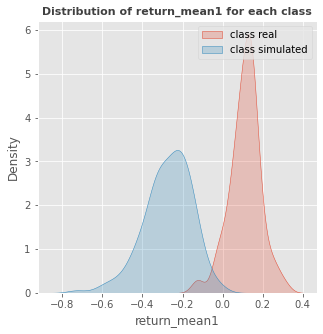

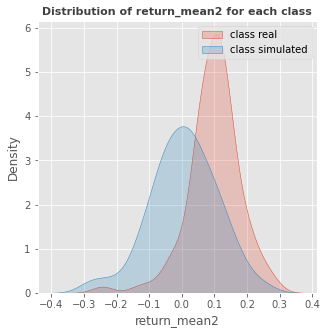

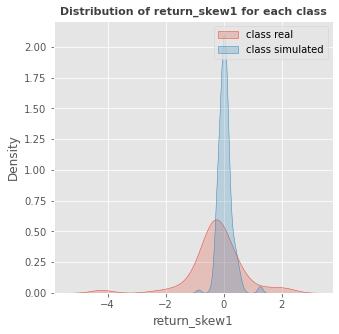

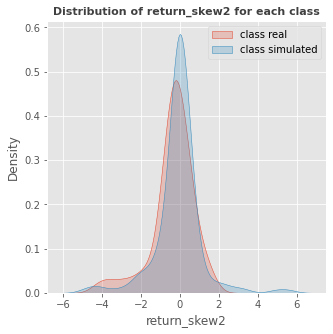

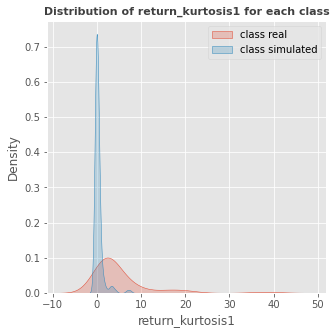

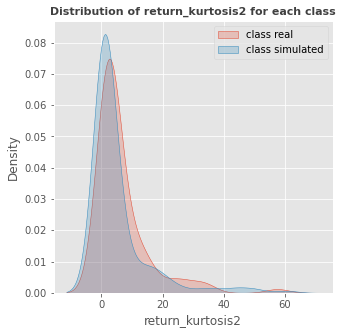

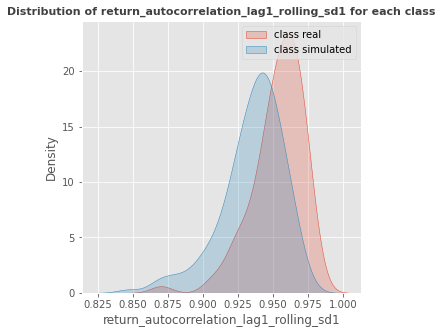

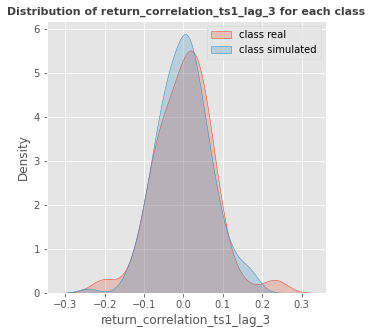

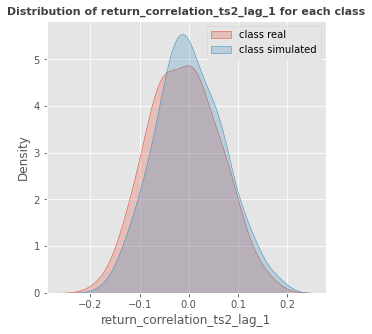

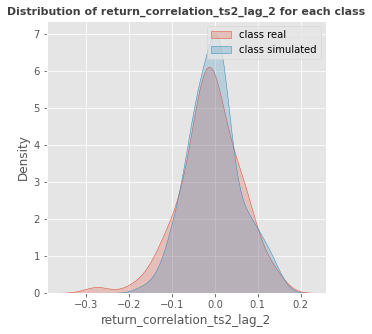

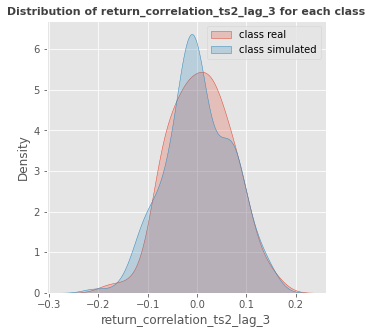

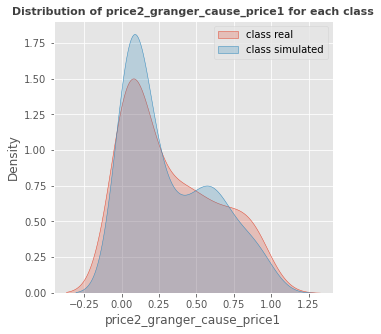

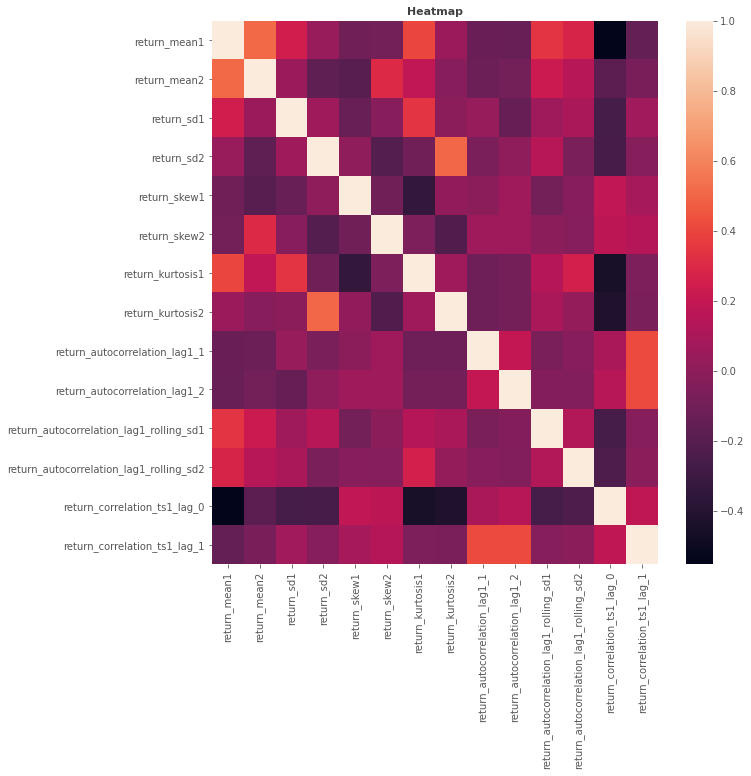

In [6]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
real_statistics = real_statistics.iloc[0:124 ,:]
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=alpha, 
        beta1=beta1, beta2=beta2, 
        delta0=delta0, 
        mu1=mu1, mu2=mu2, 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:21]
    y = dataset.iloc[:, 21]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/ou_jump12_calibration_update_classification_EDA/AutoML_EDA")
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)

In [7]:
print(results)
print(accuracy_average)
print(accuracy_std)

[0.9642857142857143, 0.9910714285714286, 0.9821428571428571, 0.6428571428571429, 0.9910714285714286]
0.9142857142857143
0.13606627286820527
